In [1]:
#%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
import osmnx as ox, geopandas as gpd, pandas as pd, networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from IPython.display import Image
from descartes import PolygonPatch
from itertools import combinations, combinations_with_replacement
%matplotlib inline
ox.config(log_console=True, use_cache=True)
%config IPCompleter.greedy=True

import libpysal as lp

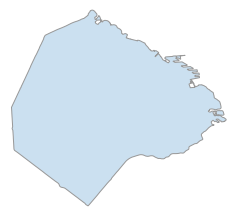

{'init': 'epsg:4326'}


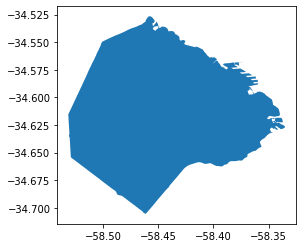

time: 404 ms


In [2]:
city = ox.gdf_from_place('Buenos Aires, Argentina')
#city = ox.project_gdf(city)
fig, ax = ox.plot_shape(city, figsize=(4,4))
ox.save_gdf_shapefile(city)
crs = {'init': 'epsg:4326'}
city = city.to_crs(crs)
print(city.crs)
city.plot()

5396
data max index: 5395
number of NA prices: 0
average bedroom price 51.921921223029024
pointinpoly length: 5396
check contains: True
check if there are NAs: False


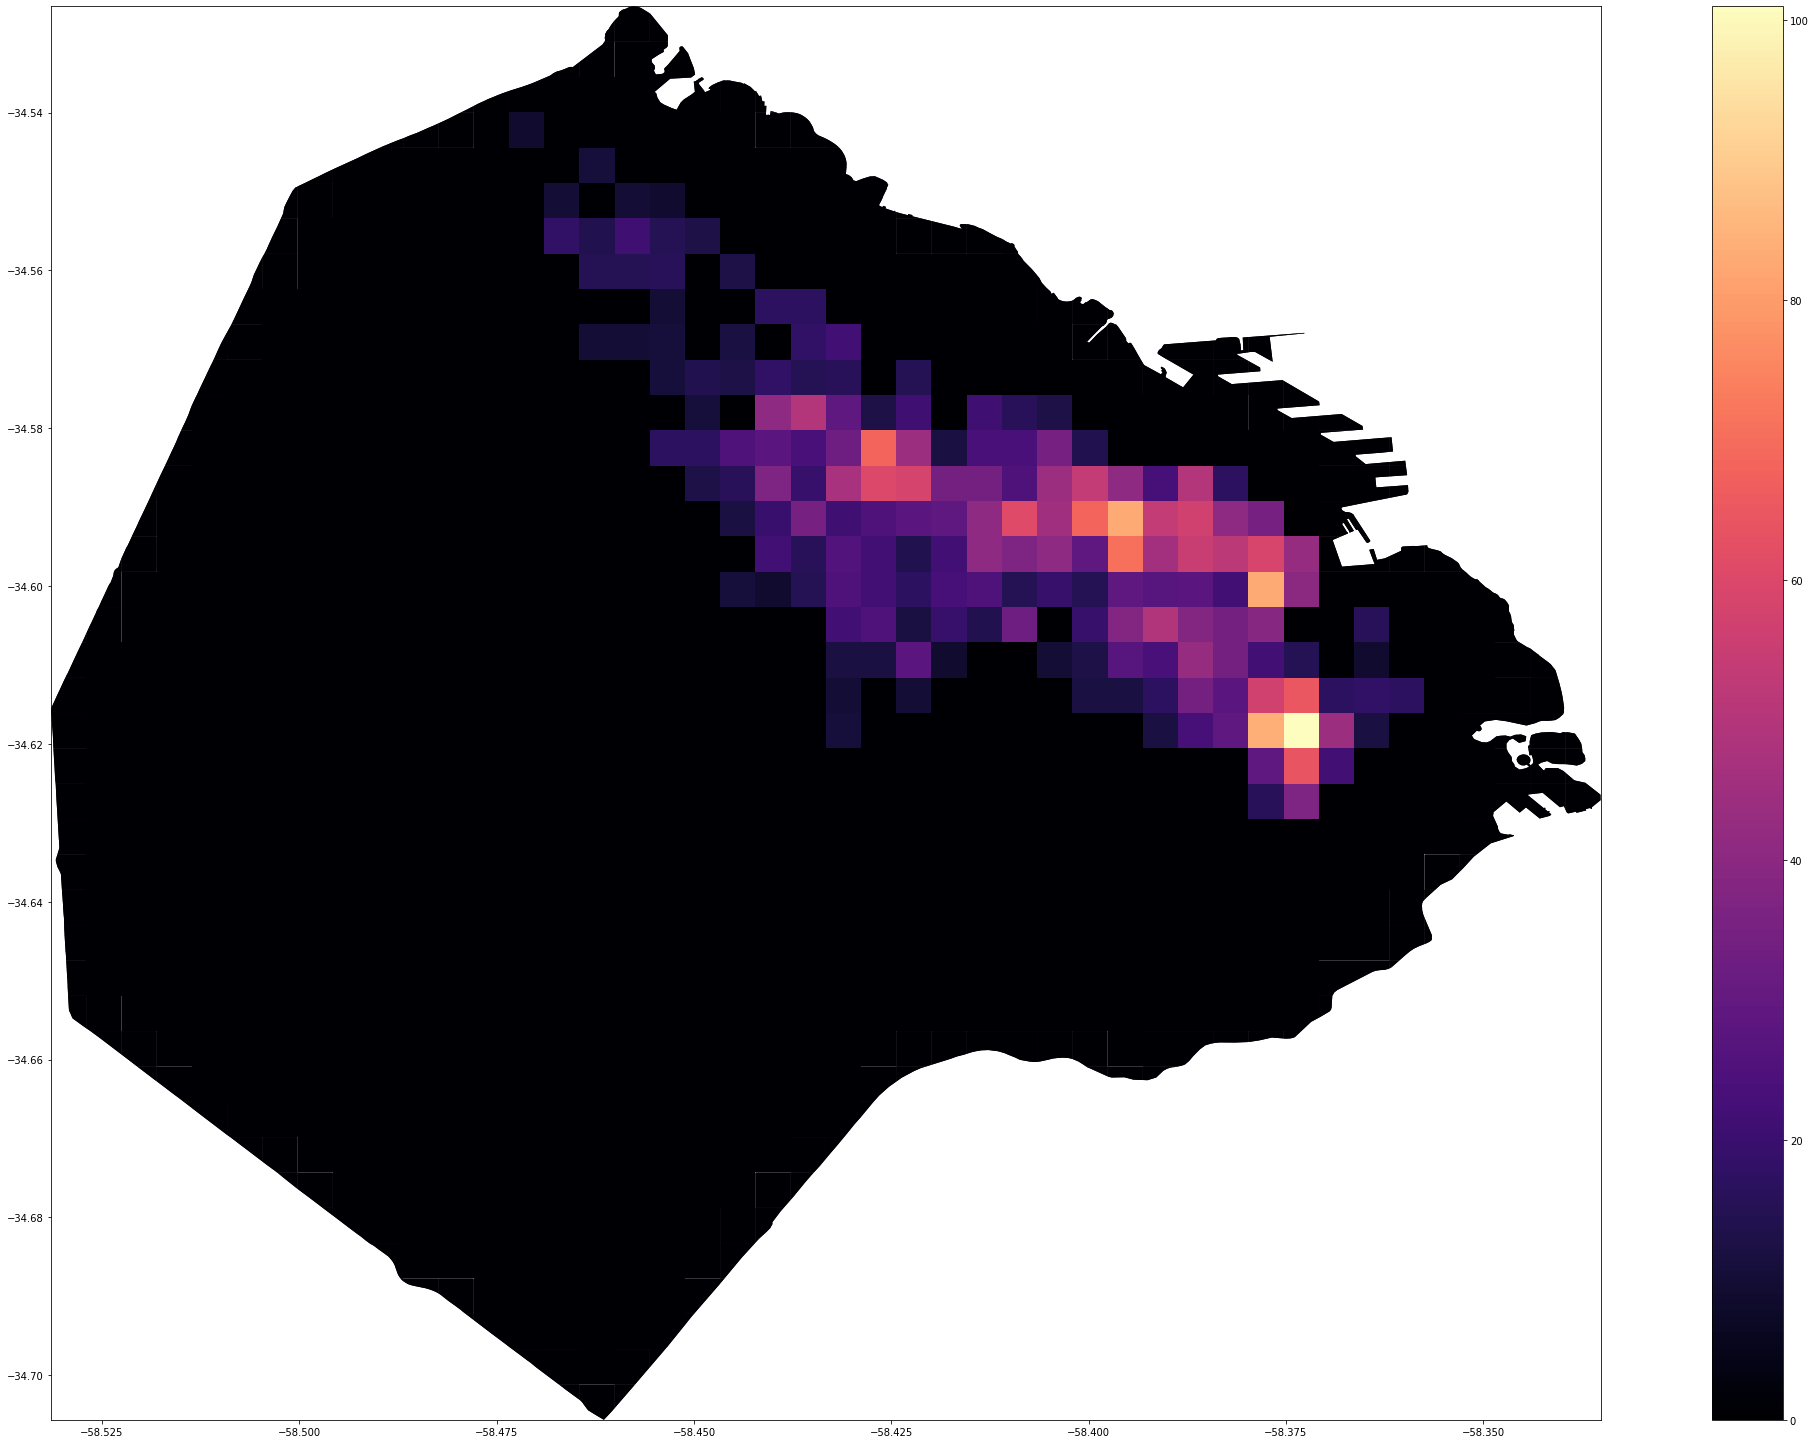

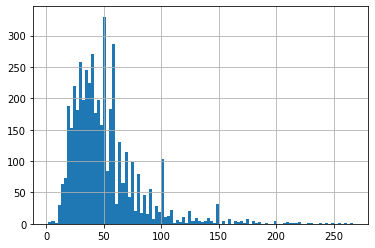

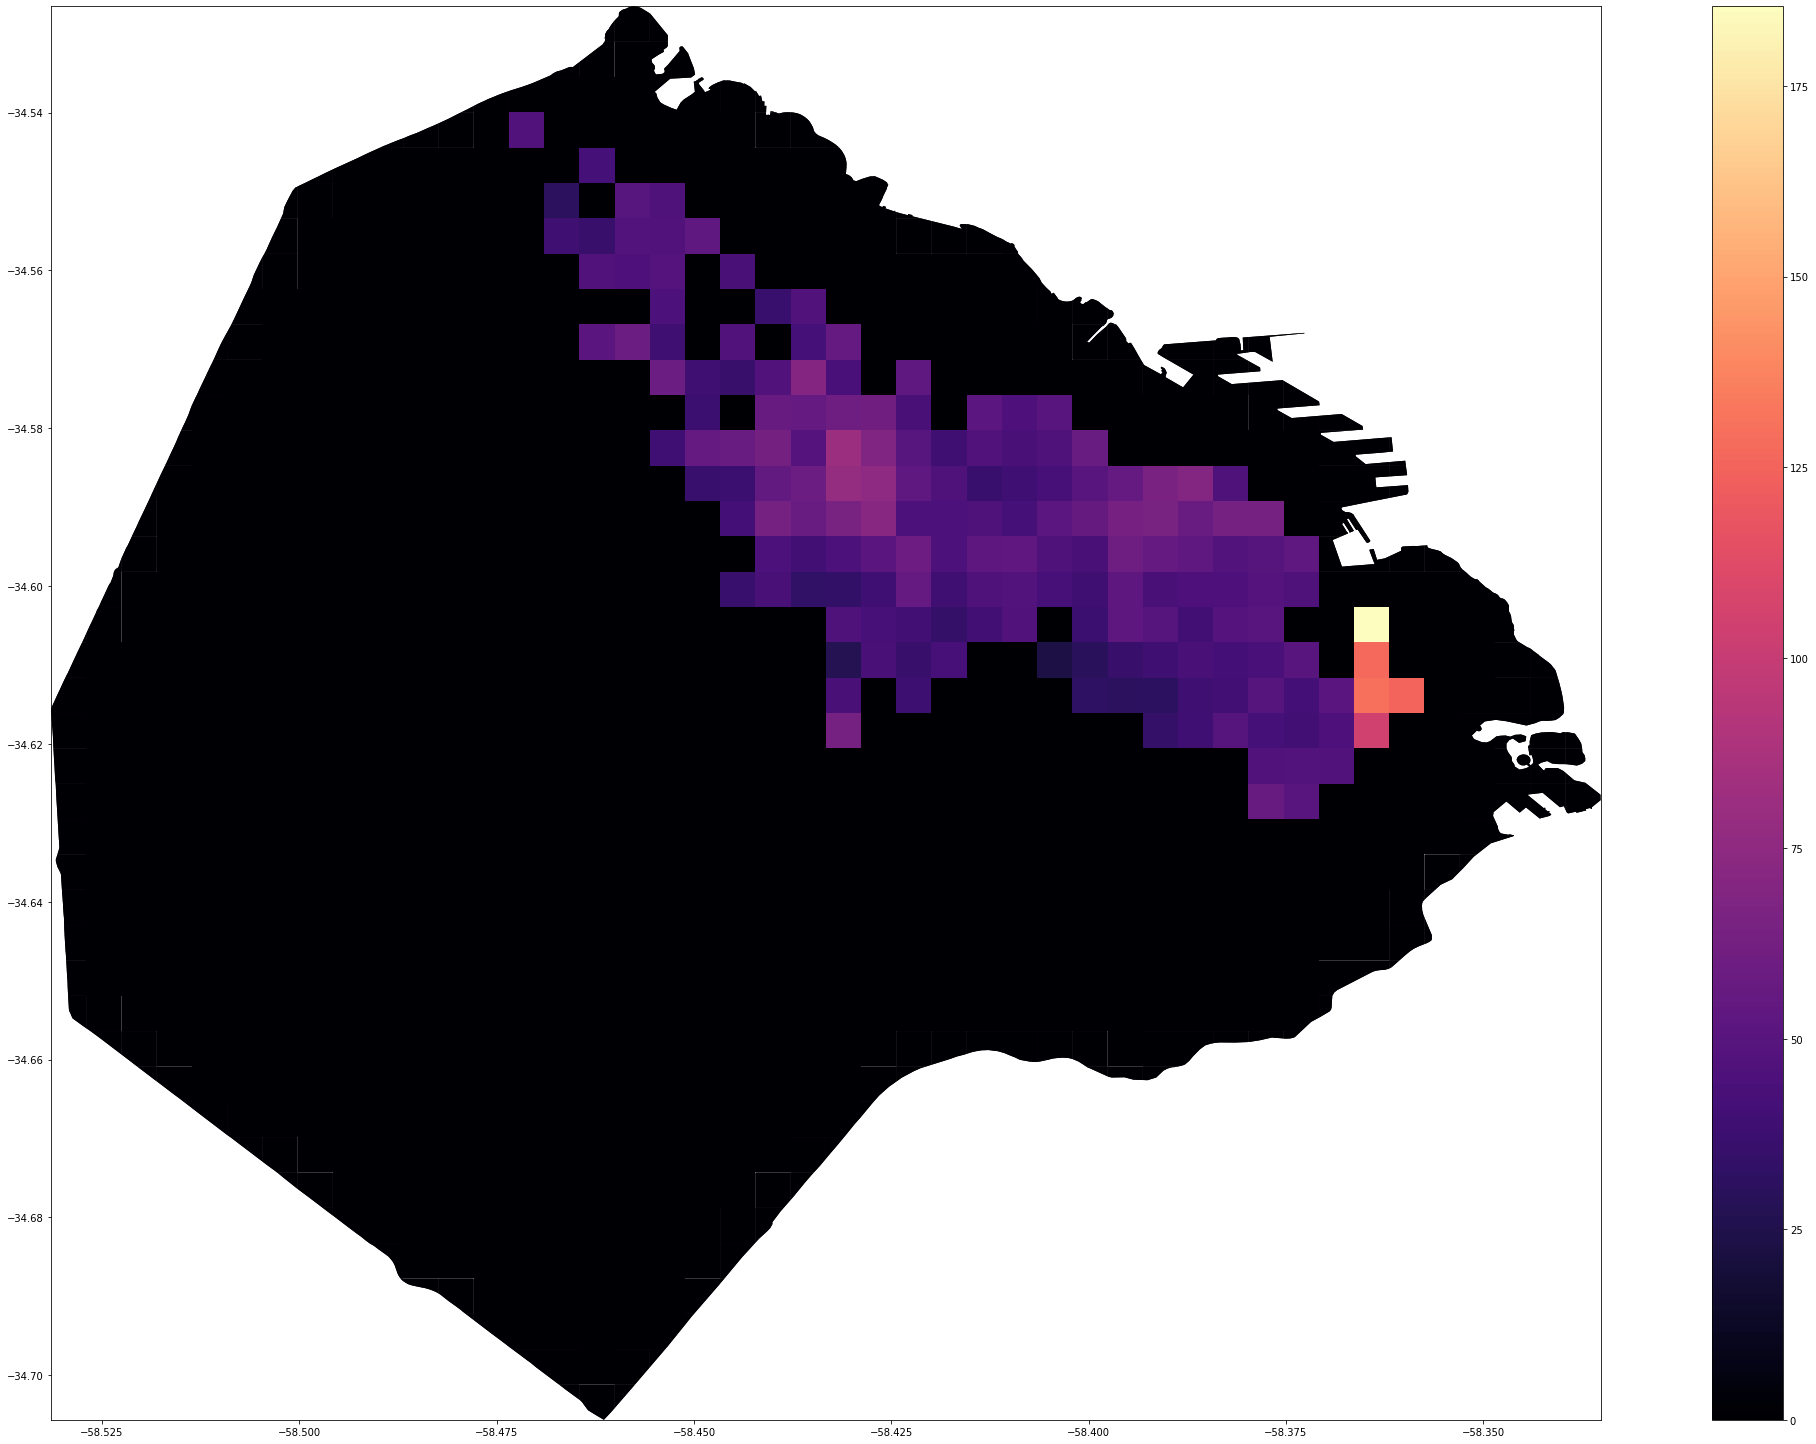

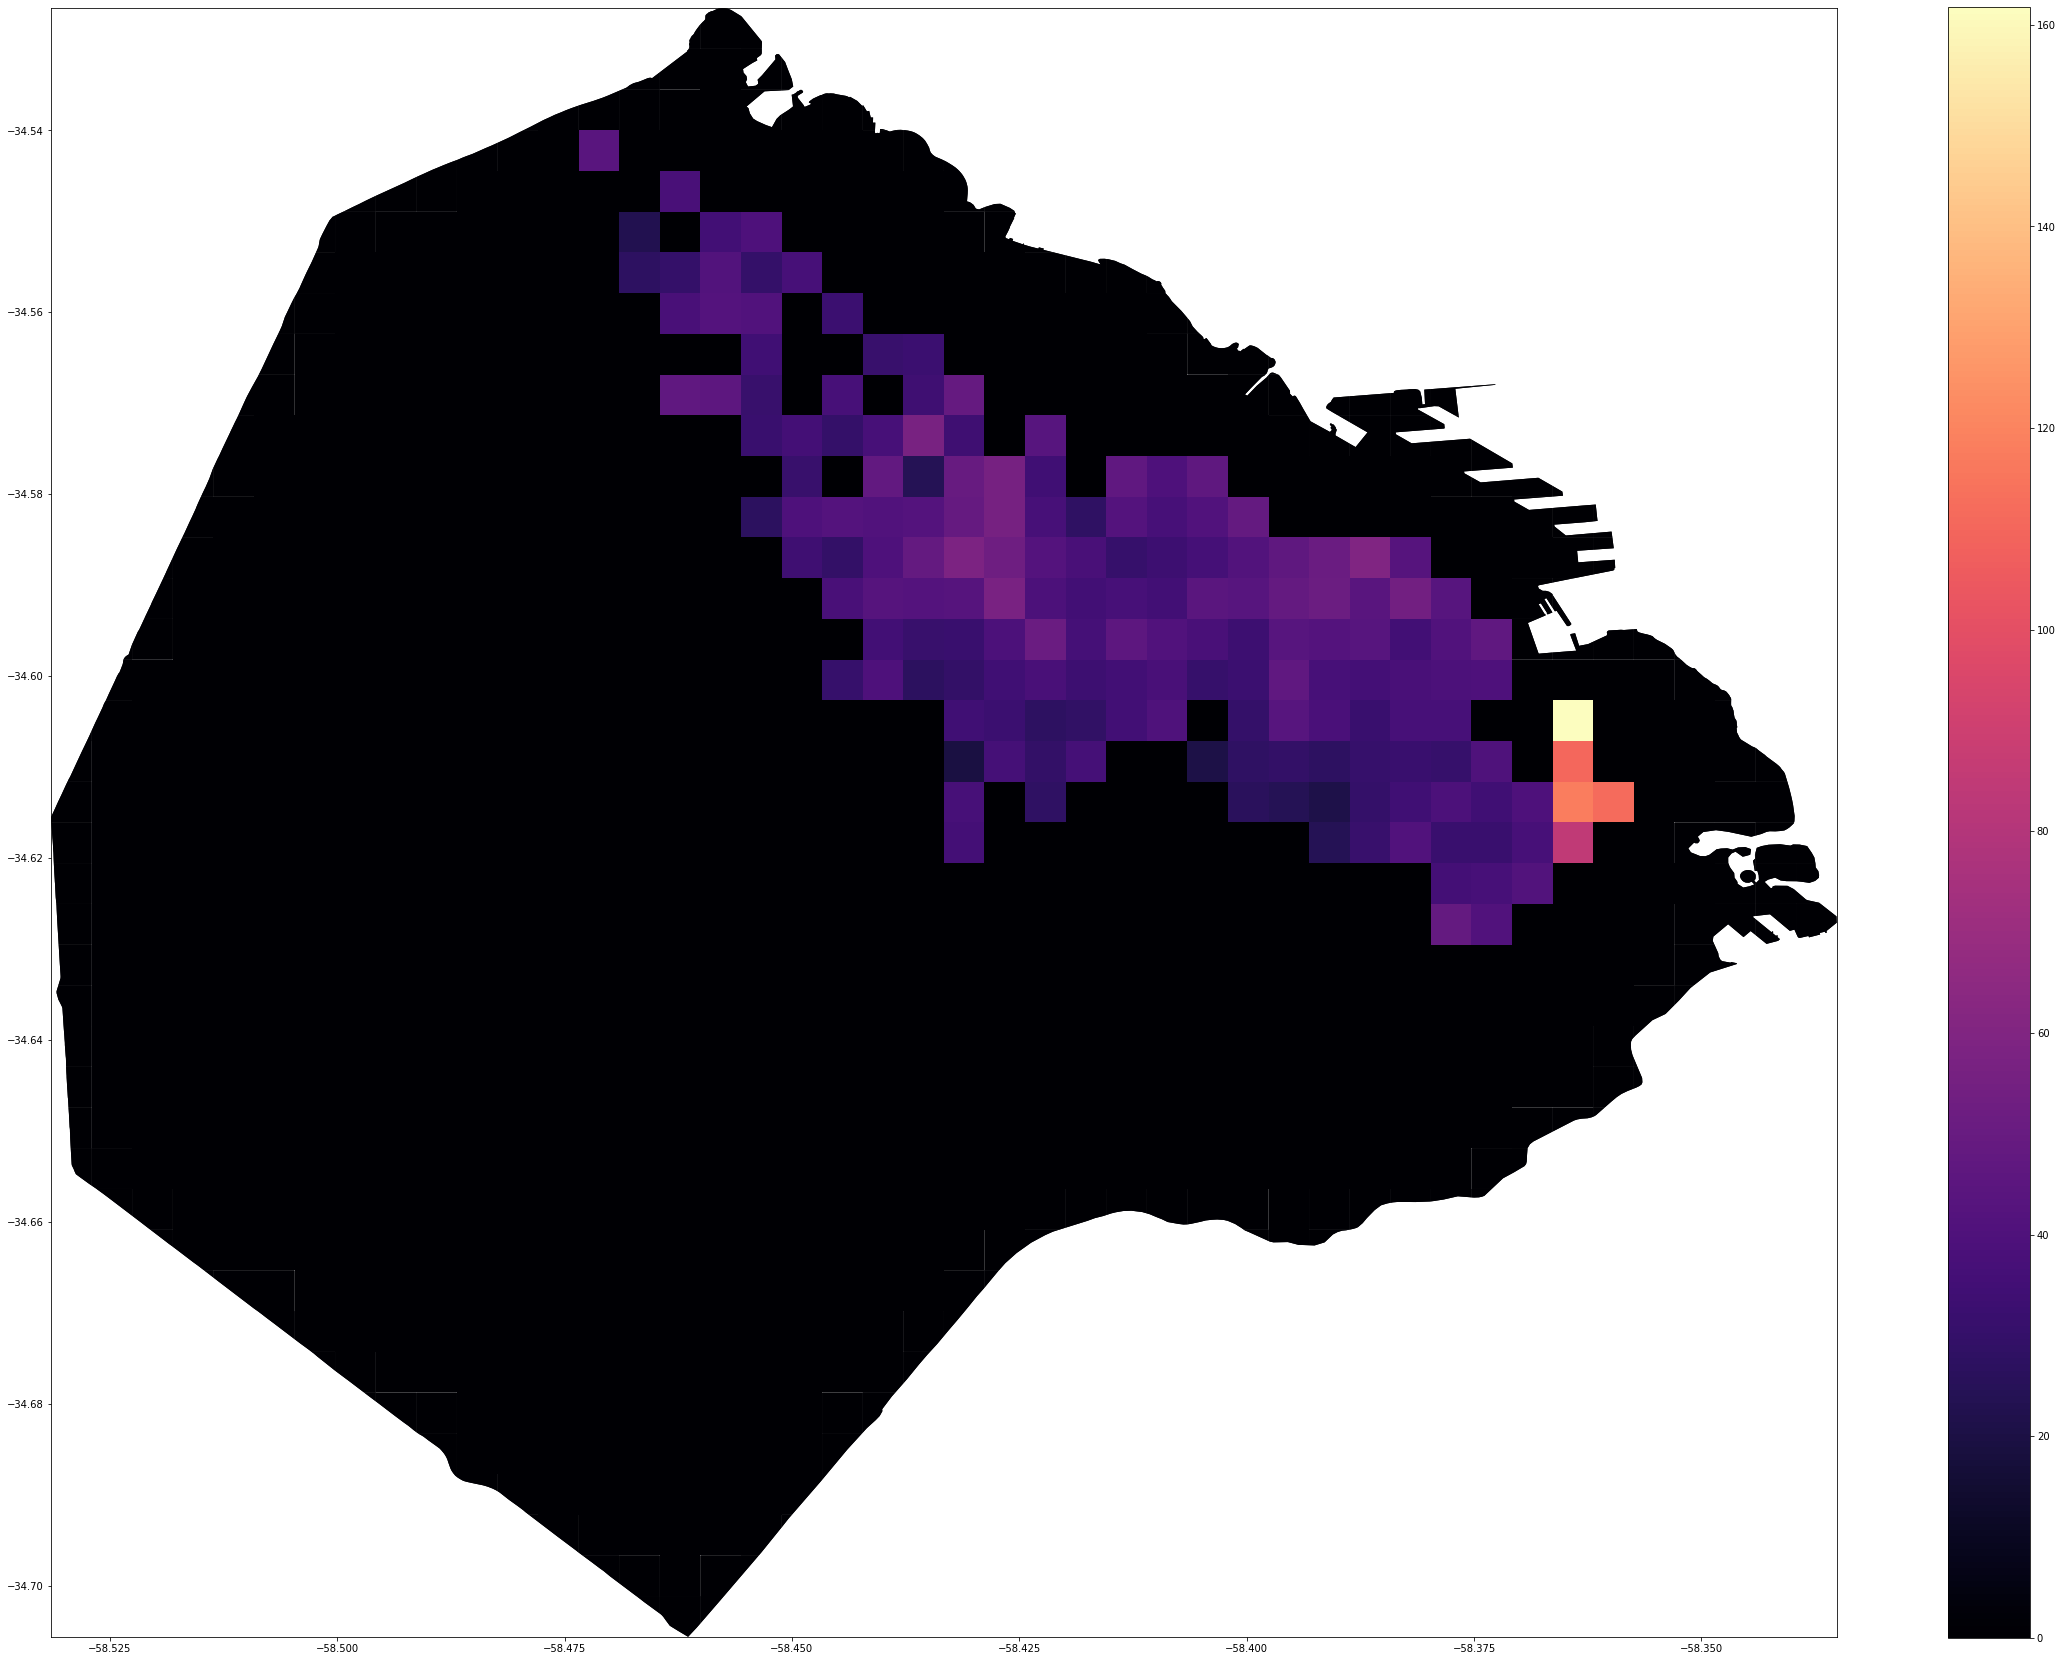

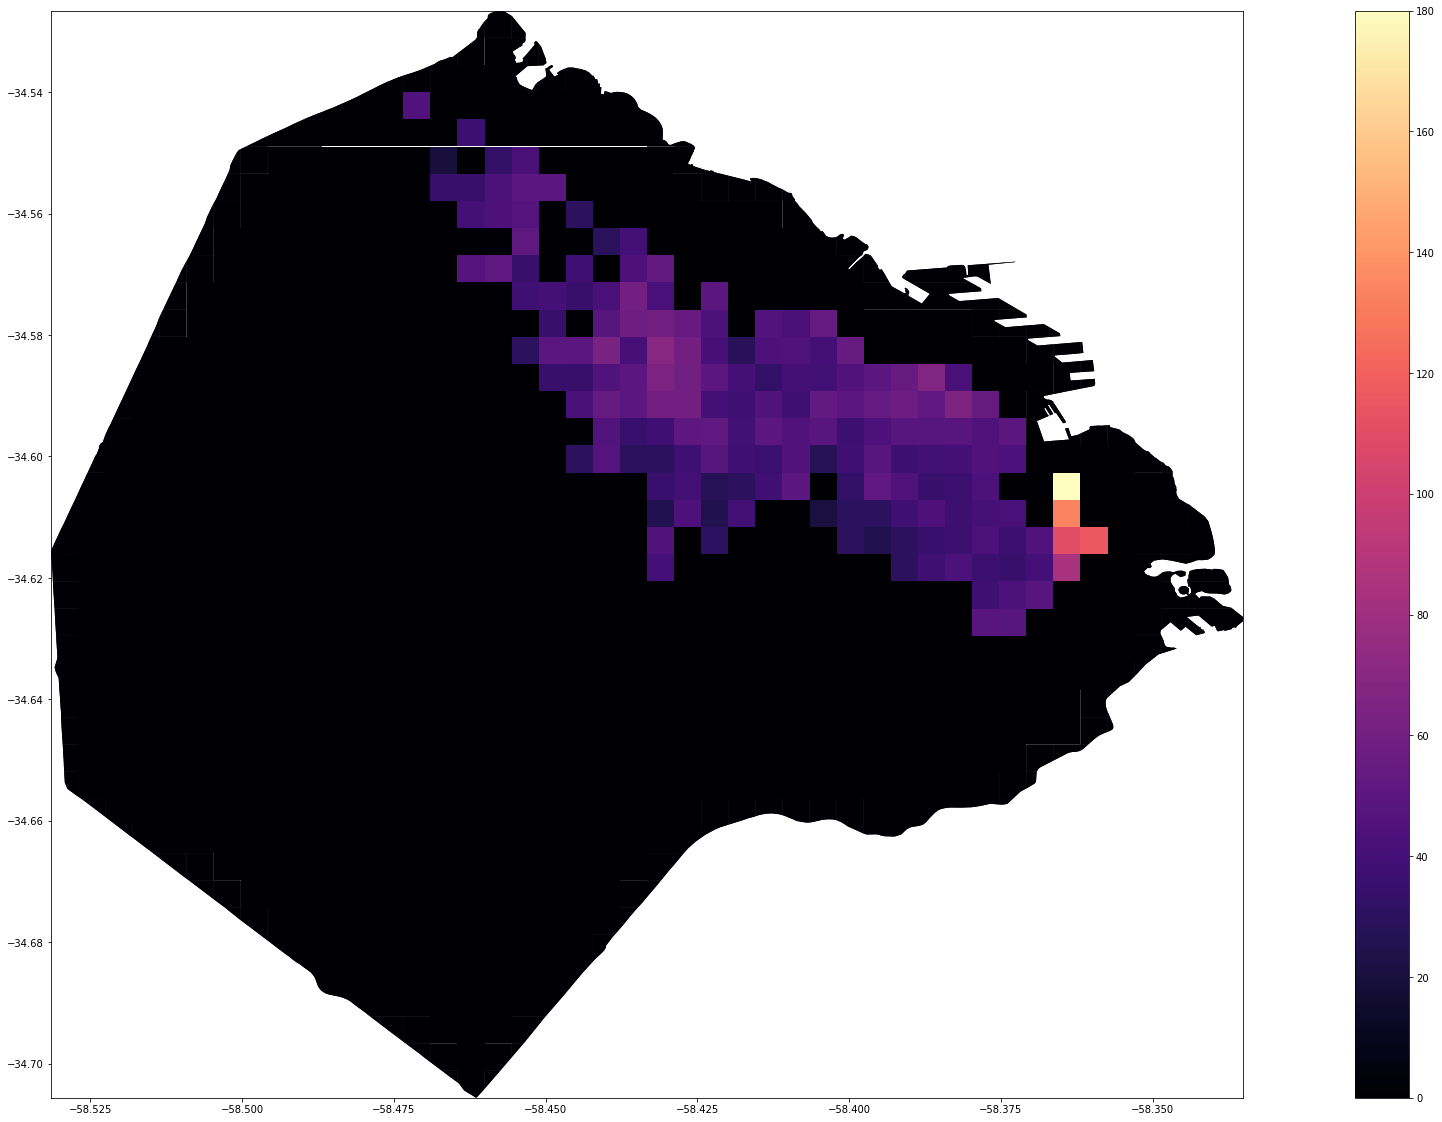

time: 7.86 s


In [3]:
data = pd.read_csv('data/Airbnb_Buenos_Aires.csv', header=0, index_col=0)
data = data[['room_id','latitude', 'longitude', 'bedrooms', 'price']]
print(len(data))

data.reset_index(drop=True, inplace=True)
print("data max index:", data.index.max())
print("number of NA prices:", data.price.isna().sum())

data.loc[data.bedrooms == 0, 'bedrooms'] = 1

price_proom = np.divide(np.array(data[pd.notnull(data['bedrooms'])].price),np.array(data[pd.notnull(data['bedrooms'])].bedrooms))
mean_bed = np.mean(price_proom)
print("average bedroom price",mean_bed)

nan_list = data[data.bedrooms.isna()].index.tolist()
data.loc[data.bedrooms.isna(), 'bedrooms'] = np.ceil(data.loc[data.bedrooms.isna(), 'price']/mean_bed)

geometry = [Point(xy) for xy in zip(data.longitude, data.latitude)]
#data = data.drop(['longitude', 'latitude'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)

meter_500 = 0.00899928/2


# make the geometry a multipolygon if it's not already
geometry = city['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])
    
# quadrat_width is in the units the geometry is in, so we'll do a tenth of a degree
geometry_cut = ox.quadrat_cut_geometry(geometry, quadrat_width=meter_500)

city['coords'] = city['geometry'].apply(lambda x: x.representative_point().coords[:])
city['coords'] = [coords[0] for coords in city['coords']]

polylist = [p for p in geometry_cut]

polyframe = gpd.GeoDataFrame(geometry=polylist)
polyframe.crs = city.geometry.crs
polyframe['center_lon'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][0])
polyframe['center_lat'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][1])


pointInPoly = gpd.sjoin(polyframe, gdf, op='contains')
print("pointinpoly length:",len(pointInPoly))

#pointInPoly.sort_values(['PlateID', 'Time'], inplace=True)
pointInPoly['index'] = pointInPoly.index
pointInPoly.reset_index(drop=True, inplace=True)


present_ind = list(pointInPoly['index_right'])
gdf_test_dropped = gdf.iloc[present_ind,:]
gdf_dropped = gdf_test_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)

print("check contains:",polyframe.iloc[pointInPoly.loc[len(pointInPoly)-1, 'index']].geometry.contains(gdf_dropped.loc[len(pointInPoly)-1,'geometry']))
gdf_dropped['pindex'] = pointInPoly['index']

print("check if there are NAs:", gdf_dropped.isna().values.any())

pindex = gdf_dropped.pindex.unique()
airbnb_dict = dict(gdf_dropped.pindex.value_counts())
counts = pd.DataFrame(list(airbnb_dict.items()), columns=['key', 'count'])
counts = counts[counts['count']>8]
counts = counts.copy()
airbnb_dict = dict(zip(list(counts['key']), list(counts['count'])))
polyair = polyframe.copy()
polyair['count'] = 0
polyair['count'].update(pd.Series(airbnb_dict))

# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='count',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


gdf_dropped = gdf_dropped[gdf_dropped.pindex.isin(airbnb_dict.keys())]
gdf_dropped = gdf_dropped.copy()
gdf_dropped = gdf_dropped[gdf_dropped['price'] > 0]
gdf_dropped = gdf_dropped.copy()
gdf_dropped['price_normalized'] = gdf_dropped.price.divide(gdf_dropped.bedrooms)
gdf_dropped = gdf_dropped[gdf_dropped.price_normalized<270]
gdf_dropped = gdf_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)
gdf_dropped.price_normalized.hist(bins=100)

prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].mean())
from scipy import stats
hmean_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].apply(lambda x: stats.hmean(x)))
median_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].median())

polyair['prices'] = 0
polyair['hmean_prices'] = 0
polyair['median_prices'] = 0
polyair['prices'].update(pd.Series(prices_dict))
polyair['hmean_prices'].update(pd.Series(hmean_prices_dict))
polyair['median_prices'].update(pd.Series(median_prices_dict))


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()



# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,30))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='hmean_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


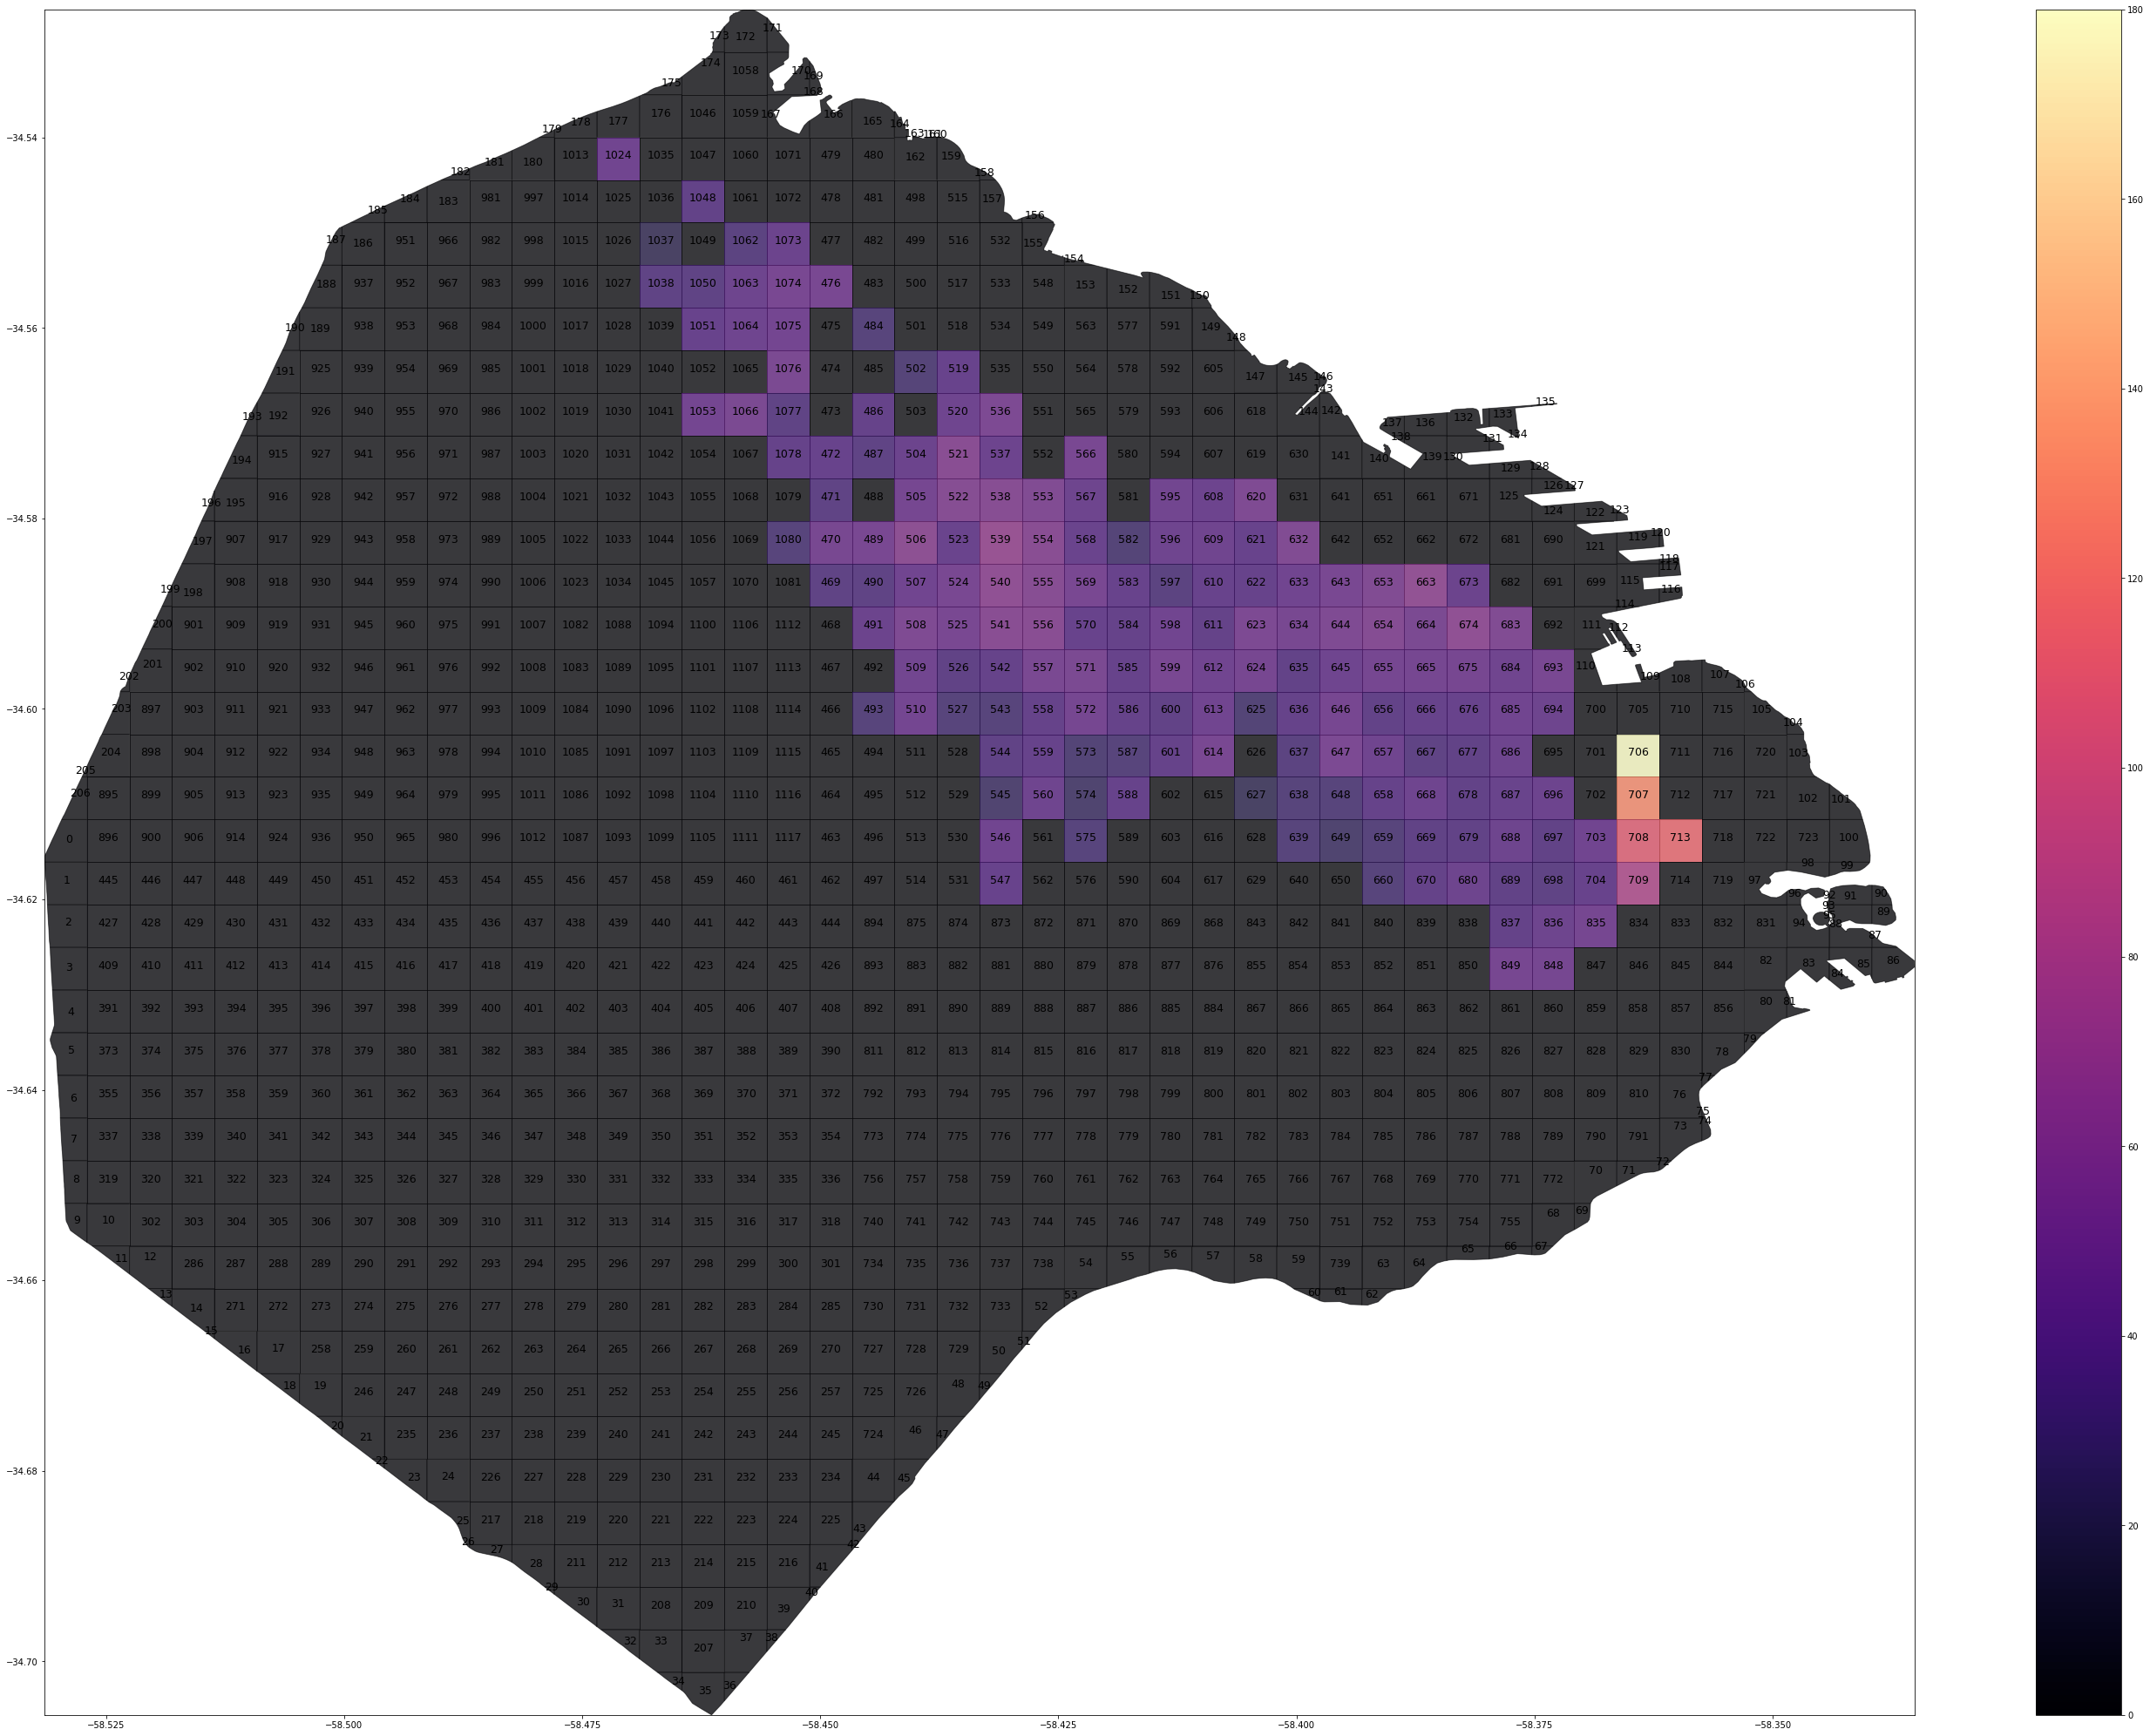

time: 11.6 s


In [4]:
# plot the city
west, south, east, north = city.unary_union.bounds

fig, ax = plt.subplots(figsize=(50,36))
for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5)
    ax.add_patch(patch)
    plt.annotate(s=n, xy=p,
                 horizontalalignment='center', size=12.5)
polyframe.plot(ax=ax, color='#000004', alpha=0.5)
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax, alpha=0.7, zorder=2)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

1118
1096


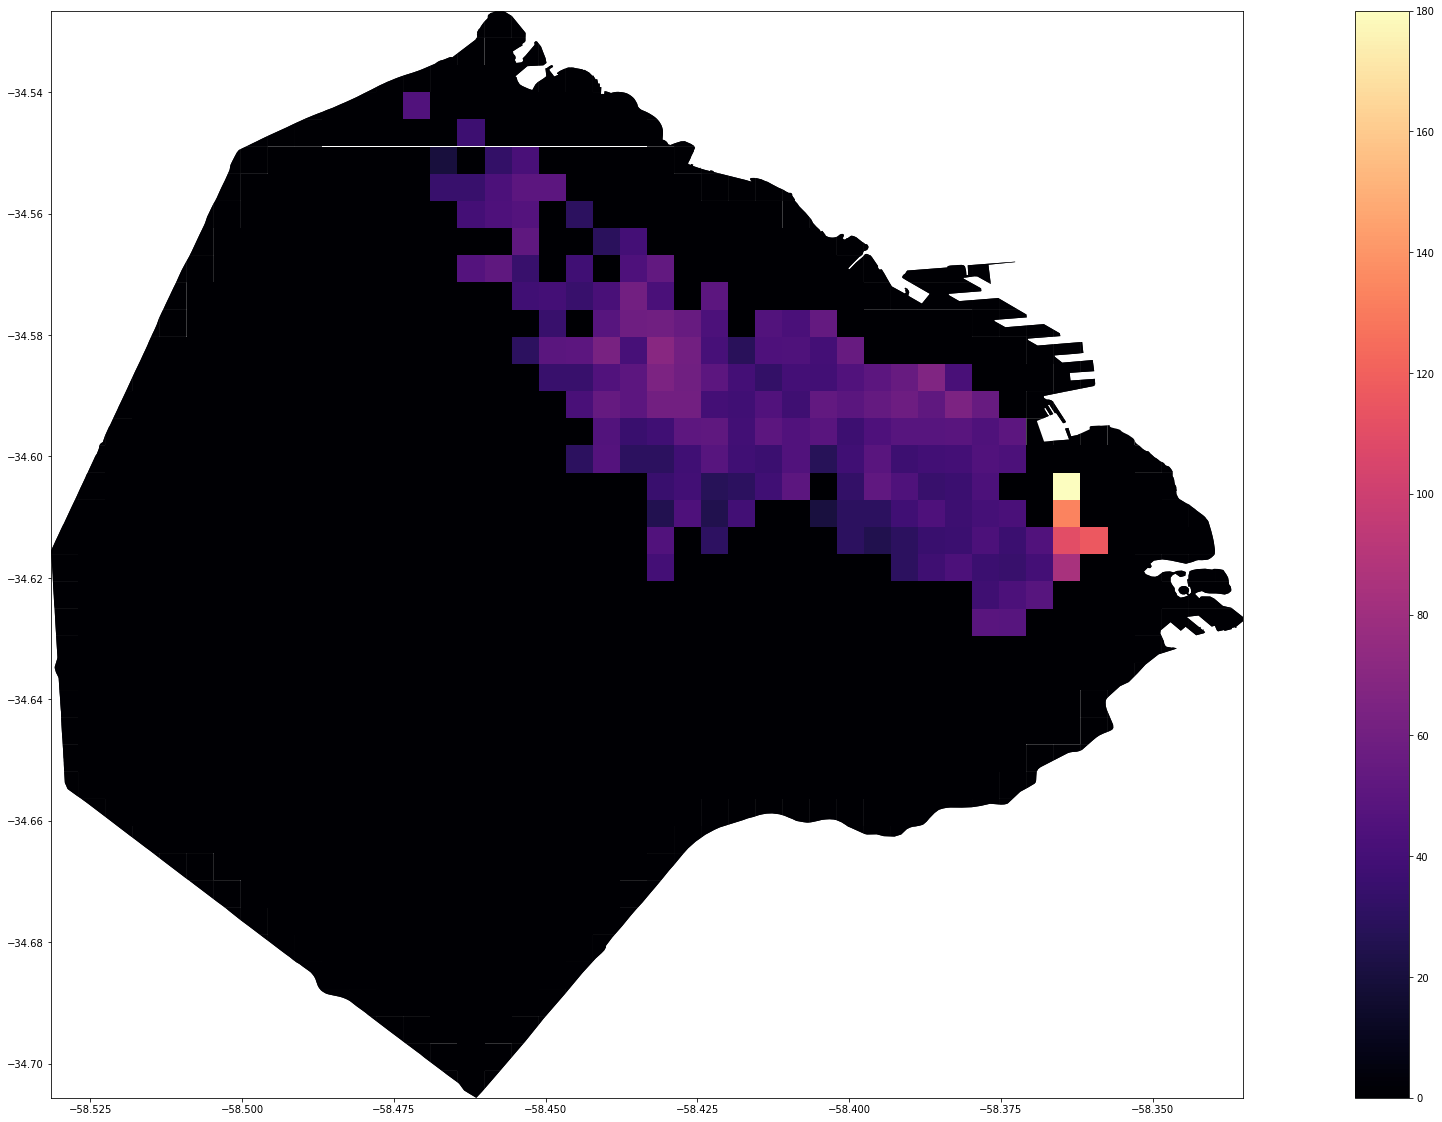

time: 1.41 s


In [5]:
print(len(polyair))
polyair = polyair[~polyair.index.isin([695,700,701,702,705,108,110,710,711,712,106,107,715,716,717,718,719,714,831,832,833,834])]
print(len(polyair))

# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

1096
1086


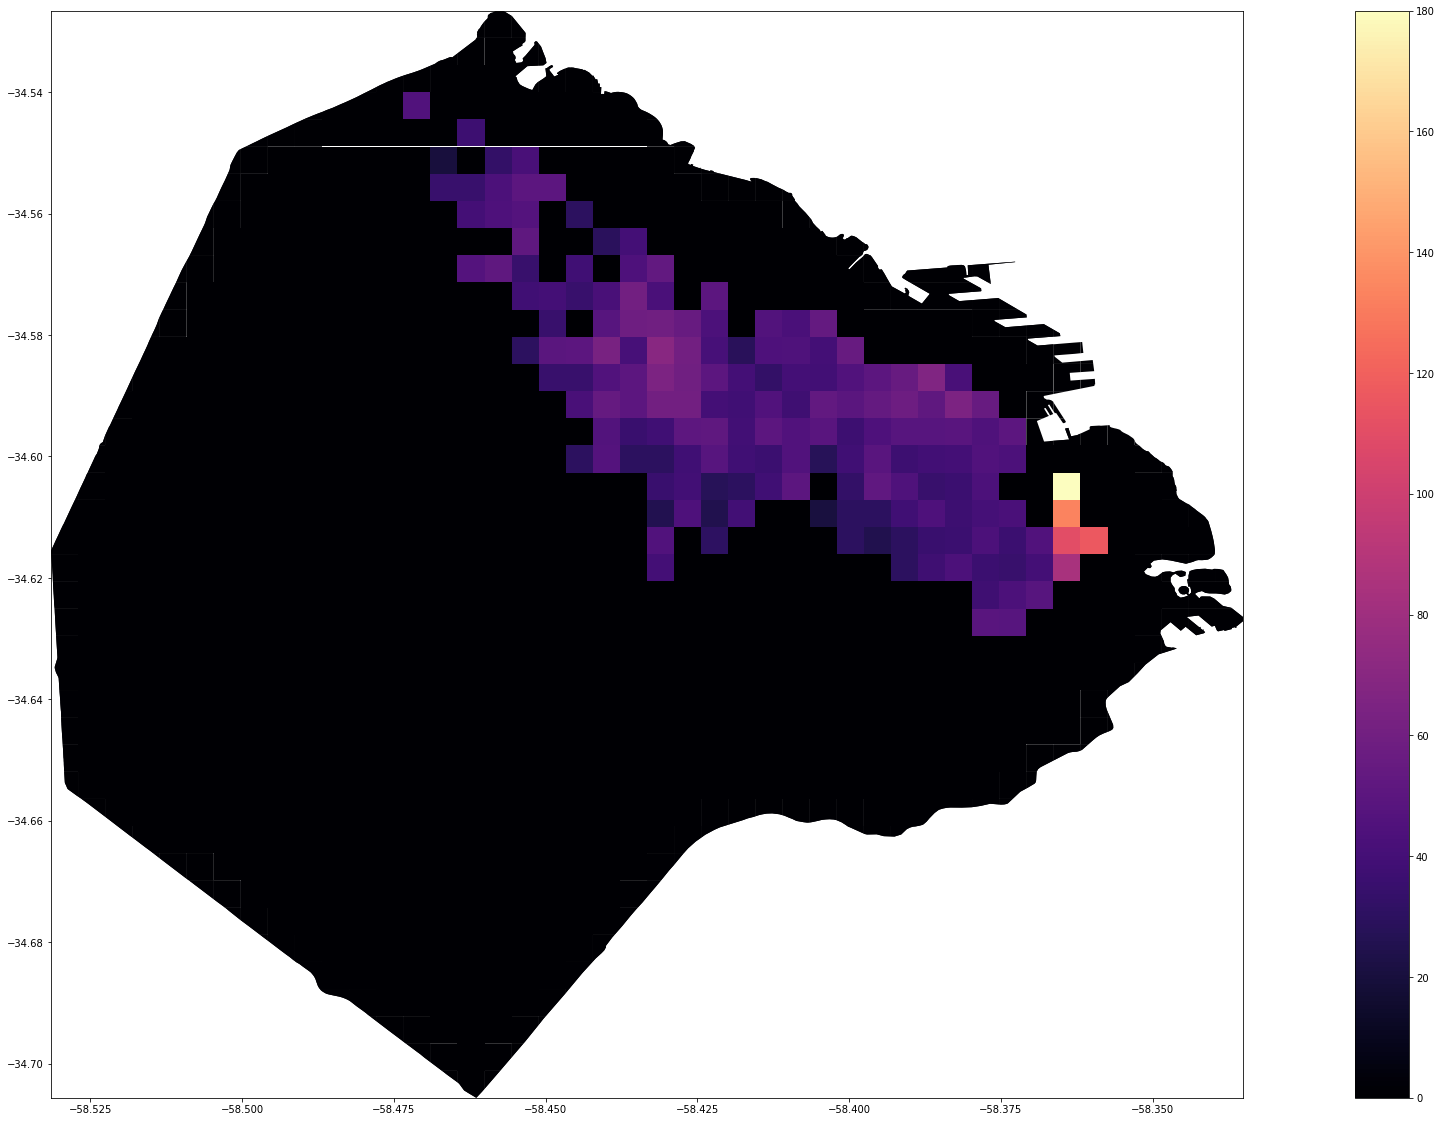

time: 1.38 s


In [6]:
print(len(polyair))
polyair = polyair[~polyair.index.isin(list(range(110,121)))]
print(len(polyair))

# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

1086
1085


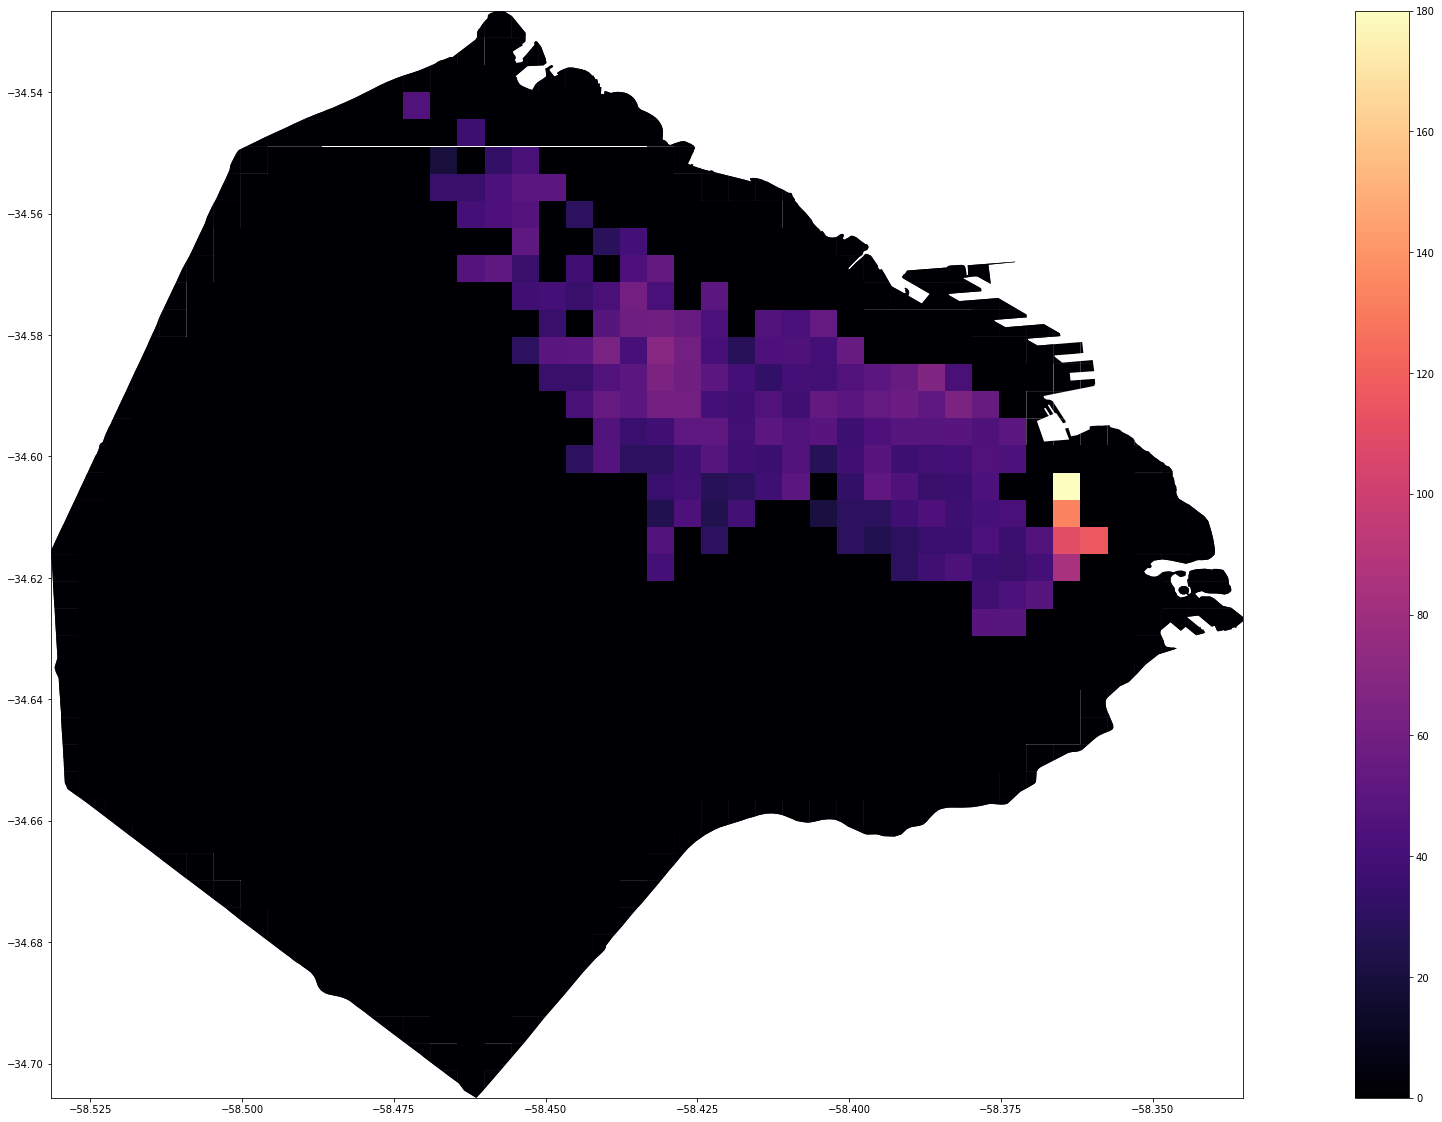

time: 1.39 s


In [7]:
print(len(polyair))
polyair = polyair[~polyair.index.isin([109])]
print(len(polyair))

# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

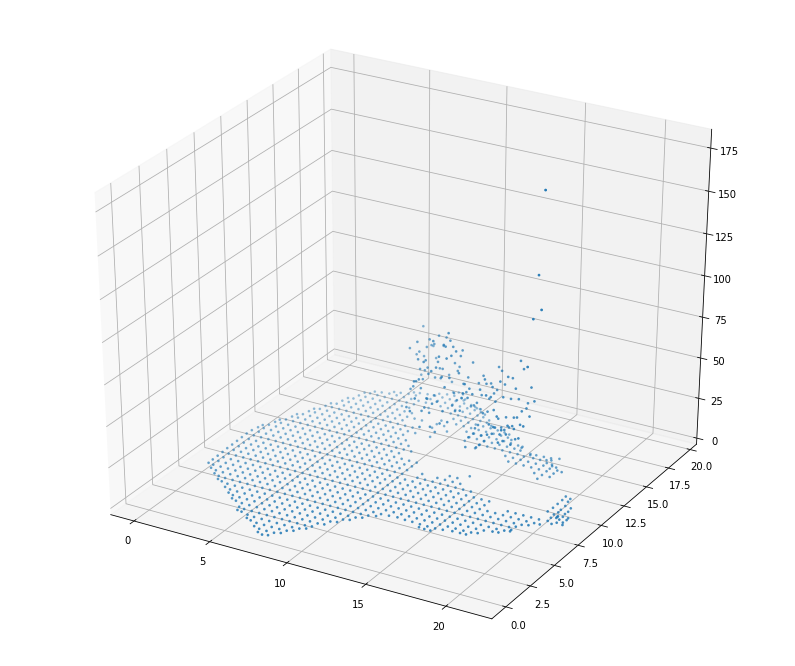

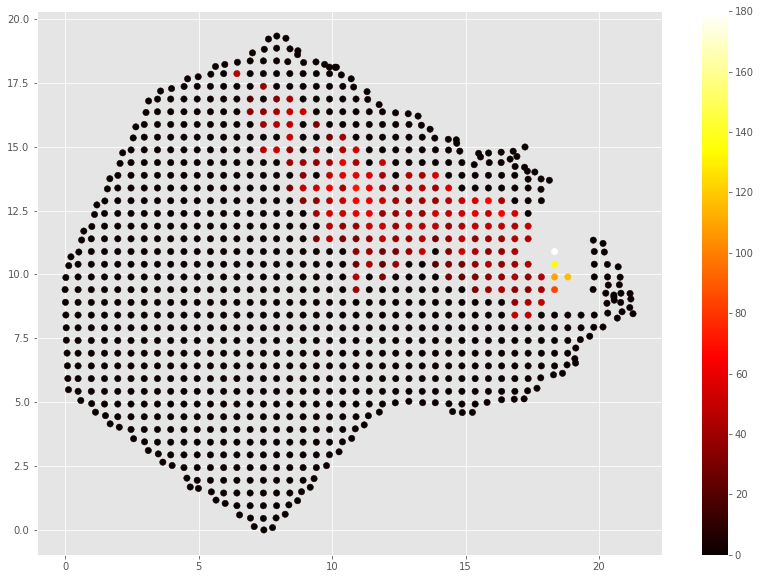

time: 2.18 s


In [8]:
import plotly.plotly as py
import plotly.graph_objs as go

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
from mpl_toolkits.mplot3d import Axes3D
#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

y = np.array(polyair.center_lat)*500/meter_500 
y = y-y.min()
y = y/1000


# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, np.array(polyair.median_prices), cmap='plasma', s=3)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(30, 300)
plt.show()


plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(14,10))
scat = ax.scatter(x, y, c=np.array(polyair.median_prices), s=40, cmap='hot')
cbar = fig.colorbar(scat)
#cbar.set_clim(0, 250)
plt.savefig('images/Buenos_Aires_observed.jpg')
plt.show()

In [9]:
cdf = polyair[polyair.index.isin([706, 663, 539])]
cdf["cen_lon_km"] = cdf['center_lon'].apply(lambda x: (x*500/meter_500 - (polyair.center_lon*500/meter_500).min())/1000)
cdf["cen_lat_km"] = cdf['center_lat'].apply(lambda x: (x*500/meter_500 - (polyair.center_lat*500/meter_500).min())/1000)
cdf

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



geometry  center_lon  \
539  POLYGON ((-58.43329184999551 -34.5802785500045...  -58.431061   
663  POLYGON ((-58.38867050908641 -34.5847556375045...  -58.386439   
706  POLYGON ((-58.36635983863187 -34.6026639875045...  -58.364129   

     center_lat  count      prices  hmean_prices  median_prices  cen_lon_km  \
539  -34.582517     33   80.895960     49.273030      70.000000   10.898330   
663  -34.586994     50   70.256803     59.924063      66.666667   15.856654   
706  -34.604903     16  185.466667    161.761290     180.000000   18.335815   

     cen_lat_km  
539   13.385791  
663   12.888297  
706   10.898321

time: 325 ms


Fitted parameters:
[ 45.39495262  13.4275798   12.12333064   1.4752753    4.69426411
  -1.13274537   2.49398607 407.95188711  19.15303756  13.42251265
   0.46149357   2.31567595   6.44430274   1.63128626]
RMS residual = 8.68958865067432


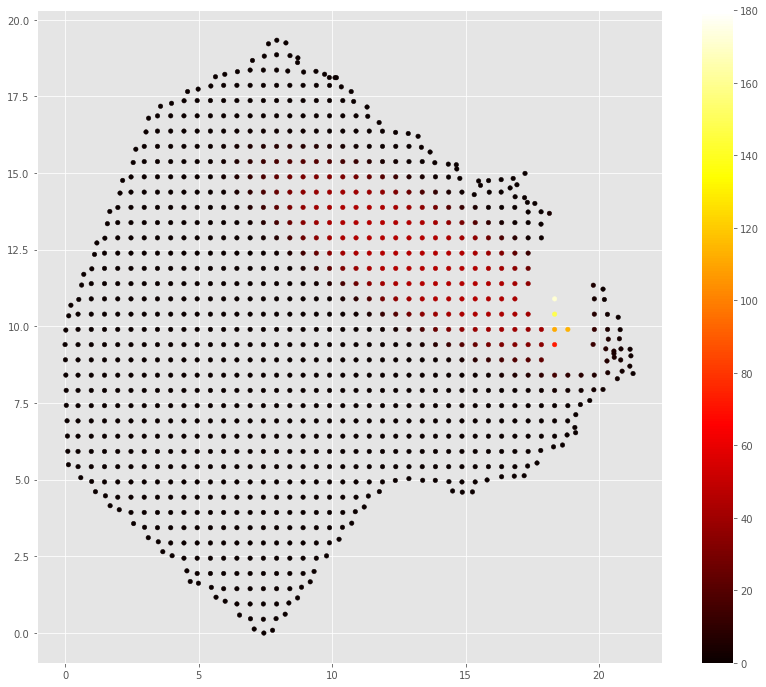

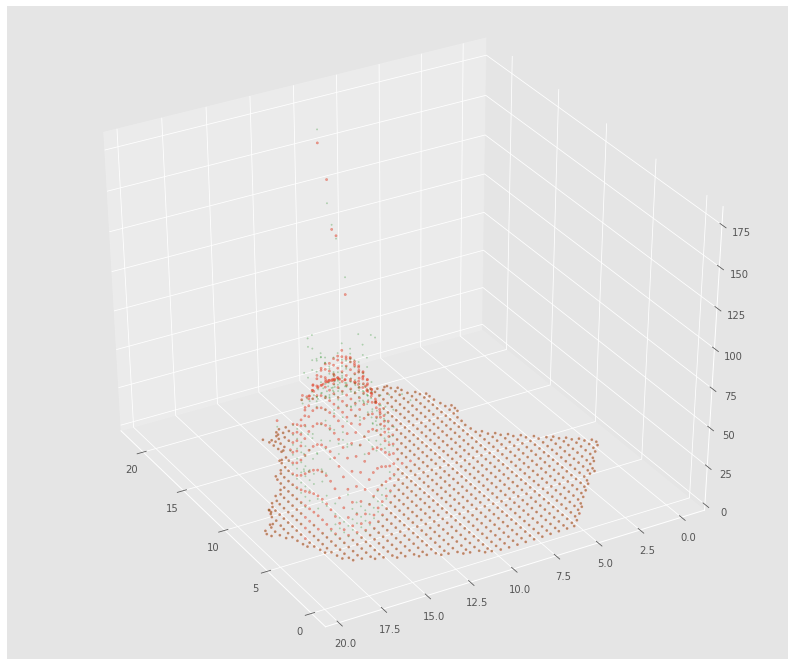

{'Buenos_Aires': 2.0626361633770363}
time: 1.47 s


In [10]:
alphas = {}
xy = np.vstack([x, y])
zobs = np.array(polyair.median_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//7):
        arr += twoD_Gaussian_alpha(xy, *args[i*7:i*7+7])
    return arr

guess_prms = [(70,10.898330,13.385791, 1,1,1, 1.5),
              #(66.66,15.856654,12.888297, 1,1,1, 1.5),
              (180,18.335815,10.898321, 1,1,1, 1.5)
             ]

# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian_alpha(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, alpha):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2))**alpha)
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//7):
    zpred += twoD_Gaussian_alpha(xy, *popt[i*7:i*7+7])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=20, cmap='hot')
fig.colorbar(scat)
plt.savefig('Buenos_Aires_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=5, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=2, alpha=0.2)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(35, 150)
plt.show()

alphas['Buenos_Aires'] = np.mean(popt[6::7])
print(alphas)

In [11]:
import pickle
pickle_in = open("alphas.pickle","rb")
alphas_dict = pickle.load(pickle_in)
#prices_params_dict = {}
alphas_dict['Buenos_Aires'] = alphas['Buenos_Aires']
print(alphas_dict)
pickle_out = open("alphas.pickle","wb")
pickle.dump(alphas_dict, pickle_out)
pickle_out.close()

{'Paris': 1.9119263949210794, 'Amsterdam': 1.6077156181165682, 'Stockholm': 1.4869621148124246, 'Arezzo': 1.5291330654483044, 'Berlin': 1.3281036059479567, 'Bordeaux': 1.387341915093677, 'Denver': 0.9886695315944182, 'Edinburgh': 1.7431661910906637, 'Lyon': 1.840995035260712, 'Madrid': 1.561423826026336, 'Buenos_Aires': 2.0626361633770363, 'Los_Angeles': 1.7386638625850566, 'Beijing': 1.77233254047711, 'Florence': 1.052999973906332, 'Moscow': 1.822610958759147, 'Porto': 1.4172416677632145, 'Prague': 1.3671832768992007, 'Reykjavik': 1.4194582940670377, 'Riga': 1.4587192546215861, 'Rome': 1.8608390724186512, 'Seoul': 1.3208669147673713, 'Siena': 0.6212787996336754, 'Sydney': 2.584174464016137, 'Tallin': 2.014994948135572, 'Treviso': 1.07320426583068, 'Valencia': 1.5432619, 'Venezia': 1.3156028460923, 'Verona': 1.4364606330705336, 'Vicenza': 1.20971848439062, 'Vienna': 1.3399164167136137, 'Wellington': 1.46363348, 'Zurich': 1.72383878, 'Aarhus': 1.87621535, 'Milan': 2.1468310347956194, 'B

Fitted parameters:
[ 5.59530841e+01  1.04034829e+01  1.32050854e+01  2.53385424e+00
  1.04172832e+00  8.85125022e-01  5.77375125e+01  1.55979906e+01
  1.14921632e+01  2.50924899e+00  1.11198009e+00  3.75503049e+00
  4.20844428e+02  1.88682499e+01  1.18877271e+01  1.25213556e+00
  3.34785085e-01 -2.02787637e+01]
RMS residual = 8.041216170365919


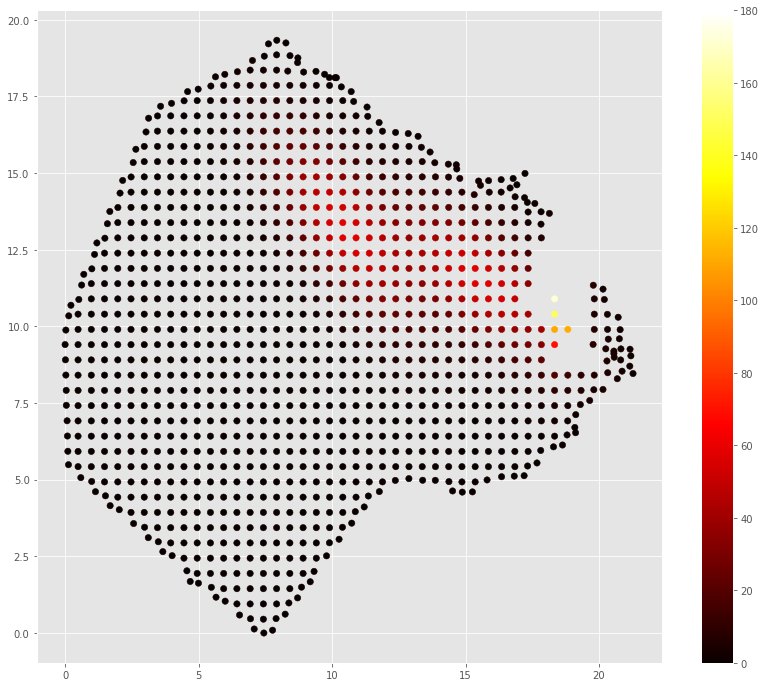

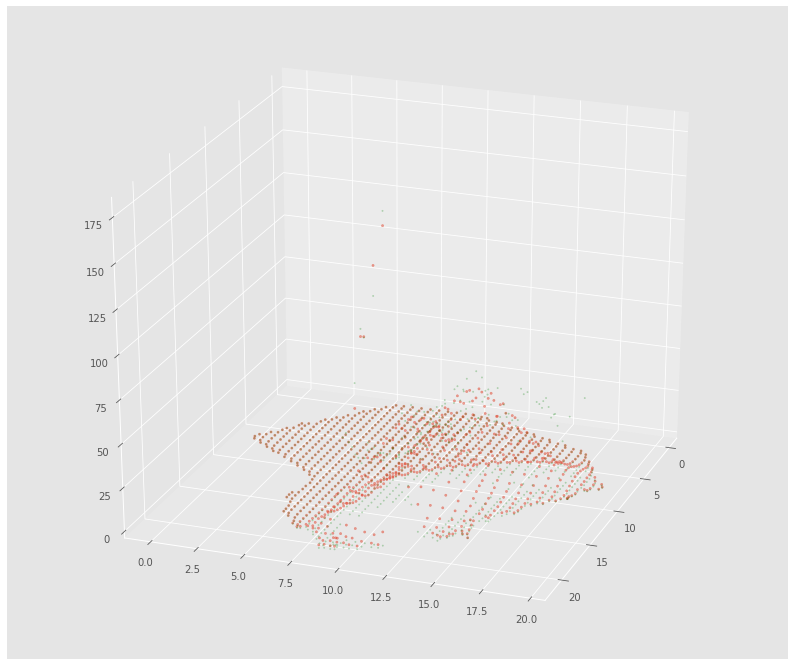

time: 1.6 s


In [12]:
xy = np.vstack([x, y])
zobs = np.array(polyair.median_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//6):
        arr += twoD_Gaussian(xy, *args[i*6:i*6+6])
    return arr


guess_prms = [(70,10.898330,13.385791, 1,1,1),
              (66.66,15.856654,12.888297, 1,1,1),
              (180,18.335815,10.898321, 1,1,1)
             ]
# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//6):
    zpred += twoD_Gaussian(xy, *popt[i*6:i*6+6])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=40, cmap='hot')
fig.colorbar(scat)
plt.savefig('Buenos_Aires_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=5, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=2, alpha=0.2)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(25, 20)
plt.show()

In [13]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

sqrt_eigs_long = np.array([])
sqrt_eigs_short = np.array([])
for i in range(0, len(popt), 6):
    a = (np.cos(popt[i+5])**2)/(2*popt[i+3]**2) + (np.sin(popt[i+5])**2)/(2*popt[i+4]**2)
    b = -(np.sin(2*popt[i+5]))/(4*popt[i+3]**2) + (np.sin(2*popt[i+5]))/(4*popt[i+4]**2)
    c = (np.sin(popt[i+5])**2)/(2*popt[i+3]**2) + (np.cos(popt[i+5])**2)/(2*popt[i+4]**2)
    cov = np.array([a, b, b, c]).reshape(-1, 2)
    print("Is cov_{} positive definite?: ".format(i//6+1), is_pos_def(cov))
    eigenvalues = np.linalg.eigvals(cov)
    eigenvalues = eigenvalues[eigenvalues>0]
    if eigenvalues.size!=0:
        stds = np.sqrt(eigenvalues)/popt[i]
        #stds = stds[stds>=0]
        sqrt_eigs_long = np.append(sqrt_eigs_long,max(stds))
        sqrt_eigs_short = np.append(sqrt_eigs_short,min(stds))

print('long stds: ', sqrt_eigs_long, 'mean: ', np.mean(sqrt_eigs_long))
print('short stds: ', sqrt_eigs_short, 'mean: ', np.mean(sqrt_eigs_short))

Is cov_1 positive definite?:  True
Is cov_2 positive definite?:  True
Is cov_3 positive definite?:  True
long stds:  [0.01213128 0.01101362 0.00501877] mean:  0.00938788752473718
short stds:  [0.00498746 0.00488071 0.00134188] mean:  0.0037366820044496137
time: 6.98 ms


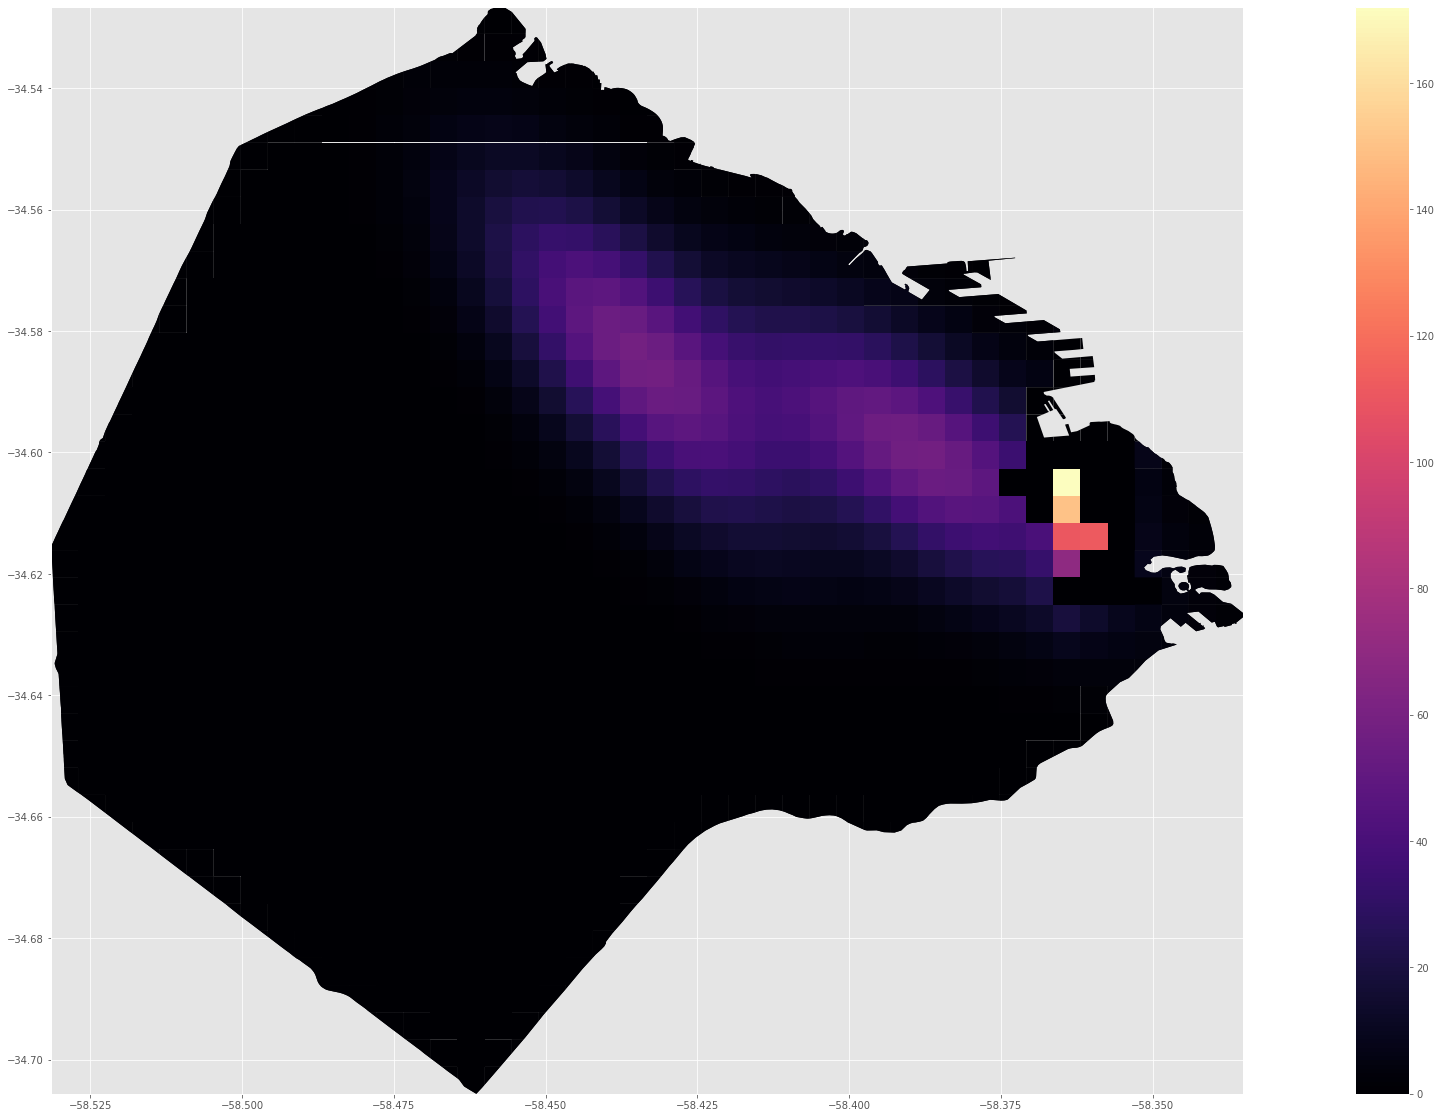

time: 1.51 s


In [14]:
polyair['zpred'] = zpred
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='zpred',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [15]:
import pickle
pickle_in = open("Prices_params.pickle","rb")
prices_params_dict = pickle.load(pickle_in)
#prices_params_dict = {}
prices_params_dict['Buenos_Aires'] = popt
pickle_out = open("Prices_params.pickle","wb")
pickle.dump(prices_params_dict, pickle_out)
pickle_out.close()

#average_slopes = {}
pickle_in_long = open("Average_price_slopes_long.pickle","rb")
average_slopes_long = pickle.load(pickle_in_long)
average_slopes_long['Buenos_Aires'] = np.mean(sqrt_eigs_long)
pickle_out_long = open("Average_price_slopes_long.pickle","wb")
pickle.dump(average_slopes_long, pickle_out_long)
pickle_out_long.close()

pickle_in_short = open("Average_price_slopes_short.pickle","rb")
average_slopes_short = pickle.load(pickle_in_short)
average_slopes_short['Buenos_Aires'] = np.mean(sqrt_eigs_short)
pickle_out_short = open("Average_price_slopes_short.pickle","wb")
pickle.dump(average_slopes_short, pickle_out_short)
pickle_out_short.close()

print('long: ', average_slopes_long, ' short: ', average_slopes_short)

long:  {'Paris': 0.010453121182320417, 'Amsterdam': 0.017790862401138207, 'Stockholm': 0.01160078748441716, 'Arezzo': 0.012661960610292892, 'Berlin': 0.017168942092868542, 'Bordeaux': 0.0057209390468692745, 'Denver': 0.00873766709683174, 'Edinburgh': 0.012921100209712873, 'Lyon': 0.00594530194011358, 'Madrid': 0.01315080289968449, 'Buenos_Aires': 0.00938788752473718, 'Palermo': 0.02659431146972356, 'Los_Angeles': 0.0056655377791732745, 'Beijing': 0.03548021455387483, 'Florence': 0.011913882705309832, 'Moscow': 0.026524810524746, 'Porto': 0.03745056113103571, 'Prague': 0.01850581507565583, 'Reykjavik': 0.04000475004839031, 'Riga': 0.02150786435094239, 'Rome': 0.009635062558537275, 'Seoul': 0.013154650694260608, 'Siena': 0.013838139160990736, 'Sydney': 0.009200022664460229, 'Tallin': 0.024848430854086192, 'Treviso': 0.015264513943951563, 'Valencia': 0.01982718757582555, 'Venezia': 0.013133572970121148, 'Verona': 0.01119208328282184, 'Vicenza': 0.029546407262138693, 'Vienna': 0.0120270170

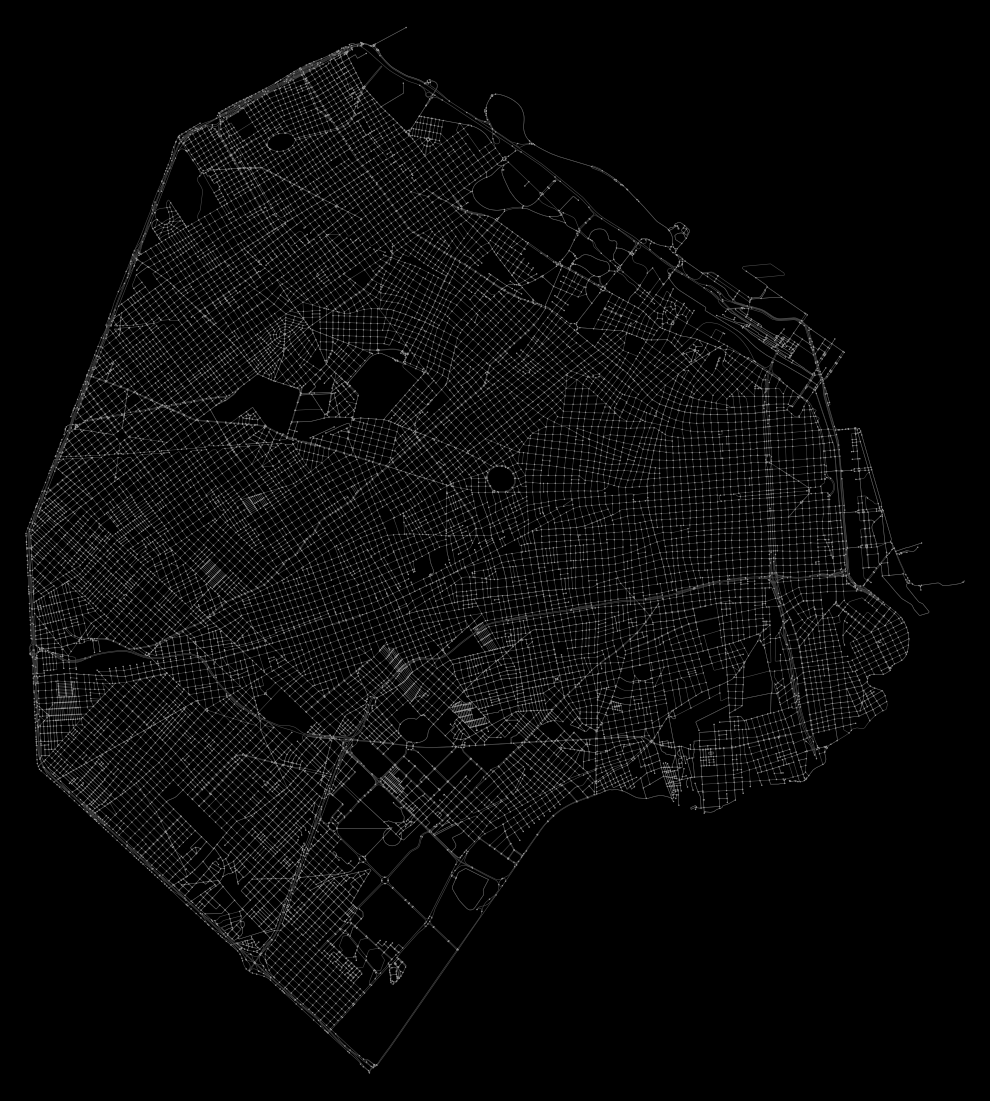

time: 29.7 s


In [16]:
# download and project a street network
G = ox.graph_from_place('Buenos Aires, Argentina', network_type="drive")
#G = ox.project_graph(G)
fig, ax = ox.plot_graph(G, fig_height=20, bgcolor='k', node_size=2, node_color='#999999', node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=0.5, edge_alpha=1)

In [17]:
centers = {}
for i in range(0, len(popt), 6):
    lon = popt[i+1]*1000 + (np.array(polyair.center_lon)*500/meter_500).min()
    lon = lon*meter_500/500
    lat = popt[i+2]*1000 + (np.array(polyair.center_lat)*500/meter_500).min()
    lat = lat*meter_500/500
    centers['center_node_{}'.format(i//6+1)] = ox.get_nearest_node(G, (lat,lon))

centers

{'center_node_1': 89138835,
 'center_node_2': 195645645,
 'center_node_3': 1628970159}

time: 128 ms


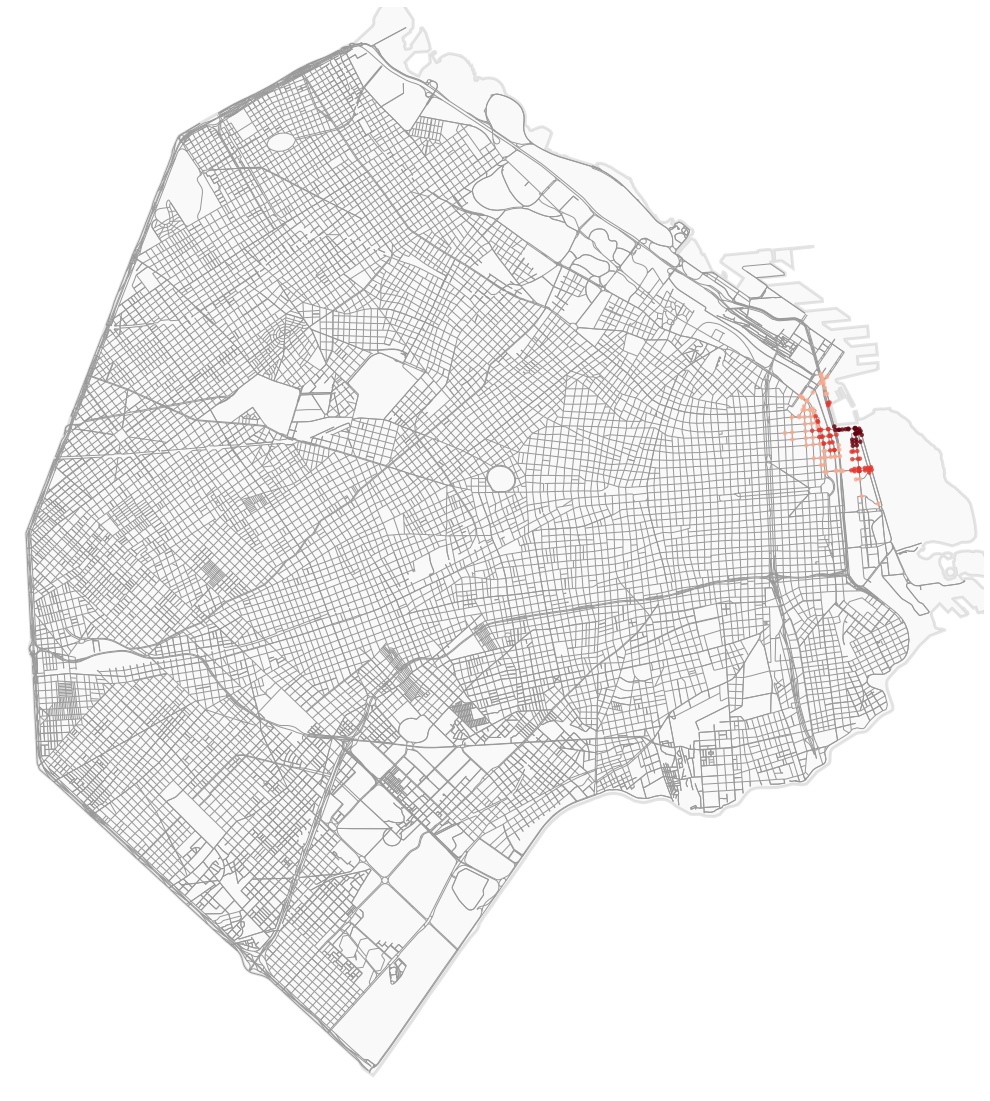

time: 7.75 s


In [18]:
import networkx as nx
#center_node = ox.get_nearest_node(G, (popt[8],popt[7]))
center_node = centers['center_node_3']
# list of distances from center
dists = np.arange(500, 2000, 500)
dists

# get one color for each isochrone
iso_colors = ox.get_colors(n=len(dists), cmap='Reds', start=0.3, return_hex=True)
# color the nodes according to isochrone then plot the street network
node_colors = {}
for dist, color in zip(sorted(dists, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=dist, distance='length')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=20,show=False, close=False, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)
plt.close()
# to this matplotlib axis, add the place shape as descartes polygon patches
for geometry in city['geometry'].tolist():
    if isinstance(geometry, (Polygon, MultiPolygon)):
        if isinstance(geometry, Polygon):
            geometry = MultiPolygon([geometry])
        for polygon in geometry:
            patch = PolygonPatch(polygon, fc='#cccccc', ec='k', linewidth=3, alpha=0.1, zorder=-1)
            ax.add_patch(patch)
            
fig

1085
1085 233
Number of cells with price above 5th percentile:  233



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Yes


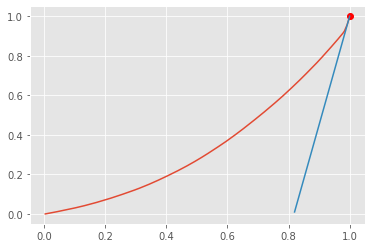

Loubar price:  45.97080269879258
Average price:  31.16853030204916
average city distance:  4620.5517793826875
eta =  0.8337988194080271
time: 2.08 s


In [19]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))



mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)
    
print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True

  
if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No") 
    
    
L1= L
F1 = np.arange(1, len(L1)+1)/len(L1)

L1 = (L1 - L1.min())/(L1.max()-L1.min())

from scipy import interpolate
tck = interpolate.splrep(F1,L1)
x0_1 =1
y0_1 = interpolate.splev(x0_1,tck)
dydx = interpolate.splev(x0_1,tck,der=1)
tngnt1 = lambda x: dydx*x + (y0_1-dydx*x0_1)
plt.plot(F1, L1)
plt.plot(x0_1,y0_1, "or")
plt.plot(F1[tngnt1(F1)>0],tngnt1(F1[tngnt1(F1)>0]), label="tangent")
plt.show()

indlist = poly_prices.index.tolist()

loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

print('Loubar price: ', loubar_val)
print('Average price: ', np.mean(vals_cut))

if loubar_val > np.mean(vals_cut):
    loubar_keys = keys[vals_cut>loubar_val]
else:
    loubar_keys = keys[vals_cut>np.mean(vals_cut)]
#loubar_keys = keys[vals_cut>loubar_val]
dist_mat = mat[keys.reshape(-1,1), keys]

total_dist = dist_mat.sum()
dist_corr = dist_mat[dist_mat>0]

loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]
loubar_dist = loubar_dist_mat.sum()

loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
eta_loubar = loubar_dist_corr.mean()/dist_corr.mean()

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

avg_dist_meters = (dist_corr.mean()/0.00899928)*1000
print('average city distance: ', avg_dist_meters)
print('eta = ', eta_loubar)

In [20]:
pickle_in = open("City_spreading_index.pickle","rb")
spreading_index_dict = pickle.load(pickle_in)
#spreading_index_dict = {}
spreading_index_dict['Buenos_Aires'] = eta_loubar


pickle_out = open("City_spreading_index.pickle","wb")
pickle.dump(spreading_index_dict, pickle_out)
pickle_out.close()

spreading_index_dict

{'Paris': 0.7251609142253275,
 'Amsterdam': 0.6513935879350918,
 'Stockholm': 0.6839327295656318,
 'Arezzo': 0.5574311537992848,
 'Berlin': 0.7499866909236614,
 'Bordeaux': 0.5818334466519048,
 'Denver': 0.6312111392217781,
 'Edinburgh': 0.6813298654934006,
 'Lyon': 0.6138305864151811,
 'Madrid': 0.6426066210787698,
 'Buenos_Aires': 0.8337988194080271,
 'Palermo': 0.8841435007903967,
 'Los_Angeles': 0.7889452782510832,
 'Beijing': 0.6425383574699105,
 'Florence': 0.5049117106731263,
 'Moscow': 0.6925493573699144,
 'Porto': 0.7058843952576399,
 'Prague': 0.5522963433539414,
 'Reykjavik': 0.8276260142343259,
 'Riga': 0.6850021296374689,
 'Rome': 0.5803964773671335,
 'Seoul': 0.8924742030382572,
 'Siena': 0.5646389917673048,
 'Sydney': 0.7909301400958108,
 'Tallin': 0.5690189423395199,
 'Treviso': 0.5345662066021125,
 'Valencia': 0.6956994914059091,
 'Venezia': 0.656650370883064,
 'Verona': 0.5707647012625697,
 'Vicenza': 0.5117751186840898,
 'Vienna': 0.6189242538490607,
 'Wellington': 0

time: 4.98 ms


In [21]:
pickle_in = open("avg_distances_dict.pickle","rb")
avg_distances_dict = pickle.load(pickle_in)
#avg_distances_dict = {}
avg_distances_dict['Buenos_Aires'] = avg_dist_meters


pickle_out = open("avg_distances_dict.pickle","wb")
pickle.dump(avg_distances_dict, pickle_out)
pickle_out.close()

avg_distances_dict

{'Venezia': 2398.636425932576,
 'Verona': 3141.8502884813342,
 'Vicenza': 1988.2224372858566,
 'Vienna': 5125.89366602888,
 'Wellington': 2806.4963410749997,
 'Zurich': 2068.4583585914684,
 'Aarhus': 2857.919349359045,
 'Milan': 6008.128043000454,
 'Busan': 7348.804402235624,
 'Valencia': 4090.433301180094,
 'Bologna': 2104.4589605649485,
 'Barcelona': 4218.232625020259,
 'Bremen': 3495.925661234734,
 'Brno': 2231.9772664038364,
 'Budapest': 3463.3335339061914,
 'Dublin': 4138.1465107736385,
 'Boston': 5610.60832524716,
 'Rio': 8357.334811118957,
 'NY': 8563.096975538809,
 'Ottawa': 2220.3476963993976,
 'Nashville': 5606.900406329212,
 'New_Orleans': 5048.047130029565,
 'Shanghai': 5452.583570486633,
 'Portland': 5406.388840795854,
 'Amsterdam': 7020.480387015727,
 'Arezzo': 1662.0178383704194,
 'Beijing': 6586.560663166117,
 'Berlin': 8495.253652229821,
 'Bordeaux': 3886.5511701192345,
 'Buenos_Aires': 4620.5517793826875}

time: 9 ms


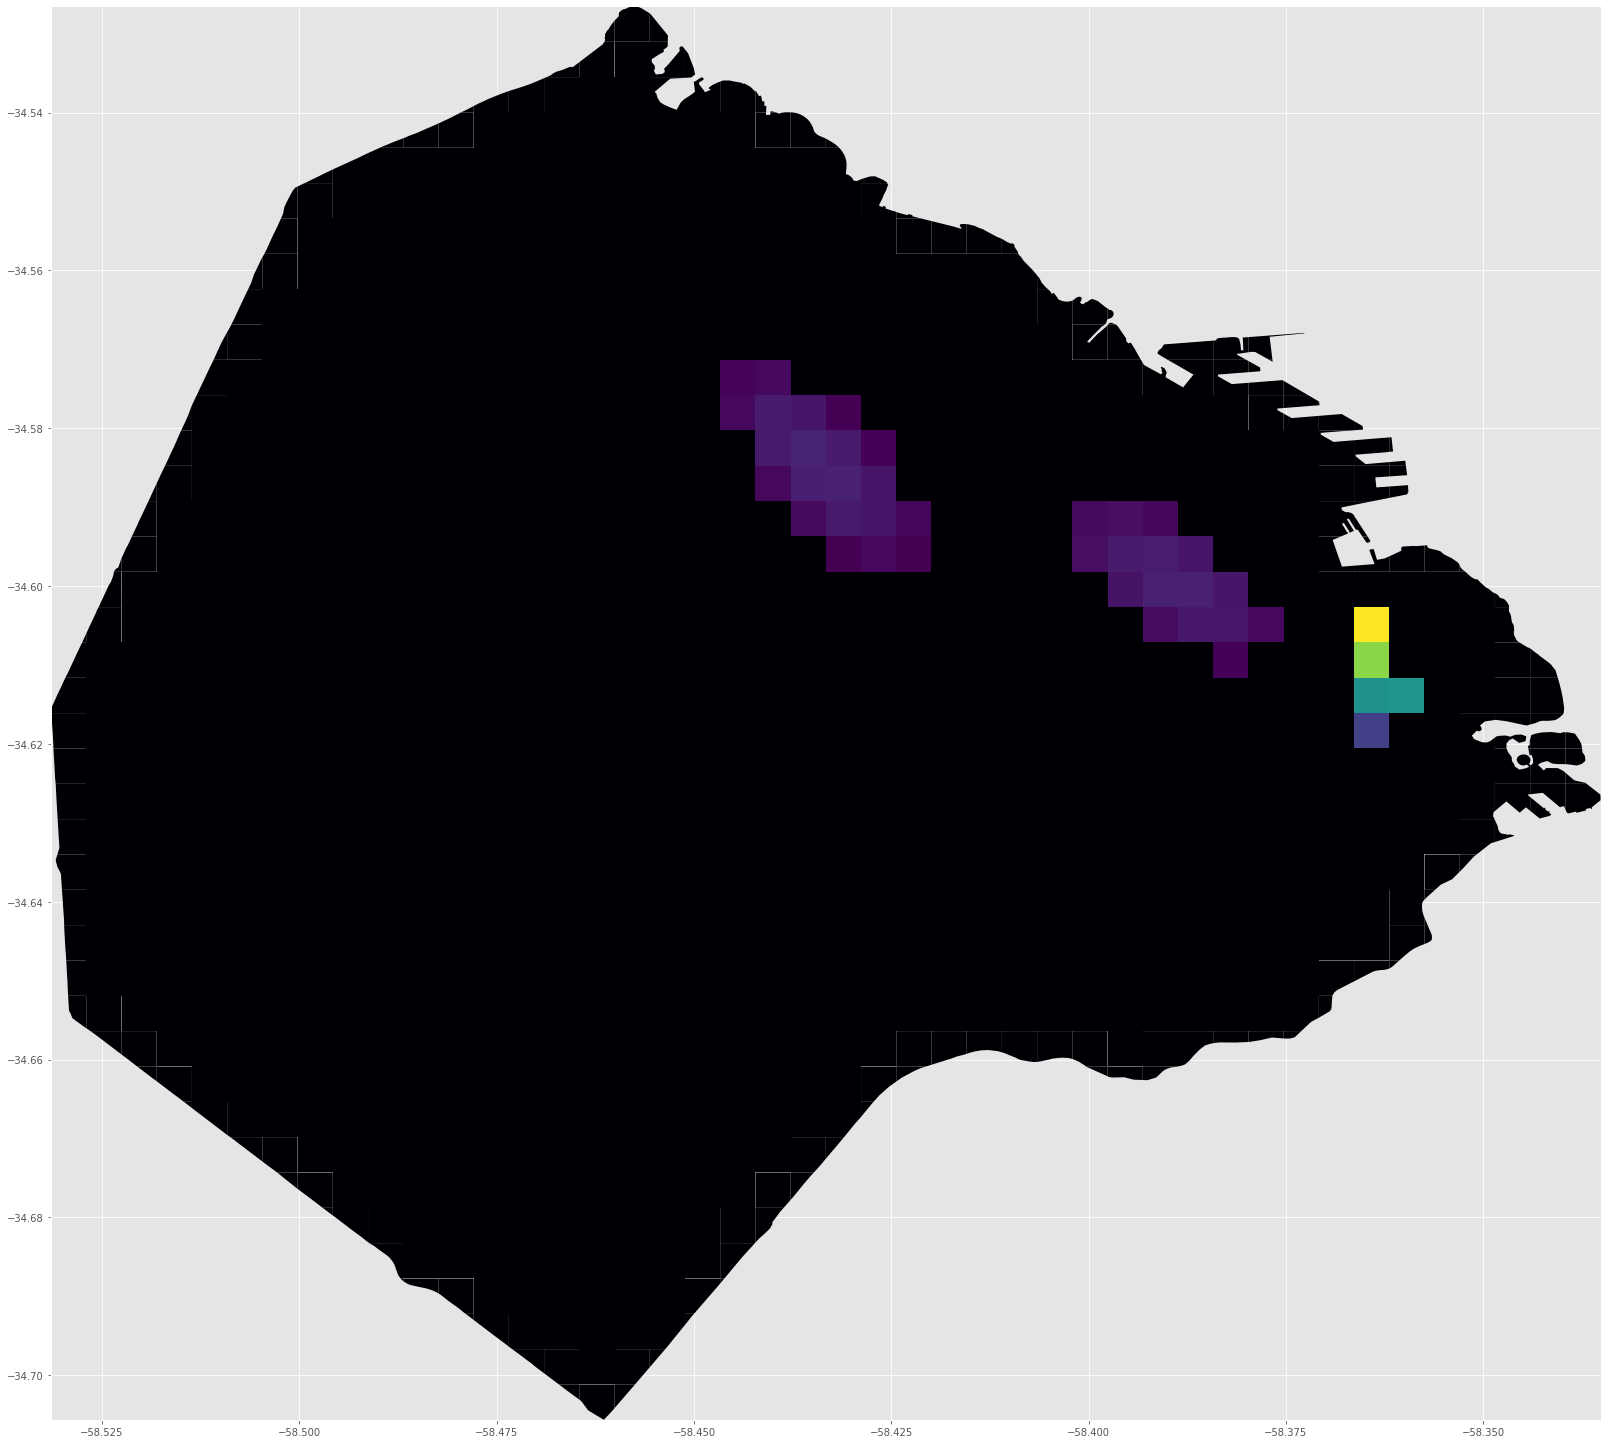

time: 916 ms


In [22]:
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe.plot(ax=ax, color='#000004')
#polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
poly_prices[poly_prices.index.isin(loubar_keys)].plot(ax=ax, column='zpred')
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [23]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    
print(len(keys))
vals = np.array(vals)
keys = np.array(keys)
keys = keys[vals>=0.01*vals.max()]
print(len(keys))

indlist = poly_prices.index.tolist()
mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)

print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True


if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No")

1085
399



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Yes
time: 4.73 s


1085


1085 399
Number of cells with price above 1.0th percentile:  399
Loubar price:  38.498001407690126
Average price:  19.948592299571885
eta =  0.611161822604228
1085 327
Number of cells with price above 2.0th percentile:  327
Loubar price:  41.121285397653786
Average price:  23.803802484410383
eta =  0.6787931579328619
1085 281
Number of cells with price above 3.0th percentile:  281
Loubar price:  43.72334070868864
Average price:  27.00875055538781
eta =  0.7395445568428975
1085 255
Number of cells with price above 4.0th percentile:  255
Loubar price:  44.95188339990622
Average price:  29.144100731383336
eta =  0.7829771782929674
1085 233
Number of cells with price above 5.0th percentile:  233
Loubar price:  45.97080269879258
Average price:  31.16853030204916
eta =  0.8337988194080271
1085 211
Number of cells with price above 6.000000000000001th percentile:  211
Loubar price:  46.745135292283
Average price:  33.41769709259321
eta =  0.884706959098924
1085 203
Number of cells with price a

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning:

Mean of empty slice.

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars



eta =  nan
1085 5
Number of cells with price above 34.0th percentile:  5
Loubar price:  172.1055051006918
Average price:  122.93375606746254
eta =  nan
1085 5
Number of cells with price above 35.0th percentile:  5
Loubar price:  172.1055051006918
Average price:  122.93375606746254
eta =  nan
1085 5
Number of cells with price above 36.00000000000001th percentile:  5
Loubar price:  172.1055051006918
Average price:  122.93375606746254
eta =  nan
1085 5
Number of cells with price above 37.0th percentile:  5
Loubar price:  172.1055051006918
Average price:  122.93375606746254
eta =  nan
1085 5
Number of cells with price above 38.0th percentile:  5
Loubar price:  172.1055051006918
Average price:  122.93375606746254
eta =  nan
1085 5
Number of cells with price above 39.0th percentile:  5
Loubar price:  172.1055051006918
Average price:  122.93375606746254
eta =  nan
1085 5
Number of cells with price above 40.0th percentile:  5
Loubar price:  172.1055051006918
Average price:  122.93375606746254


C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning:

invalid value encountered in true_divide



Loubar price:  172.1055051006918
Average price:  172.1055051006918
eta =  nan
1085 1
Number of cells with price above 89.0th percentile:  1
Loubar price:  172.1055051006918
Average price:  172.1055051006918
eta =  nan
1085 1
Number of cells with price above 90.0th percentile:  1
Loubar price:  172.1055051006918
Average price:  172.1055051006918
eta =  nan
1085 1
Number of cells with price above 91.0th percentile:  1
Loubar price:  172.1055051006918
Average price:  172.1055051006918
eta =  nan
1085 1
Number of cells with price above 92.0th percentile:  1
Loubar price:  172.1055051006918
Average price:  172.1055051006918
eta =  nan
1085 1
Number of cells with price above 93.0th percentile:  1
Loubar price:  172.1055051006918
Average price:  172.1055051006918
eta =  nan
1085 1
Number of cells with price above 94.0th percentile:  1
Loubar price:  172.1055051006918
Average price:  172.1055051006918
eta =  nan
1085 1
Number of cells with price above 95.0th percentile:  1
Loubar price:  172.1

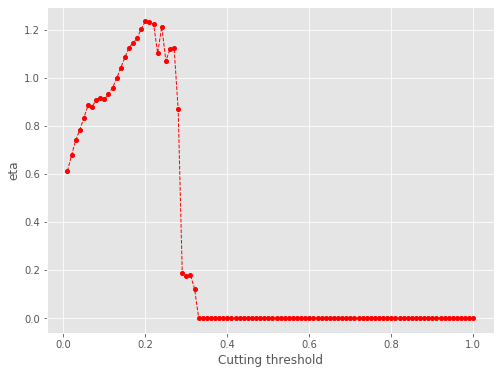

time: 1.77 s


In [24]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_cut = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    
    
        
    L1= L
    F1 = np.arange(1, len(L1)+1)/len(L1)

    L1 = (L1 - L1.min())/(L1.max()-L1.min())
    

    loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

    print('Loubar price: ', loubar_val)
    print('Average price: ', np.mean(vals_cut))
    
    
    loubar_keys = keys[vals_cut>loubar_val]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas_cut.append(eta)
    print('eta = ', eta)
etas_cut = np.array(etas_cut)
etas_cut = np.where(np.isnan(etas_cut), 0, etas_cut)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(perc_vals, etas_cut, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Cutting threshold")
plt.ylabel("eta")
plt.show()

In [25]:
pickle_in = open("etas_cut_dict.pickle","rb")
etas_cut_dict = pickle.load(pickle_in)
#etas_cut_dict = {}
etas_cut_dict['Buenos_Aires'] = etas_cut


pickle_out = open("etas_cut_dict.pickle","wb")
pickle.dump(etas_cut_dict, pickle_out)
pickle_out.close()

etas_cut_dict

{'Boston': array([0.69697859, 0.70601119, 0.71142664, 0.72735905, 0.71723297,
        0.69152614, 0.68969459, 0.69338651, 0.68627389, 0.68571239,
        0.68565242, 0.66080855, 0.68568495, 0.66662135, 0.65169235,
        0.66853925, 0.64080339, 0.6392735 , 0.64870117, 0.66369008,
        0.64936606, 0.65513408, 0.65817401, 0.54708479, 0.54484174,
        0.5177247 , 0.54225619, 0.54660686, 0.55128317, 0.55836993,
        0.56571414, 0.52792612, 0.52759205, 0.55096732, 0.46941853,
        0.48021089, 0.47484233, 0.46129546, 0.46439344, 0.4699713 ,
        0.50255475, 0.51573036, 0.52765377, 0.52765377, 0.53943229,
        0.54404083, 0.54813213, 0.6100999 , 0.50092562, 0.52536404,
        0.56707558, 0.56150998, 0.61316219, 0.66467806, 0.74541769,
        0.74541769, 0.77652679, 0.74895419, 0.92876367, 0.92876367,
        0.90963119, 0.90963119, 1.05344906, 1.15130075, 1.15130075,
        1.22651104, 1.26738008, 0.62257449, 0.62257449, 0.64231201,
        0.64231201, 0.62403947, 0.6307

time: 26 ms


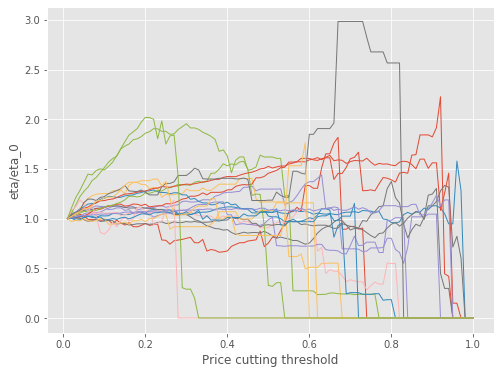

time: 228 ms


In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
for key in etas_cut_dict:
    #print(len(etas_cut_dict[key]))
    etas = etas_cut_dict[key]#[1:]
    vals = etas/etas[0]
    plt.plot(np.linspace(0.01, 1, 100), vals, linestyle='-', linewidth=1)
plt.xlabel("Price cutting threshold")
plt.ylabel("eta/eta_0")
plt.show()

1085 233
Number of cells with price above 5th percentile:  233


eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  0.9984601458287337
eta =  0.9618130828474485
eta =  0.95182907254738
eta =  0.9325271407170194
eta =  0.9134165343906581
eta =  0.8989772741558838
eta =  0.8800392082036463
eta =  0.8673541615484159
eta =  0.8489366745773663
eta =  0.8435155128601711
eta =  0.8329204299731067
eta =  0.8195331516001763
eta =  0.8119711566541881
eta =  0.8138336699036333
eta =  0.7940165478068512
eta =  0.8007980944329923
eta =  0.7911727754222607
eta =  0.7853939781587014
eta =  0.8092743487527713
eta =  0.797897047546267
eta =  0.8171907879789782
eta =  0.8296273899211939
eta =  0.8509227277475276
eta =  0.8210253541012825
eta =  0.863045407490321
eta =  0.878613424371908
eta =  0.9564887511974385
eta =  0.9195457395494353
eta =  0.9118371288047799
eta =  0.17286328799474207
eta =  0.17286328799474207
eta =  0.17286328799474207
eta =  0.17286328799474207
eta =  0.17286328799474207
eta =  0.17286328799474207
eta =  0.17286328799474207
eta =  

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning:

Mean of empty slice.



eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan



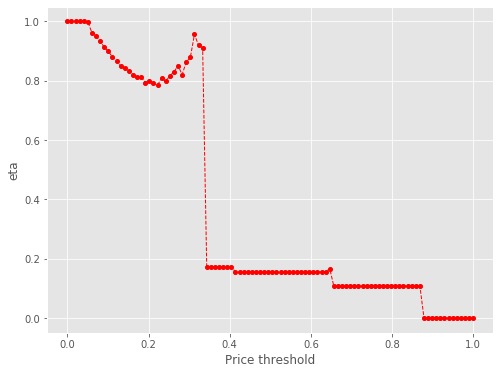

time: 636 ms


In [27]:
lval = np.linspace(0, max(vals_cut), 100)
etas = []

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)
vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

for i in tqdm_notebook(lval):
    loubar_keys = keys[vals_cut>=i]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas.append(eta)
    print('eta = ', eta)
etas = np.array(etas)
etas = np.where(np.isnan(etas), 0, etas)
lval = lval/lval.max()
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(lval, etas, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

etas_cut_threshold = etas

In [28]:
pickle_in = open("etas_cut_threshold_dict.pickle","rb")
etas_cut_threshold_dict = pickle.load(pickle_in)
#etas_cut_threshold_dict = {}
etas_cut_threshold_dict['Buenos_Aires'] = etas_cut_threshold


pickle_out = open("etas_cut_threshold_dict.pickle","wb")
pickle.dump(etas_cut_threshold_dict, pickle_out)
pickle_out.close()

etas_cut_threshold_dict

{'NY': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        0.99991145, 0.98955316, 0.97868522, 0.96344498, 0.95205618,
        0.94615067, 0.93194961, 0.92540239, 0.92150344, 0.91822455,
        0.91569734, 0.91218202, 0.90337978, 0.898264  , 0.89376519,
        0.89441924, 0.88573077, 0.88617046, 0.87902683, 0.87195329,
        0.87101443, 0.87158631, 0.86935351, 0.86321974, 0.86053312,
        0.86079304, 0.86069179, 0.86140605, 0.85888874, 0.8617884 ,
        0.85709178, 0.8579834 , 0.85179248, 0.84947743, 0.84847717,
        0.84228408, 0.82983947, 0.82767187, 0.82334824, 0.81678545,
        0.81788964, 0.81304395, 0.807866  , 0.79902867, 0.79698224,
        0.78820712, 0.76853775, 0.76312442, 0.75071909, 0.7481045 ,
        0.73389742, 0.71700231, 0.70245218, 0.68328343, 0.67990807,
        0.66811743, 0.61552082, 0.58620924, 0.57826542, 0.57372339,
        0.55441141, 0.5326264 , 0.53706259, 0.53126932, 0.52772792,
        0.5331439 , 0.51700595, 0.49034259

time: 28 ms


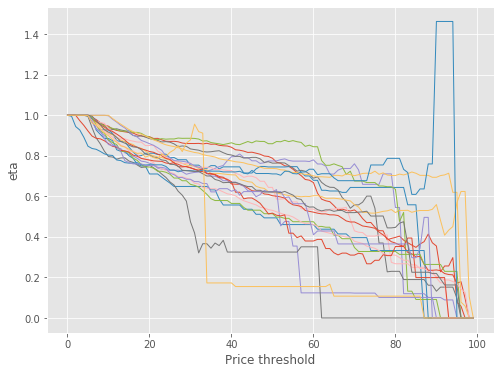

time: 215 ms


In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
for key in etas_cut_threshold_dict:
    plt.plot(np.arange(100), etas_cut_threshold_dict[key], linestyle='-', linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

1085 399
Number of cells with price above 1.0th percentile:  399


eta =  1.0
eta =  0.9174758758240162
eta =  0.8464747601388734
eta =  0.8076828799374125
eta =  0.7698790154301315
eta =  0.7404797092504131
eta =  0.7336623152059829
eta =  0.7179330769570945
eta =  0.7015860220842088
eta =  0.6940662553290342
eta =  0.6808276127894947
eta =  0.6690423957940963
eta =  0.6535785311861527
eta =  0.6494048925408309
eta =  0.6412479605593372
eta =  0.6298738311147014
eta =  0.629157646192833
eta =  0.6252498201642684
eta =  0.6112966780607705
eta =  0.6105512747890541
eta =  0.6162434304812728
eta =  0.6081158867165487
eta =  0.6170684789539322
eta =  0.6101220244323138
eta =  0.6291380392678291
eta =  0.6268016282383717
eta =  0.6514826839139347
eta =  0.6581703080380932
eta =  0.6517037806376549
eta =  0.6764260380991409
eta =  0.72109252179039
eta =  0.6802582663489406
eta =  0.6727413858034264
eta =  0.13308381796540728
eta =  0.13308381796540728
eta =  0.13308381796540728
eta =  0.13308381796540728
eta =  0.13308381796540728
eta =  0.1330838179654072

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning:

Mean of empty slice.



eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan


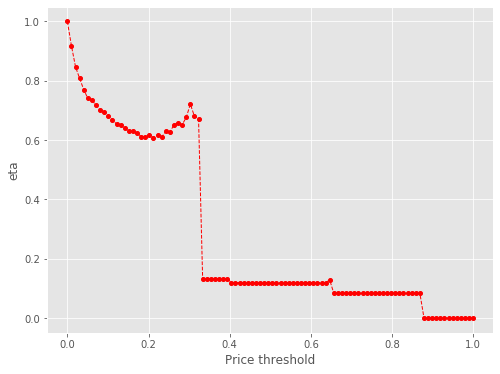

1085 327
Number of cells with price above 2.0th percentile:  327


eta =  1.0
eta =  0.9226125530315722
eta =  0.8803314628975994
eta =  0.8428340310572662
eta =  0.8069681013445544
eta =  0.7996529767576241
eta =  0.7825089420605141
eta =  0.7656239914262628
eta =  0.7569684027737574
eta =  0.7420659558792435
eta =  0.7292206949781722
eta =  0.7176011990591531
eta =  0.7090689044389469
eta =  0.6989262360532484
eta =  0.6948105917996764
eta =  0.6836399373540708
eta =  0.6787501136004264
eta =  0.6727219805160531
eta =  0.6684572667223906
eta =  0.6716726256456647
eta =  0.6595305076654349
eta =  0.6676346594490202
eta =  0.6734537103276851
eta =  0.6815004293747813
eta =  0.6897238126237705
eta =  0.7028987942407219
eta =  0.7035103447863401
eta =  0.6985954206910605
eta =  0.7372684731264674
eta =  0.7725763484910525
eta =  0.7718167010827003
eta =  0.7716158945012775
eta =  0.6227633858604014
eta =  0.1450542967638034
eta =  0.1450542967638034
eta =  0.1450542967638034
eta =  0.1450542967638034
eta =  0.1450542967638034
eta =  0.1450542967638034
e

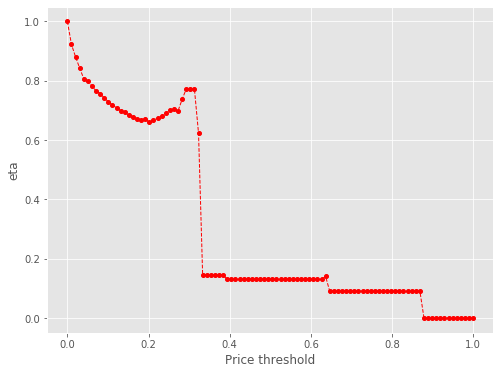

1085 281
Number of cells with price above 3.0th percentile:  281


eta =  1.0
eta =  0.9541724313255406
eta =  0.9135297674932287
eta =  0.8738795514478799
eta =  0.8667267469210986
eta =  0.8481446946383964
eta =  0.8298434580263757
eta =  0.8188424735495627
eta =  0.8043094074982196
eta =  0.7893414852898107
eta =  0.7817857405076495
eta =  0.7680712221306824
eta =  0.7575511884774138
eta =  0.7530903297561136
eta =  0.7409826964826441
eta =  0.7425033326266858
eta =  0.7370327822895888
eta =  0.7245265247323333
eta =  0.7280115834524958
eta =  0.7237791820650132
eta =  0.7192926158643532
eta =  0.733022536891172
eta =  0.7386637295747481
eta =  0.7406261030561776
eta =  0.7621274140957618
eta =  0.7742026625166141
eta =  0.7498154901735401
eta =  0.7991095186206921
eta =  0.8150835694821025
eta =  0.8901331946536916
eta =  0.8363379535275763
eta =  0.8659514425169264
eta =  0.15722124773522303
eta =  0.15722124773522303
eta =  0.15722124773522303
eta =  0.15722124773522303
eta =  0.15722124773522303
eta =  0.15722124773522303
eta =  0.1572212477352

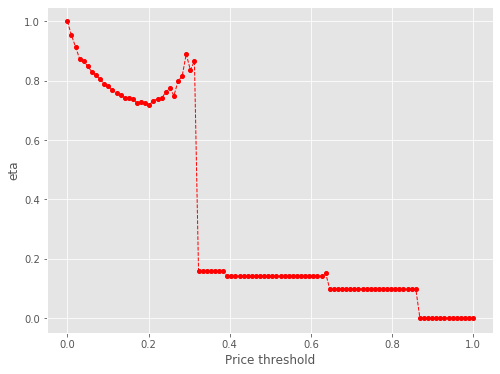

1085 255
Number of cells with price above 4.0th percentile:  255


eta =  1.0
eta =  0.9531946690386572
eta =  0.9158507652897522
eta =  0.908354421555691
eta =  0.8888798992653246
eta =  0.8696996798299375
eta =  0.8581703334396521
eta =  0.8429392645319561
eta =  0.8272524539335663
eta =  0.8193338172866609
eta =  0.8049606097544386
eta =  0.7939353135837516
eta =  0.7892602060509305
eta =  0.7763978728860867
eta =  0.778164730241888
eta =  0.77447588025694
eta =  0.759324521382176
eta =  0.7615196039001004
eta =  0.7541416718210177
eta =  0.7618635068552017
eta =  0.7652400247815503
eta =  0.7683142846289653
eta =  0.7789419026890616
eta =  0.7987313289244912
eta =  0.81138653465505
eta =  0.7825969906749184
eta =  0.8068807657383495
eta =  0.8374896322571023
eta =  0.8927916385280663
eta =  0.8765060968757313
eta =  0.8691582902082315
eta =  0.16477236458908226
eta =  0.16477236458908226
eta =  0.16477236458908226
eta =  0.16477236458908226
eta =  0.16477236458908226
eta =  0.16477236458908226
eta =  0.16477236458908226
eta =  0.1478404826545947
e

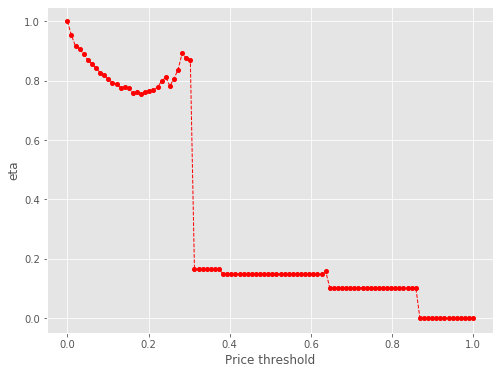

1085 233
Number of cells with price above 5.0th percentile:  233


eta =  1.0
eta =  0.9616754719954169
eta =  0.9529579330020909
eta =  0.9355881937872454
eta =  0.9124051026293207
eta =  0.9004051702839481
eta =  0.8843306534457447
eta =  0.867873563296247
eta =  0.8580061493334898
eta =  0.8508113966165287
eta =  0.8314645587978204
eta =  0.8280157576279119
eta =  0.8145218370441805
eta =  0.816375453533227
eta =  0.8151048449146251
eta =  0.7966101217792073
eta =  0.8015742586558944
eta =  0.7911727754222607
eta =  0.7853939781587014
eta =  0.8092743487527713
eta =  0.797897047546267
eta =  0.8171907879789782
eta =  0.8214242103164904
eta =  0.846214367266461
eta =  0.8549009582633882
eta =  0.8465015509918112
eta =  0.878613424371908
eta =  0.9351488431540587
eta =  0.883591126287395
eta =  0.9607030257239583
eta =  0.17286328799474207
eta =  0.17286328799474207
eta =  0.17286328799474207
eta =  0.17286328799474207
eta =  0.17286328799474207
eta =  0.17286328799474207
eta =  0.17286328799474207
eta =  0.17286328799474207
eta =  0.1550999889704575

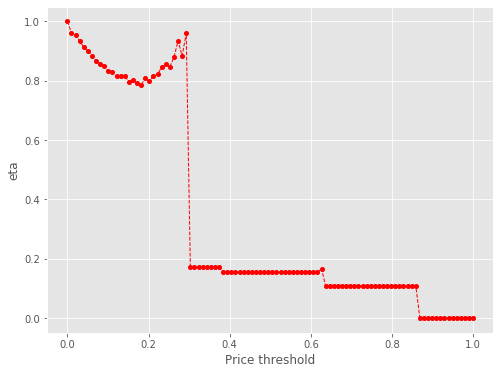

1085 211
Number of cells with price above 6.000000000000001th percentile:  211


eta =  1.0
eta =  0.9896195939958409
eta =  0.9695513165159616
eta =  0.948317089779936
eta =  0.9373197491550941
eta =  0.9194412814885851
eta =  0.9023307945935883
eta =  0.8936934920824569
eta =  0.8780158259579993
eta =  0.8659899151166098
eta =  0.8608905122984712
eta =  0.8468608418517117
eta =  0.8487880525770629
eta =  0.8474669969153533
eta =  0.8282379767811459
eta =  0.8333992050543054
eta =  0.8225847511659885
eta =  0.8165765180002977
eta =  0.8414050122471965
eta =  0.8239550885870184
eta =  0.8496357582906693
eta =  0.8464804915085147
eta =  0.8798116623255349
eta =  0.8888431375173783
eta =  0.8655800252703821
eta =  0.913497060957803
eta =  0.9722771085474838
eta =  0.9563033192608151
eta =  0.9560545140716108
eta =  0.7716219306695105
eta =  0.1797264885220527
eta =  0.1797264885220527
eta =  0.1797264885220527
eta =  0.1797264885220527
eta =  0.1797264885220527
eta =  0.1797264885220527
eta =  0.1797264885220527
eta =  0.1612579322702535
eta =  0.1612579322702535
eta

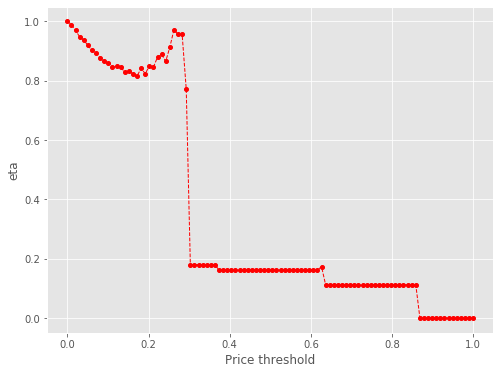

1085 203
Number of cells with price above 6.999999999999999th percentile:  203


eta =  1.0
eta =  0.9785606566905753
eta =  0.9574453090022378
eta =  0.9447527452664444
eta =  0.9279849852971467
eta =  0.910715503004625
eta =  0.9003609914138857
eta =  0.8907025142018457
eta =  0.8753800992204445
eta =  0.8682870254423666
eta =  0.8627123200724349
eta =  0.8539120787658766
eta =  0.8520864262692155
eta =  0.8362986797945109
eta =  0.8363376550093629
eta =  0.8302284371880293
eta =  0.8292341903180868
eta =  0.8410796986085951
eta =  0.8429913109823459
eta =  0.8522452228441398
eta =  0.8625289127546468
eta =  0.8790047866648176
eta =  0.8797695565880135
eta =  0.8586217705566339
eta =  0.921985529417887
eta =  0.9404158489138014
eta =  1.027005567574487
eta =  0.9649384382084971
eta =  0.9568492975678698
eta =  0.18139655698145363
eta =  0.18139655698145363
eta =  0.18139655698145363
eta =  0.18139655698145363
eta =  0.18139655698145363
eta =  0.18139655698145363
eta =  0.18139655698145363
eta =  0.16275638577439416
eta =  0.16275638577439416
eta =  0.162756385774

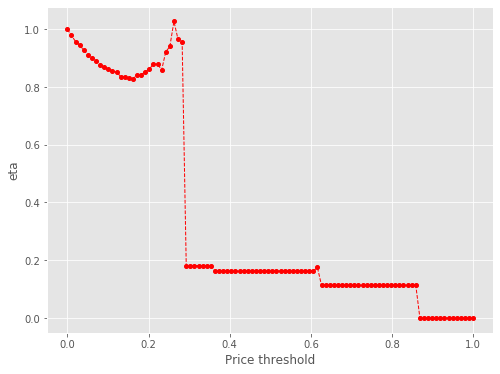

1085 193
Number of cells with price above 8.0th percentile:  193


eta =  1.0
eta =  0.9795066486626147
eta =  0.966756202779766
eta =  0.9483162632304551
eta =  0.9306684228288945
eta =  0.9217598665059871
eta =  0.9123717256768962
eta =  0.8910115258078545
eta =  0.887926711700049
eta =  0.8816135353224486
eta =  0.8754441751749087
eta =  0.8707548381833714
eta =  0.8546211970373052
eta =  0.8587397186287353
eta =  0.8484179611265025
eta =  0.8474019312430766
eta =  0.859506963475385
eta =  0.8674573815673642
eta =  0.8709171138418486
eta =  0.8814261097228864
eta =  0.8985818326915223
eta =  0.8990444798417846
eta =  0.8840655314046637
eta =  0.9421853649174682
eta =  0.9610194753733744
eta =  1.0256953491584118
eta =  0.986079331527442
eta =  0.9778129654260453
eta =  0.18537078487799039
eta =  0.18537078487799039
eta =  0.18537078487799039
eta =  0.18537078487799039
eta =  0.18537078487799039
eta =  0.18537078487799039
eta =  0.18537078487799039
eta =  0.1663222250573869
eta =  0.1663222250573869
eta =  0.1663222250573869
eta =  0.166322225057386

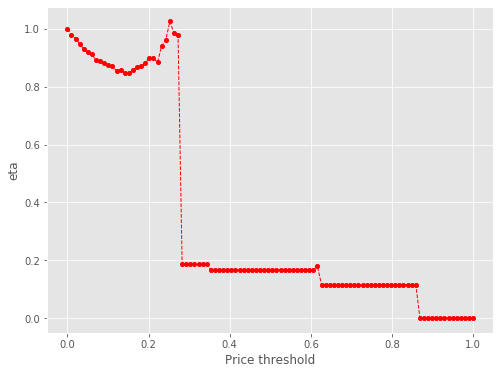

1085 181
Number of cells with price above 9.0th percentile:  181


eta =  1.0
eta =  0.987946544787624
eta =  0.9704121680858936
eta =  0.9523531304735116
eta =  0.9415252138569271
eta =  0.9314251540927675
eta =  0.9154022030989515
eta =  0.9079848362100101
eta =  0.9021552570571285
eta =  0.8929526714751627
eta =  0.8885387781632128
eta =  0.8713068088853668
eta =  0.8702443543206336
eta =  0.8783576227054697
eta =  0.8624791702027019
eta =  0.8730771061954508
eta =  0.8745654590126652
eta =  0.8912096074229124
eta =  0.8935772424237656
eta =  0.9195189181869677
eta =  0.9340878985955189
eta =  0.9009446758658527
eta =  0.928900747910615
eta =  0.9641384189634723
eta =  1.0278034326399963
eta =  0.9696006547110081
eta =  0.9588865294164594
eta =  0.1896899507348419
eta =  0.1896899507348419
eta =  0.1896899507348419
eta =  0.1896899507348419
eta =  0.1896899507348419
eta =  0.1896899507348419
eta =  0.1896899507348419
eta =  0.1896899507348419
eta =  0.1701975567401883
eta =  0.1701975567401883
eta =  0.1701975567401883
eta =  0.1701975567401883
eta

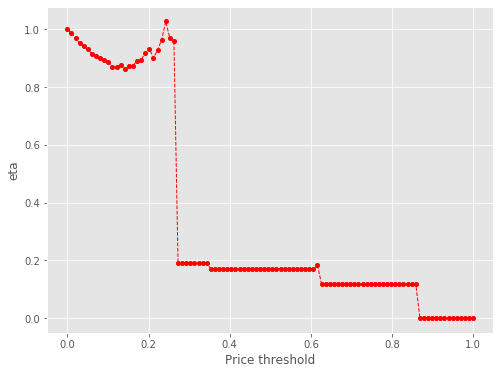

1085 166
Number of cells with price above 10.0th percentile:  166


eta =  1.0
eta =  0.980925967171155
eta =  0.9626712713638594
eta =  0.9534563769599838
eta =  0.9443009176382883
eta =  0.9222853163907979
eta =  0.9184598031509347
eta =  0.9119295358928112
eta =  0.9026272461448677
eta =  0.9006974412780009
eta =  0.8807468643911734
eta =  0.8840502121475837
eta =  0.8878740692977961
eta =  0.8718235838538831
eta =  0.8825363417474805
eta =  0.8840408199215308
eta =  0.9008652971014345
eta =  0.9019395433204458
eta =  0.9294813212553297
eta =  0.9442081473071344
eta =  0.9342023391442723
eta =  0.9389647971413094
eta =  0.9745842459643413
eta =  1.0372950206414624
eta =  0.9801056615646186
eta =  1.065640483003279
eta =  0.8232216715427743
eta =  0.1917451207915541
eta =  0.1917451207915541
eta =  0.1917451207915541
eta =  0.1917451207915541
eta =  0.1917451207915541
eta =  0.1917451207915541
eta =  0.1917451207915541
eta =  0.17204153909657022
eta =  0.17204153909657022
eta =  0.17204153909657022
eta =  0.17204153909657022
eta =  0.1720415390965702

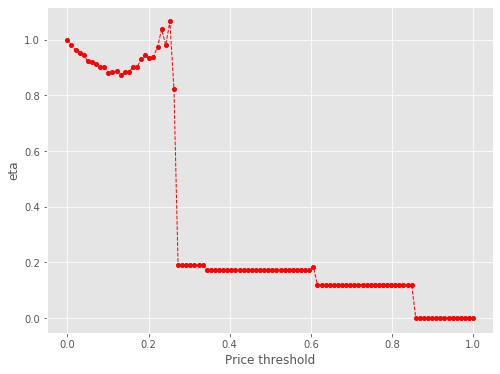

1085 161
Number of cells with price above 11.0th percentile:  161


eta =  1.0
eta =  0.9826898663126898
eta =  0.971996265640322
eta =  0.9549449689016383
eta =  0.9418653834147659
eta =  0.9363191860438118
eta =  0.929661938222189
eta =  0.9201787661386014
eta =  0.9156302933791799
eta =  0.8978729219811734
eta =  0.8967780732151807
eta =  0.9051387148596883
eta =  0.888776128914288
eta =  0.8942983995446373
eta =  0.9113688464383586
eta =  0.9114705138994488
eta =  0.9194776909836587
eta =  0.9475550167519939
eta =  0.9622223592860375
eta =  0.9667209373918169
eta =  0.9572228981246613
eta =  0.9935349644936996
eta =  1.0574651455429074
eta =  1.0400917802086829
eta =  1.039821175446624
eta =  0.8392291560155385
eta =  0.19547359047341623
eta =  0.19547359047341623
eta =  0.19547359047341623
eta =  0.19547359047341623
eta =  0.19547359047341623
eta =  0.19547359047341623
eta =  0.19547359047341623
eta =  0.17538687409072523
eta =  0.17538687409072523
eta =  0.17538687409072523
eta =  0.17538687409072523
eta =  0.17538687409072523
eta =  0.1753868740

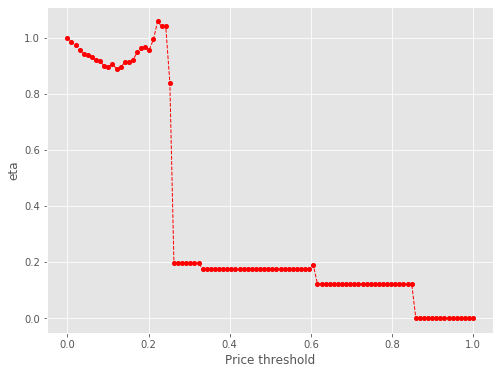

1085 153
Number of cells with price above 12.0th percentile:  153


eta =  1.0
eta =  0.9768865699615503
eta =  0.9731642015294195
eta =  0.9584563916883481
eta =  0.9528124977589593
eta =  0.9372848027151123
eta =  0.9394177922633732
eta =  0.9343857791108625
eta =  0.9136890007324774
eta =  0.917115901959895
eta =  0.9210827809347483
eta =  0.9044319671772023
eta =  0.9100515128951918
eta =  0.9171061584410886
eta =  0.9275261149476641
eta =  0.9356743388774122
eta =  0.9642462482161019
eta =  0.9791719567604255
eta =  0.9837497775561759
eta =  0.9580027356628593
eta =  1.0110361351559505
eta =  1.0594547766011744
eta =  1.1351073572098367
eta =  1.0581376801495936
eta =  1.0956047691513044
eta =  0.19891686805205838
eta =  0.19891686805205838
eta =  0.19891686805205838
eta =  0.19891686805205838
eta =  0.19891686805205838
eta =  0.19891686805205838
eta =  0.19891686805205838
eta =  0.19891686805205838
eta =  0.1784763231036693
eta =  0.1784763231036693
eta =  0.1784763231036693
eta =  0.1784763231036693
eta =  0.1784763231036693
eta =  0.17847632310

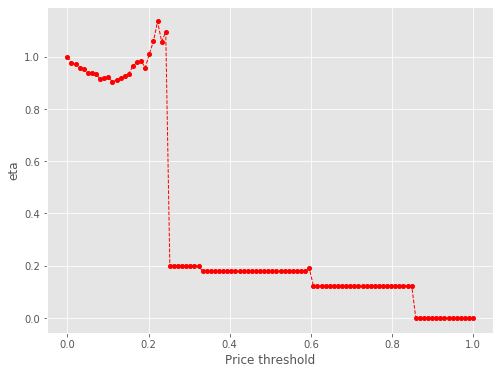

1085 144
Number of cells with price above 13.0th percentile:  144


eta =  1.0
eta =  0.9936141742022229
eta =  0.981133758166081
eta =  0.9753563280089534
eta =  0.9596752652414704
eta =  0.9616446997529591
eta =  0.9601479937480801
eta =  0.9383622425969413
eta =  0.9388151400177323
eta =  0.9352471928939594
eta =  0.9304404255949231
eta =  0.9372074887416932
eta =  0.9388051659643404
eta =  0.9566718817711339
eta =  0.9578126751340638
eta =  0.9870606044405483
eta =  1.0023394597378539
eta =  1.0070255931503855
eta =  0.9806693685025947
eta =  1.0349575541771898
eta =  1.0845217952406427
eta =  1.1528458272163276
eta =  1.0831735358909083
eta =  1.0740932228646238
eta =  0.203623300973303
eta =  0.203623300973303
eta =  0.203623300973303
eta =  0.203623300973303
eta =  0.203623300973303
eta =  0.203623300973303
eta =  0.203623300973303
eta =  0.203623300973303
eta =  0.1826991265840557
eta =  0.1826991265840557
eta =  0.1826991265840557
eta =  0.1826991265840557
eta =  0.1826991265840557
eta =  0.1826991265840557
eta =  0.1826991265840557
eta =  0.1

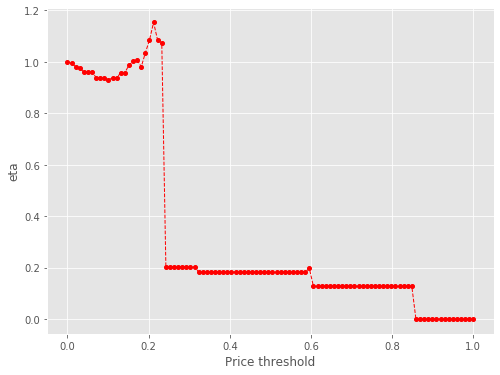

1085 132
Number of cells with price above 14.000000000000002th percentile:  132


eta =  1.0
eta =  0.9874393739942745
eta =  0.969924677731156
eta =  0.965842970197157
eta =  0.9678250620016243
eta =  0.9553723802721743
eta =  0.9443929715982127
eta =  0.9502780286019122
eta =  0.9379469178220232
eta =  0.9368236718026803
eta =  0.9502060825868116
eta =  0.9514519213003582
eta =  0.9628202843817621
eta =  0.9639684094715091
eta =  0.9934043113193948
eta =  1.0087813617822396
eta =  1.0134976123493113
eta =  0.986971999760348
eta =  1.0416090883648694
eta =  1.091491872196177
eta =  1.1602550136142658
eta =  1.0901349477633941
eta =  1.080996276776162
eta =  0.2049319607752104
eta =  0.2049319607752104
eta =  0.2049319607752104
eta =  0.2049319607752104
eta =  0.2049319607752104
eta =  0.2049319607752104
eta =  0.2049319607752104
eta =  0.2049319607752104
eta =  0.18387330950743094
eta =  0.18387330950743094
eta =  0.18387330950743094
eta =  0.18387330950743094
eta =  0.18387330950743094
eta =  0.18387330950743094
eta =  0.18387330950743094
eta =  0.1838733095074309

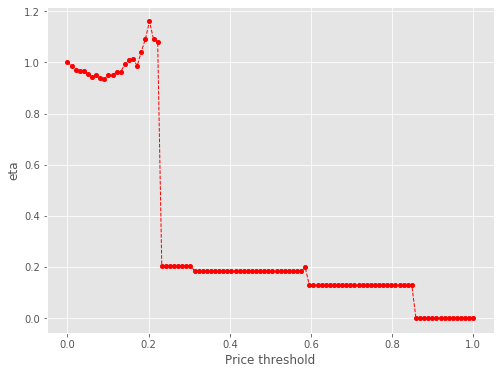

1085 126
Number of cells with price above 15.000000000000002th percentile:  126


eta =  1.0
eta =  0.9839273021873617
eta =  0.973725684159123
eta =  0.9711326869531266
eta =  0.9729148254270916
eta =  0.9564060300513078
eta =  0.9623659473471861
eta =  0.9498779798783492
eta =  0.9487404457178475
eta =  0.962293086149835
eta =  0.9635547724329201
eta =  0.97506774566531
eta =  0.9776581626711542
eta =  1.0060408137271168
eta =  1.0216134664568166
eta =  1.0263897096280747
eta =  1.0163054242998255
eta =  1.0548587749255673
eta =  1.1053760878310954
eta =  1.1750139240659785
eta =  1.1040019027737444
eta =  1.0947469842157926
eta =  0.20753877774413992
eta =  0.20753877774413992
eta =  0.20753877774413992
eta =  0.20753877774413992
eta =  0.20753877774413992
eta =  0.20753877774413992
eta =  0.20753877774413992
eta =  0.20753877774413992
eta =  0.18621225196200966
eta =  0.18621225196200966
eta =  0.18621225196200966
eta =  0.18621225196200966
eta =  0.18621225196200966
eta =  0.18621225196200966
eta =  0.18621225196200966
eta =  0.18621225196200966
eta =  0.186212

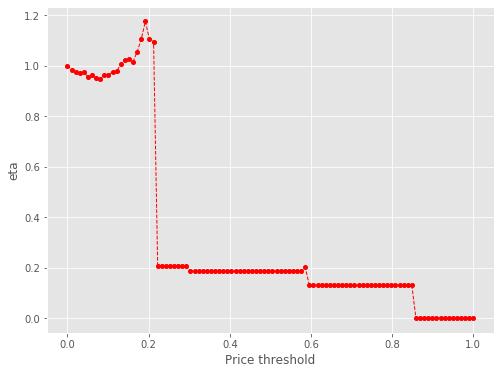

1085 119
Number of cells with price above 16.0th percentile:  119


eta =  1.0
eta =  0.9957917273086123
eta =  0.9978352796070278
eta =  0.9849964664338448
eta =  0.9736766094119111
eta =  0.9797441496434537
eta =  0.9670306770790336
eta =  0.9654566623927728
eta =  0.9724783974981713
eta =  0.9741362017772273
eta =  0.985204120971286
eta =  0.9988318424888835
eta =  1.0140327897033834
eta =  1.034306636872009
eta =  1.0339569704205764
eta =  1.0175759235954993
eta =  1.0739071932898927
eta =  1.095374398630729
eta =  1.1690922557279306
eta =  1.123937737426615
eta =  1.0680573673188825
eta =  0.21128646943449922
eta =  0.21128646943449922
eta =  0.21128646943449922
eta =  0.21128646943449922
eta =  0.21128646943449922
eta =  0.21128646943449922
eta =  0.21128646943449922
eta =  0.21128646943449922
eta =  0.18957483372579678
eta =  0.18957483372579678
eta =  0.18957483372579678
eta =  0.18957483372579678
eta =  0.18957483372579678
eta =  0.18957483372579678
eta =  0.18957483372579678
eta =  0.18957483372579678
eta =  0.18957483372579678
eta =  0.18957

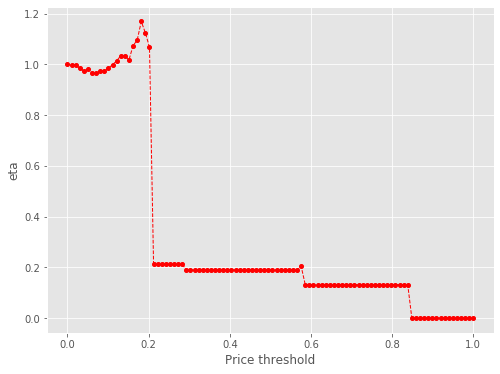

1085 114
Number of cells with price above 17.0th percentile:  114


eta =  1.0
eta =  0.989794622555277
eta =  0.9916110077947788
eta =  0.9747849683592378
eta =  0.9808594154142973
eta =  0.968131470805533
eta =  0.9665556643813955
eta =  0.9735853924927413
eta =  0.975245083889335
eta =  0.993805299989046
eta =  0.9999688362286898
eta =  1.0151870870383366
eta =  1.0354840124032432
eta =  1.0351339479182782
eta =  1.0187342541629578
eta =  1.075129647064355
eta =  1.0966212890291007
eta =  1.170423060894
eta =  1.1252171421442319
eta =  1.0692731620990825
eta =  0.21152698178385945
eta =  0.21152698178385945
eta =  0.21152698178385945
eta =  0.21152698178385945
eta =  0.21152698178385945
eta =  0.21152698178385945
eta =  0.21152698178385945
eta =  0.21152698178385945
eta =  0.21152698178385945
eta =  0.1897906312104204
eta =  0.1897906312104204
eta =  0.1897906312104204
eta =  0.1897906312104204
eta =  0.1897906312104204
eta =  0.1897906312104204
eta =  0.1897906312104204
eta =  0.1897906312104204
eta =  0.1897906312104204
eta =  0.1897906312104204
e

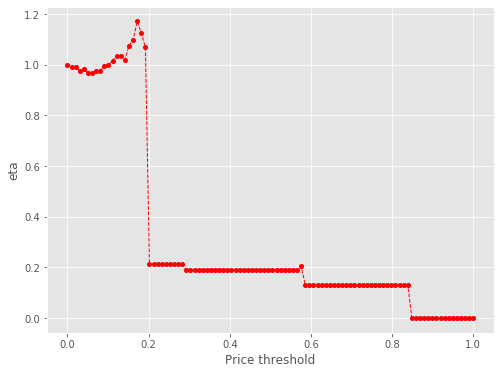

1085 107
Number of cells with price above 18.000000000000004th percentile:  107


eta =  1.0
eta =  0.9978085998315962
eta =  0.98087739725527
eta =  0.9837129527606066
eta =  0.9741823151859318
eta =  0.9730156751694714
eta =  0.9869150842647396
eta =  0.9882090530589751
eta =  1.0000166064035
eta =  1.001209086635377
eta =  1.0215320301229243
eta =  1.0419558117470138
eta =  1.0416035593508142
eta =  1.0251013671252012
eta =  1.081849232553841
eta =  1.1034751977845163
eta =  1.1777382324530932
eta =  1.1322497756517522
eta =  1.0759561444202905
eta =  0.9138273446016961
eta =  0.21284903037707856
eta =  0.21284903037707856
eta =  0.21284903037707856
eta =  0.21284903037707856
eta =  0.21284903037707856
eta =  0.21284903037707856
eta =  0.21284903037707856
eta =  0.21284903037707856
eta =  0.1909768271031708
eta =  0.1909768271031708
eta =  0.1909768271031708
eta =  0.1909768271031708
eta =  0.1909768271031708
eta =  0.1909768271031708
eta =  0.1909768271031708
eta =  0.1909768271031708
eta =  0.1909768271031708
eta =  0.1909768271031708
eta =  0.1909768271031708


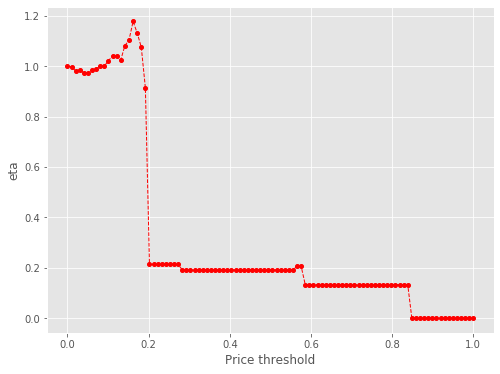

1085 96
Number of cells with price above 19.0th percentile:  96


eta =  1.0
eta =  1.003750621080773
eta =  1.0080922285332794
eta =  1.0022315375171822
eta =  0.9987499626610925
eta =  1.0057229508630243
eta =  0.998078423013547
eta =  1.0291860921993836
eta =  1.0351846849080453
eta =  1.055333102886315
eta =  1.0720539413555894
eta =  1.076679019630895
eta =  1.066100641516765
eta =  1.1065429641217446
eta =  1.1595354390299553
eta =  1.2325852723859032
eta =  1.1580939239733827
eta =  1.1005153634035412
eta =  0.21770741236087185
eta =  0.21770741236087185
eta =  0.21770741236087185
eta =  0.21770741236087185
eta =  0.21770741236087185
eta =  0.21770741236087185
eta =  0.21770741236087185
eta =  0.21770741236087185
eta =  0.21770741236087185
eta =  0.1953359654768637
eta =  0.1953359654768637
eta =  0.1953359654768637
eta =  0.1953359654768637
eta =  0.1953359654768637
eta =  0.1953359654768637
eta =  0.1953359654768637
eta =  0.1953359654768637
eta =  0.1953359654768637
eta =  0.1953359654768637
eta =  0.1953359654768637
eta =  0.19533596547686

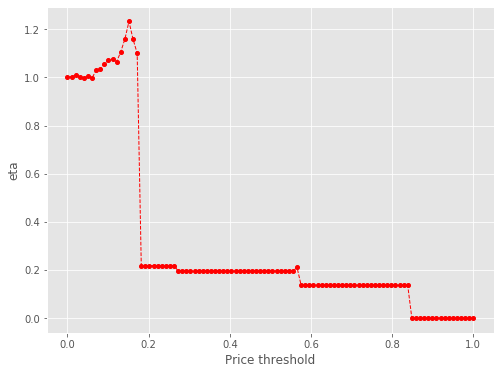

1085 93
Number of cells with price above 20.0th percentile:  93


eta =  1.0
eta =  1.0093229773276378
eta =  1.0034551311741453
eta =  1.007850014806091
eta =  1.0204603029383672
eta =  0.9992969462607564
eta =  1.0240912256404646
eta =  1.0364485100490668
eta =  1.05662152661111
eta =  1.073362779037763
eta =  1.077993503928874
eta =  1.0497798823966498
eta =  1.107893908390981
eta =  1.1300405018544541
eta =  1.2060913611167219
eta =  1.1595078052238688
eta =  1.1018589487604609
eta =  0.9358270246357447
eta =  0.21797320464425832
eta =  0.21797320464425832
eta =  0.21797320464425832
eta =  0.21797320464425832
eta =  0.21797320464425832
eta =  0.21797320464425832
eta =  0.21797320464425832
eta =  0.21797320464425832
eta =  0.19557444514886282
eta =  0.19557444514886282
eta =  0.19557444514886282
eta =  0.19557444514886282
eta =  0.19557444514886282
eta =  0.19557444514886282
eta =  0.19557444514886282
eta =  0.19557444514886282
eta =  0.19557444514886282
eta =  0.19557444514886282
eta =  0.19557444514886282
eta =  0.19557444514886282
eta =  0.1955

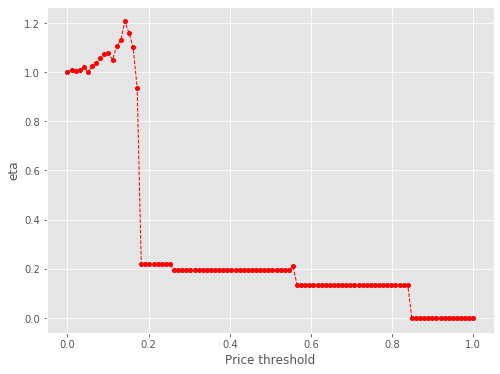

1085 85
Number of cells with price above 21.000000000000004th percentile:  85


eta =  1.0
eta =  0.9819225653739307
eta =  0.9880235867308675
eta =  1.0029660950320218
eta =  0.9968206766923036
eta =  1.0209245375264866
eta =  1.0268749779116777
eta =  1.0468616590981648
eta =  1.0634482748819232
eta =  1.0680362264050043
eta =  1.0400832102090145
eta =  1.097660444949274
eta =  1.12812561444201
eta =  1.2226909775698294
eta =  1.1487975913258925
eta =  1.0916812294096667
eta =  0.21595981617438373
eta =  0.21595981617438373
eta =  0.21595981617438373
eta =  0.21595981617438373
eta =  0.21595981617438373
eta =  0.21595981617438373
eta =  0.21595981617438373
eta =  0.21595981617438373
eta =  0.21595981617438373
eta =  0.1937679509354686
eta =  0.1937679509354686
eta =  0.1937679509354686
eta =  0.1937679509354686
eta =  0.1937679509354686
eta =  0.1937679509354686
eta =  0.1937679509354686
eta =  0.1937679509354686
eta =  0.1937679509354686
eta =  0.1937679509354686
eta =  0.1937679509354686
eta =  0.1937679509354686
eta =  0.1937679509354686
eta =  0.193767950935

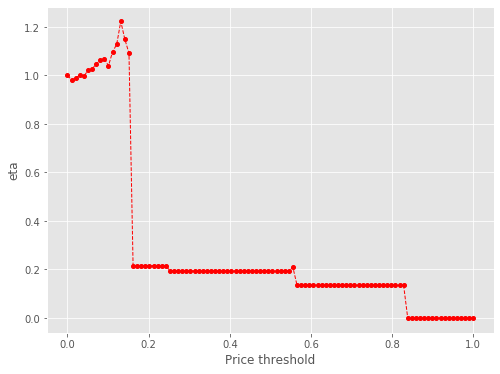

1085 78
Number of cells with price above 22.0th percentile:  78


eta =  1.0
eta =  1.007272967683496
eta =  1.0203401845684061
eta =  1.0204540082923776
eta =  1.0345693197801278
eta =  1.030727270788327
eta =  1.0604766310968698
eta =  1.0613992889071784
eta =  1.0437153527102336
eta =  1.071676953148608
eta =  1.112330812061867
eta =  1.1656004677002292
eta =  1.2390323931585394
eta =  1.1641514127014931
eta =  1.106271683569748
eta =  0.21884614573050862
eta =  0.21884614573050862
eta =  0.21884614573050862
eta =  0.21884614573050862
eta =  0.21884614573050862
eta =  0.21884614573050862
eta =  0.21884614573050862
eta =  0.21884614573050862
eta =  0.21884614573050862
eta =  0.19635768347794863
eta =  0.19635768347794863
eta =  0.19635768347794863
eta =  0.19635768347794863
eta =  0.19635768347794863
eta =  0.19635768347794863
eta =  0.19635768347794863
eta =  0.19635768347794863
eta =  0.19635768347794863
eta =  0.19635768347794863
eta =  0.19635768347794863
eta =  0.19635768347794863
eta =  0.19635768347794863
eta =  0.19635768347794863
eta =  0.

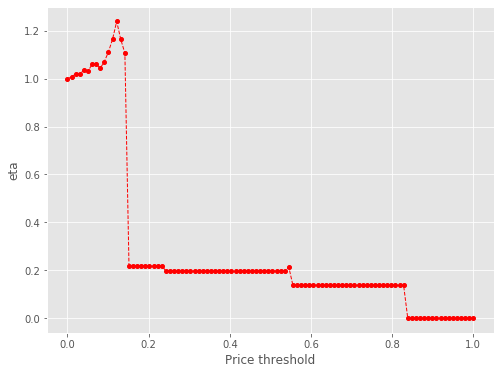

1085 67
Number of cells with price above 23.0th percentile:  67


eta =  1.0
eta =  1.0013111247511224
eta =  1.013275227370267
eta =  1.019559515232989
eta =  1.0248413002086678
eta =  1.0539433287025801
eta =  1.0460002280918481
eta =  1.0285728551051838
eta =  1.0561287812698472
eta =  1.0961928232760045
eta =  1.1667286455282084
eta =  1.2210561844180408
eta =  1.1472615969744633
eta =  1.137644029633331
eta =  0.21567106813009446
eta =  0.21567106813009446
eta =  0.21567106813009446
eta =  0.21567106813009446
eta =  0.21567106813009446
eta =  0.21567106813009446
eta =  0.21567106813009446
eta =  0.21567106813009446
eta =  0.21567106813009446
eta =  0.19350887441896808
eta =  0.19350887441896808
eta =  0.19350887441896808
eta =  0.19350887441896808
eta =  0.19350887441896808
eta =  0.19350887441896808
eta =  0.19350887441896808
eta =  0.19350887441896808
eta =  0.19350887441896808
eta =  0.19350887441896808
eta =  0.19350887441896808
eta =  0.19350887441896808
eta =  0.19350887441896808
eta =  0.19350887441896808
eta =  0.19350887441896808
eta = 

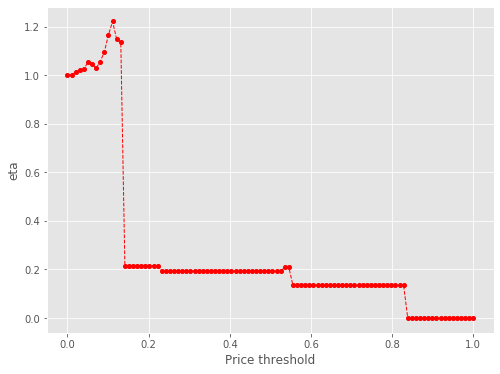

1085 57
Number of cells with price above 24.000000000000004th percentile:  57


eta =  1.0
eta =  1.0311675600519563
eta =  1.0371777017105144
eta =  1.0573649109655092
eta =  1.0737320168943767
eta =  1.078751924503112
eta =  1.050518453323403
eta =  1.1086733653460872
eta =  1.130835540009327
eta =  1.1818824643501904
eta =  1.1149544502706403
eta =  1.1603235750520415
eta =  1.201408915336977
eta =  0.21812655933742883
eta =  0.21812655933742883
eta =  0.21812655933742883
eta =  0.21812655933742883
eta =  0.21812655933742883
eta =  0.21812655933742883
eta =  0.21812655933742883
eta =  0.21812655933742883
eta =  0.21812655933742883
eta =  0.19571204123126545
eta =  0.19571204123126545
eta =  0.19571204123126545
eta =  0.19571204123126545
eta =  0.19571204123126545
eta =  0.19571204123126545
eta =  0.19571204123126545
eta =  0.19571204123126545
eta =  0.19571204123126545
eta =  0.19571204123126545
eta =  0.19571204123126545
eta =  0.19571204123126545
eta =  0.19571204123126545
eta =  0.19571204123126545
eta =  0.19571204123126545
eta =  0.19571204123126545
eta = 

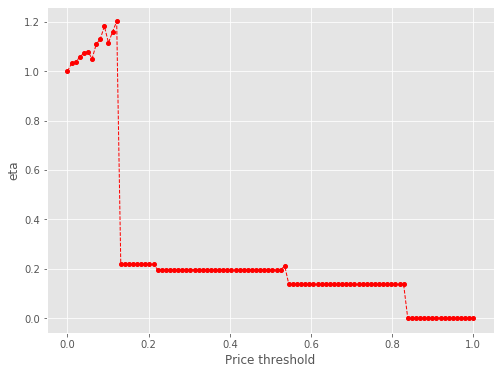

1085 52
Number of cells with price above 25.0th percentile:  52


eta =  1.0
eta =  1.0051804577337222
eta =  1.0337241847639798
eta =  1.0259334668195579
eta =  1.008840425436209
eta =  1.0358677109972354
eta =  1.0751631532029824
eta =  1.1266528452128746
eta =  1.1976311006611575
eta =  1.125252209246747
eta =  1.0693064857218642
eta =  0.9081796795157138
eta =  0.211533573967783
eta =  0.211533573967783
eta =  0.211533573967783
eta =  0.211533573967783
eta =  0.211533573967783
eta =  0.211533573967783
eta =  0.211533573967783
eta =  0.211533573967783
eta =  0.211533573967783
eta =  0.18979654598657497
eta =  0.18979654598657497
eta =  0.18979654598657497
eta =  0.18979654598657497
eta =  0.18979654598657497
eta =  0.18979654598657497
eta =  0.18979654598657497
eta =  0.18979654598657497
eta =  0.18979654598657497
eta =  0.18979654598657497
eta =  0.18979654598657497
eta =  0.18979654598657497
eta =  0.18979654598657497
eta =  0.18979654598657497
eta =  0.18979654598657497
eta =  0.18979654598657497
eta =  0.18979654598657497
eta =  0.189796545986

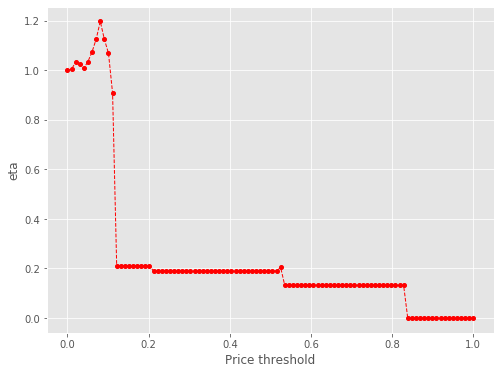

1085 47
Number of cells with price above 26.0th percentile:  47


eta =  1.0
eta =  1.0288624946207054
eta =  1.029757646846185
eta =  1.0126008909340032
eta =  1.039728921045197
eta =  1.0791708375108064
eta =  1.1091228346221755
eta =  1.1748224396153537
eta =  1.1294466011470907
eta =  1.1799986889693128
eta =  0.9115649308047269
eta =  0.2123220680511629
eta =  0.2123220680511629
eta =  0.2123220680511629
eta =  0.2123220680511629
eta =  0.2123220680511629
eta =  0.2123220680511629
eta =  0.2123220680511629
eta =  0.2123220680511629
eta =  0.2123220680511629
eta =  0.190504015022101
eta =  0.190504015022101
eta =  0.190504015022101
eta =  0.190504015022101
eta =  0.190504015022101
eta =  0.190504015022101
eta =  0.190504015022101
eta =  0.190504015022101
eta =  0.190504015022101
eta =  0.190504015022101
eta =  0.190504015022101
eta =  0.190504015022101
eta =  0.190504015022101
eta =  0.190504015022101
eta =  0.190504015022101
eta =  0.190504015022101
eta =  0.190504015022101
eta =  0.190504015022101
eta =  0.190504015022101
eta =  0.1905040150221

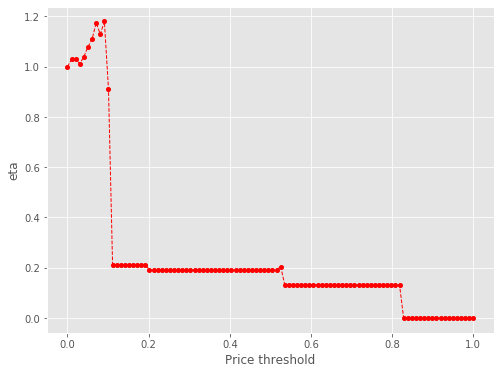

1085 39
Number of cells with price above 27.0th percentile:  39


eta =  1.0
eta =  0.999661931540447
eta =  0.9669304367206473
eta =  1.019889806738013
eta =  1.038287056281148
eta =  1.1050968635463896
eta =  1.1565545808669133
eta =  1.0866581508416804
eta =  1.0326312616043376
eta =  0.20427836572090466
eta =  0.20427836572090466
eta =  0.20427836572090466
eta =  0.20427836572090466
eta =  0.20427836572090466
eta =  0.20427836572090466
eta =  0.20427836572090466
eta =  0.20427836572090466
eta =  0.20427836572090466
eta =  0.20427836572090466
eta =  0.1832868773801128
eta =  0.1832868773801128
eta =  0.1832868773801128
eta =  0.1832868773801128
eta =  0.1832868773801128
eta =  0.1832868773801128
eta =  0.1832868773801128
eta =  0.1832868773801128
eta =  0.1832868773801128
eta =  0.1832868773801128
eta =  0.1832868773801128
eta =  0.1832868773801128
eta =  0.1832868773801128
eta =  0.1832868773801128
eta =  0.1832868773801128
eta =  0.1832868773801128
eta =  0.1832868773801128
eta =  0.1832868773801128
eta =  0.1832868773801128
eta =  0.18328687738

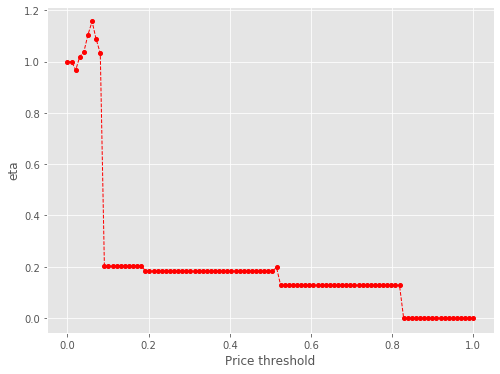

1085 34
Number of cells with price above 28.000000000000004th percentile:  34


eta =  1.0
eta =  0.9738276516236912
eta =  1.0277370915067032
eta =  1.048281365087905
eta =  1.0956017203812467
eta =  1.0335596395660696
eta =  1.0756166906367306
eta =  1.0665997271275136
eta =  0.20220270701987475
eta =  0.20220270701987475
eta =  0.20220270701987475
eta =  0.20220270701987475
eta =  0.20220270701987475
eta =  0.20220270701987475
eta =  0.20220270701987475
eta =  0.20220270701987475
eta =  0.20220270701987475
eta =  0.18142451177680455
eta =  0.18142451177680455
eta =  0.18142451177680455
eta =  0.18142451177680455
eta =  0.18142451177680455
eta =  0.18142451177680455
eta =  0.18142451177680455
eta =  0.18142451177680455
eta =  0.18142451177680455
eta =  0.18142451177680455
eta =  0.18142451177680455
eta =  0.18142451177680455
eta =  0.18142451177680455
eta =  0.18142451177680455
eta =  0.18142451177680455
eta =  0.18142451177680455
eta =  0.18142451177680455
eta =  0.18142451177680455
eta =  0.18142451177680455
eta =  0.18142451177680455
eta =  0.1814245117768045

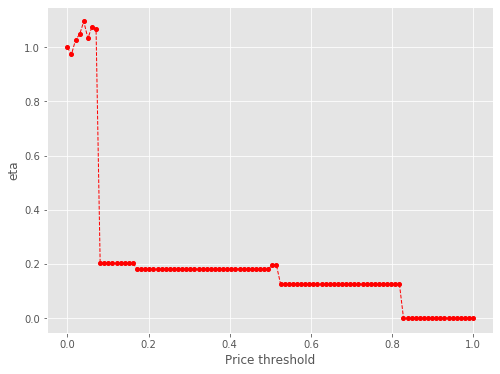

1085 27
Number of cells with price above 29.000000000000004th percentile:  27


eta =  1.0
eta =  1.0553582965046506
eta =  1.0764547128437718
eta =  1.125046838169483
eta =  1.0613373299092355
eta =  1.1045246957645158
eta =  1.0952653945994868
eta =  0.20763705639569413
eta =  0.20763705639569413
eta =  0.20763705639569413
eta =  0.20763705639569413
eta =  0.20763705639569413
eta =  0.20763705639569413
eta =  0.20763705639569413
eta =  0.20763705639569413
eta =  0.20763705639569413
eta =  0.20763705639569413
eta =  0.1863004315746325
eta =  0.1863004315746325
eta =  0.1863004315746325
eta =  0.1863004315746325
eta =  0.1863004315746325
eta =  0.1863004315746325
eta =  0.1863004315746325
eta =  0.1863004315746325
eta =  0.1863004315746325
eta =  0.1863004315746325
eta =  0.1863004315746325
eta =  0.1863004315746325
eta =  0.1863004315746325
eta =  0.1863004315746325
eta =  0.1863004315746325
eta =  0.1863004315746325
eta =  0.1863004315746325
eta =  0.1863004315746325
eta =  0.1863004315746325
eta =  0.1863004315746325
eta =  0.1863004315746325
eta =  0.186300431

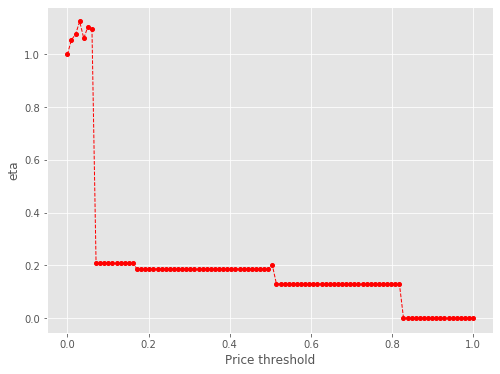

1085 24
Number of cells with price above 30.0th percentile:  24


eta =  1.0
eta =  1.0660330637430349
eta =  1.0468597657644676
eta =  1.046587400149034
eta =  1.0378137910385585
eta =  0.19674555748828484
eta =  0.19674555748828484
eta =  0.19674555748828484
eta =  0.19674555748828484
eta =  0.19674555748828484
eta =  0.19674555748828484
eta =  0.19674555748828484
eta =  0.19674555748828484
eta =  0.19674555748828484
eta =  0.19674555748828484
eta =  0.1765281347497433
eta =  0.1765281347497433
eta =  0.1765281347497433
eta =  0.1765281347497433
eta =  0.1765281347497433
eta =  0.1765281347497433
eta =  0.1765281347497433
eta =  0.1765281347497433
eta =  0.1765281347497433
eta =  0.1765281347497433
eta =  0.1765281347497433
eta =  0.1765281347497433
eta =  0.1765281347497433
eta =  0.1765281347497433
eta =  0.1765281347497433
eta =  0.1765281347497433
eta =  0.1765281347497433
eta =  0.1765281347497433
eta =  0.1765281347497433
eta =  0.1765281347497433
eta =  0.1765281347497433
eta =  0.1765281347497433
eta =  0.1765281347497433
eta =  0.176528134

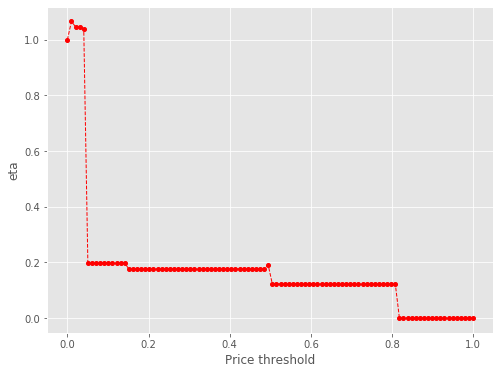

1085 18
Number of cells with price above 31.0th percentile:  18


eta =  1.0
eta =  0.943371683650161
eta =  0.9817588550905508
eta =  0.9735287078194429
eta =  0.18455858845266546
eta =  0.18455858845266546
eta =  0.18455858845266546
eta =  0.18455858845266546
eta =  0.18455858845266546
eta =  0.18455858845266546
eta =  0.18455858845266546
eta =  0.18455858845266546
eta =  0.18455858845266546
eta =  0.18455858845266546
eta =  0.1655934893144131
eta =  0.1655934893144131
eta =  0.1655934893144131
eta =  0.1655934893144131
eta =  0.1655934893144131
eta =  0.1655934893144131
eta =  0.1655934893144131
eta =  0.1655934893144131
eta =  0.1655934893144131
eta =  0.1655934893144131
eta =  0.1655934893144131
eta =  0.1655934893144131
eta =  0.1655934893144131
eta =  0.1655934893144131
eta =  0.1655934893144131
eta =  0.1655934893144131
eta =  0.1655934893144131
eta =  0.1655934893144131
eta =  0.1655934893144131
eta =  0.1655934893144131
eta =  0.1655934893144131
eta =  0.1655934893144131
eta =  0.1655934893144131
eta =  0.1655934893144131
eta =  0.165593489

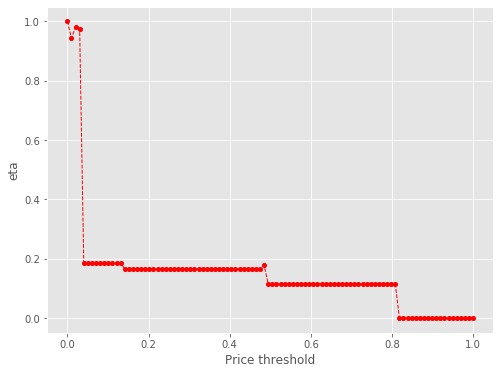

1085 12
Number of cells with price above 32.0th percentile:  12


eta =  1.0
eta =  1.0872710206592568
eta =  1.0775408045103105
eta =  0.19563719332613227
eta =  0.19563719332613227
eta =  0.19563719332613227
eta =  0.19563719332613227
eta =  0.19563719332613227
eta =  0.19563719332613227
eta =  0.19563719332613227
eta =  0.19563719332613227
eta =  0.19563719332613227
eta =  0.19563719332613227
eta =  0.17553366523965078
eta =  0.17553366523965078
eta =  0.17553366523965078
eta =  0.17553366523965078
eta =  0.17553366523965078
eta =  0.17553366523965078
eta =  0.17553366523965078
eta =  0.17553366523965078
eta =  0.17553366523965078
eta =  0.17553366523965078
eta =  0.17553366523965078
eta =  0.17553366523965078
eta =  0.17553366523965078
eta =  0.17553366523965078
eta =  0.17553366523965078
eta =  0.17553366523965078
eta =  0.17553366523965078
eta =  0.17553366523965078
eta =  0.17553366523965078
eta =  0.17553366523965078
eta =  0.17553366523965078
eta =  0.17553366523965078
eta =  0.17553366523965078
eta =  0.17553366523965078
eta =  0.1755336652

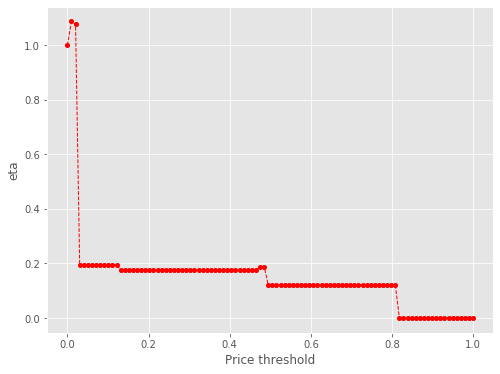

1085 9
Number of cells with price above 33.0th percentile:  9


eta =  1.0
eta =  0.1978231468641861
eta =  0.1978231468641861
eta =  0.1978231468641861
eta =  0.1978231468641861
eta =  0.1978231468641861
eta =  0.1978231468641861
eta =  0.1978231468641861
eta =  0.1978231468641861
eta =  0.1978231468641861
eta =  0.1978231468641861
eta =  0.1978231468641861
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
eta =  0.17749499186703963
e

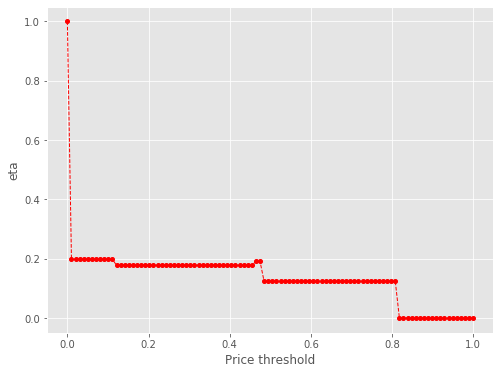

1085 5
Number of cells with price above 34.0th percentile:  5


eta =  1.0
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
e

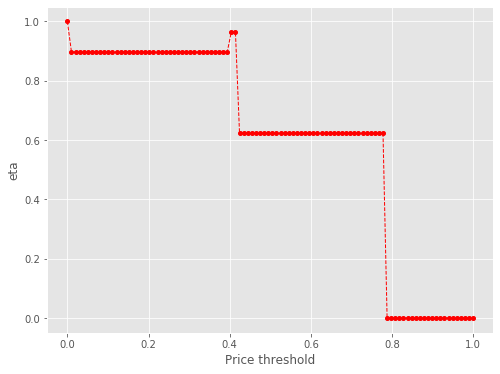

1085 5
Number of cells with price above 35.0th percentile:  5


eta =  1.0
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
e

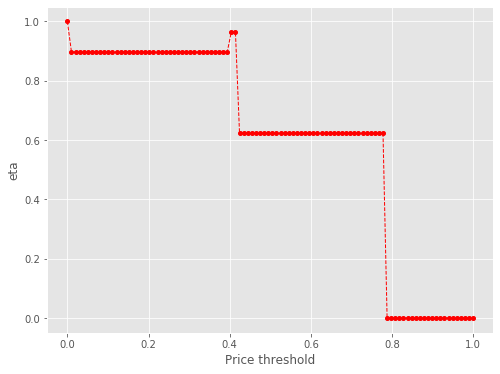

1085 5
Number of cells with price above 36.00000000000001th percentile:  5


eta =  1.0
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
e

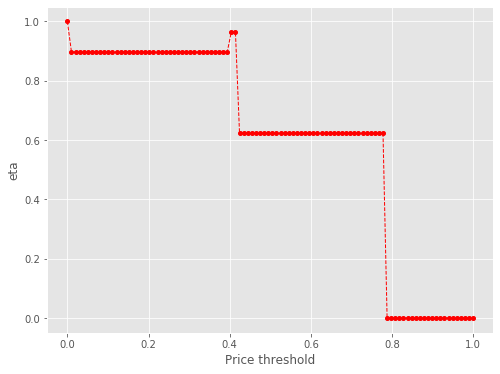

1085 5
Number of cells with price above 37.0th percentile:  5


eta =  1.0
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
e

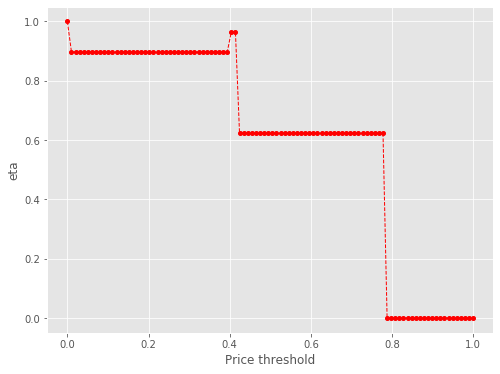

1085 5
Number of cells with price above 38.0th percentile:  5


eta =  1.0
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
e

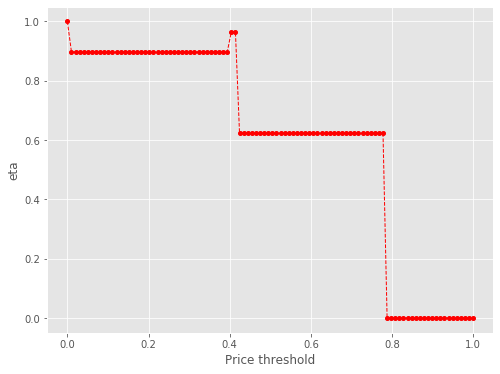

1085 5
Number of cells with price above 39.0th percentile:  5


eta =  1.0
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
e

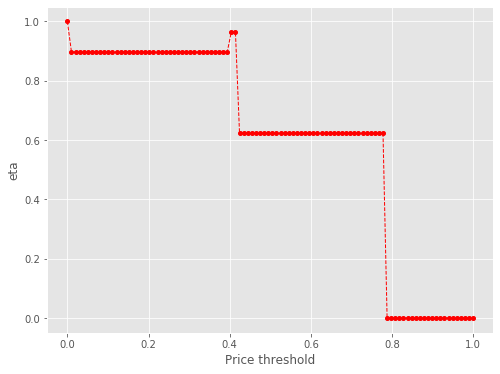

1085 5
Number of cells with price above 40.0th percentile:  5


eta =  1.0
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
eta =  0.8972407662127496
e

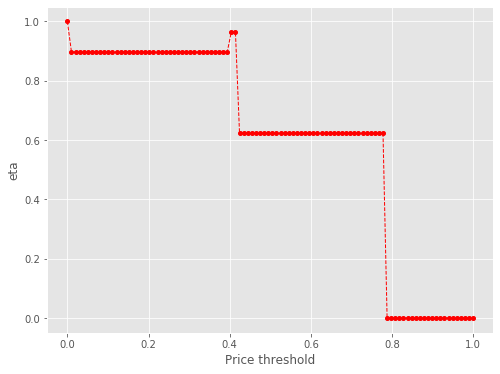

1085 4
Number of cells with price above 41.0th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

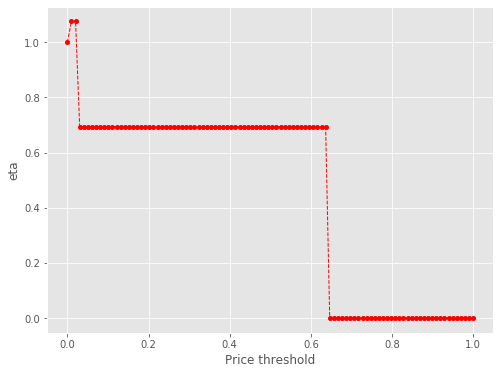

1085 4
Number of cells with price above 42.00000000000001th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

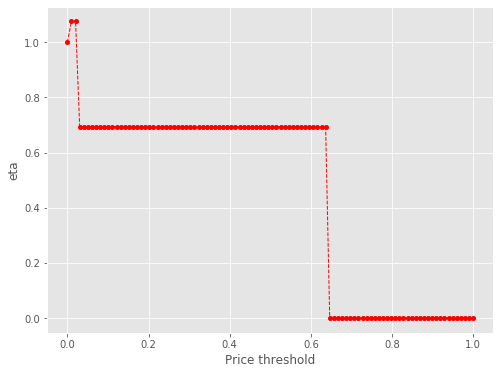

1085 4
Number of cells with price above 43.0th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

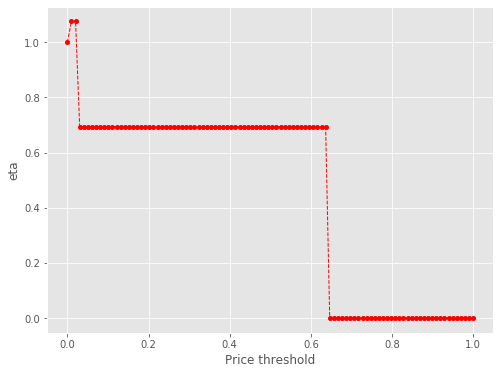

1085 4
Number of cells with price above 44.0th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

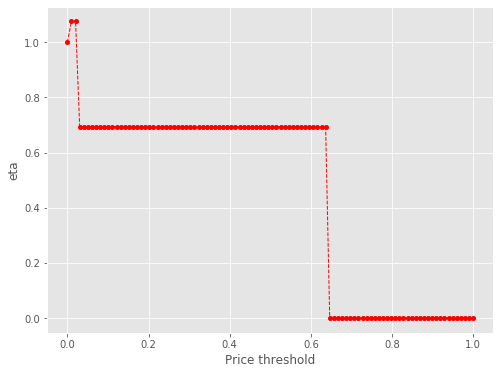

1085 4
Number of cells with price above 45.0th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

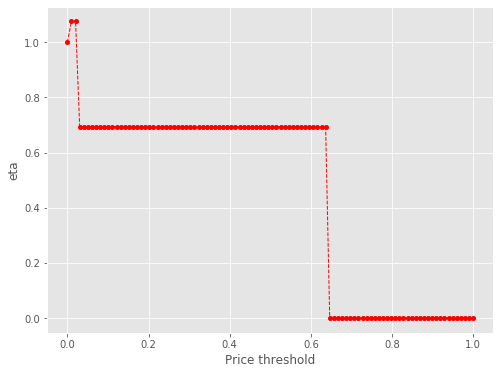

1085 4
Number of cells with price above 46.0th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

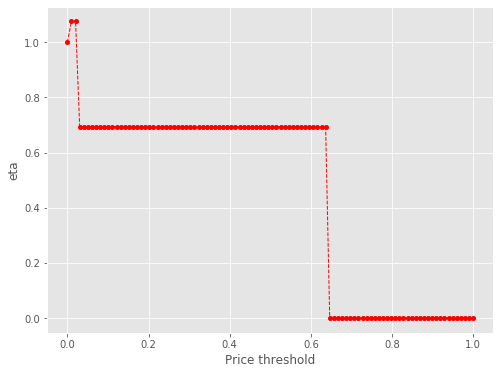

1085 4
Number of cells with price above 47.0th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

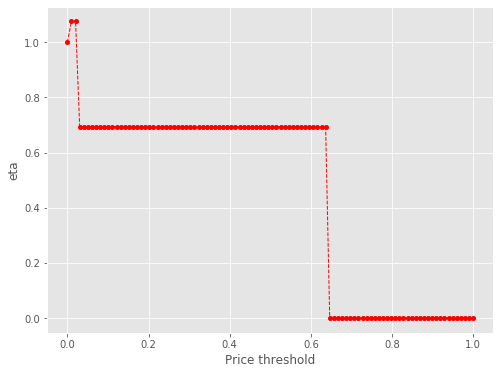

1085 4
Number of cells with price above 48.00000000000001th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

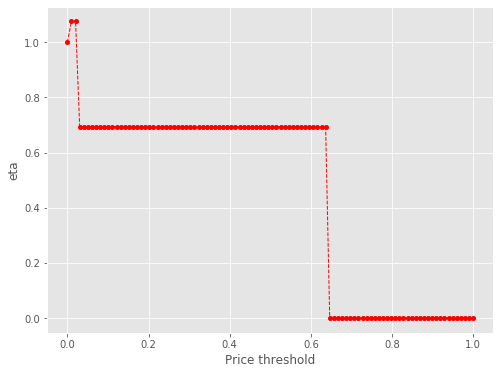

1085 4
Number of cells with price above 49.0th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

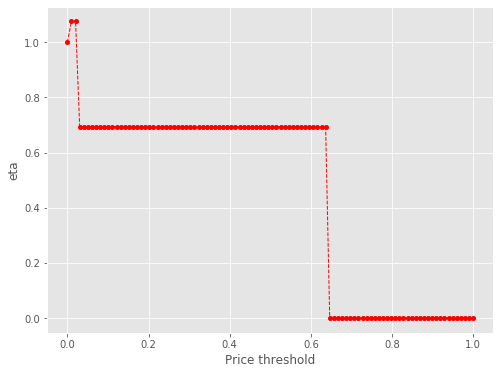

1085 4
Number of cells with price above 50.0th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

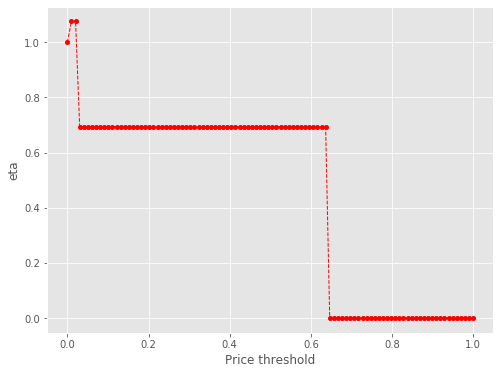

1085 4
Number of cells with price above 51.0th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

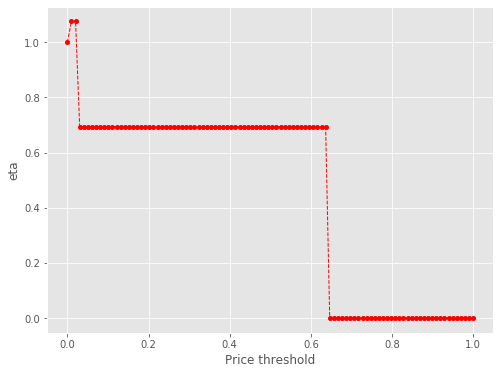

1085 4
Number of cells with price above 52.0th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

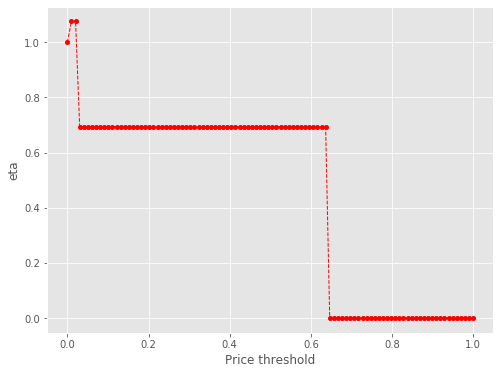

1085 4
Number of cells with price above 53.0th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

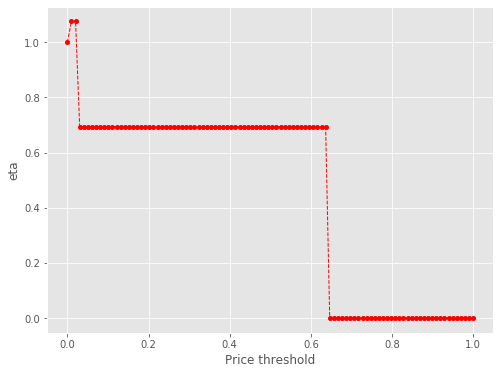

1085 4
Number of cells with price above 54.0th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

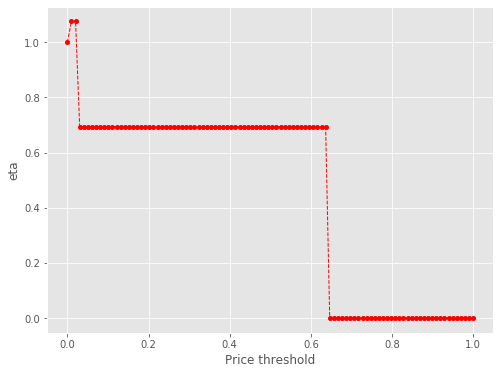

1085 4
Number of cells with price above 55.00000000000001th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

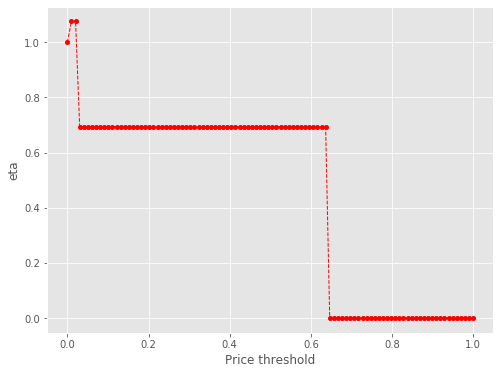

1085 4
Number of cells with price above 56.00000000000001th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

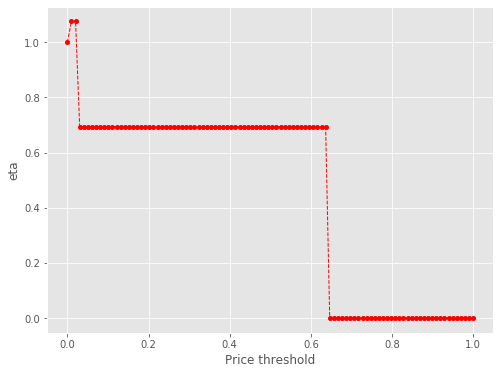

1085 4
Number of cells with price above 57.00000000000001th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

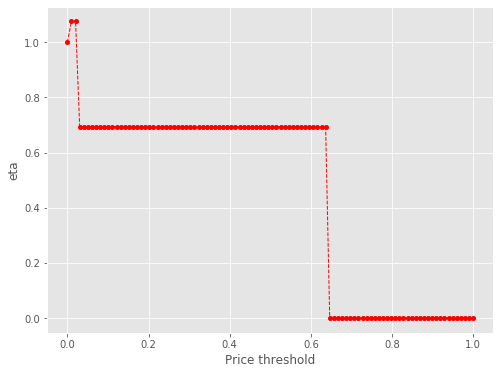

1085 4
Number of cells with price above 58.00000000000001th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

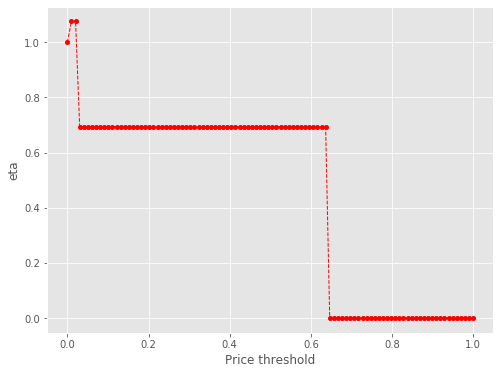

1085 4
Number of cells with price above 59.0th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

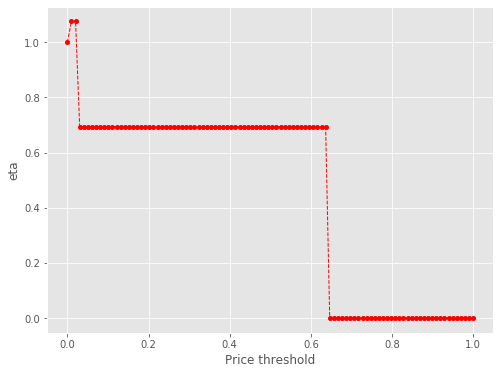

1085 4
Number of cells with price above 60.0th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

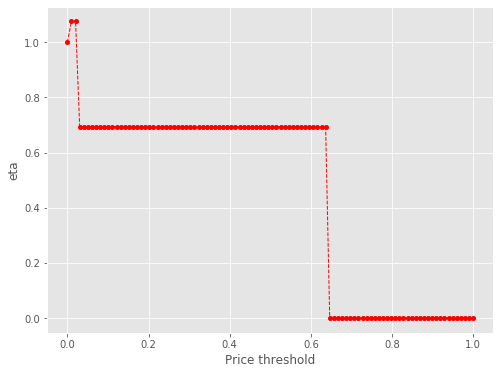

1085 4
Number of cells with price above 61.0th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

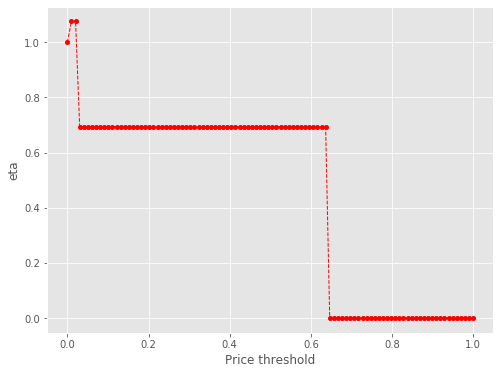

1085 4
Number of cells with price above 62.0th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

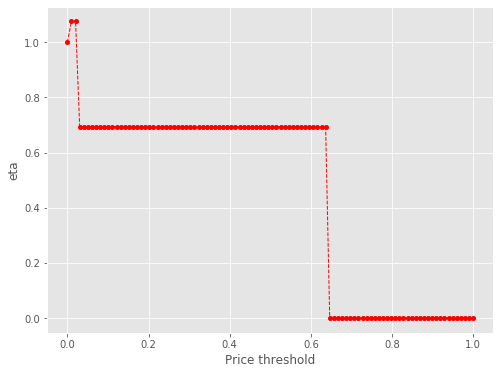

1085 4
Number of cells with price above 63.0th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

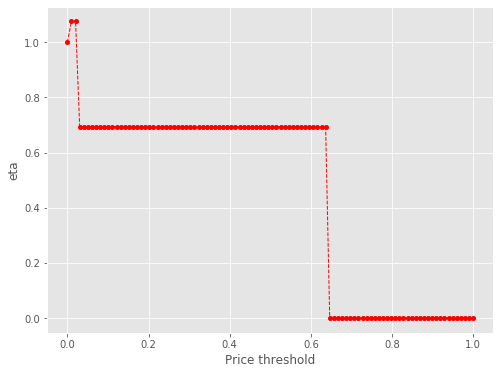

1085 4
Number of cells with price above 64.0th percentile:  4


eta =  1.0
eta =  1.0751779833093376
eta =  1.0751779833093376
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
eta =  0.6941961638663157
e

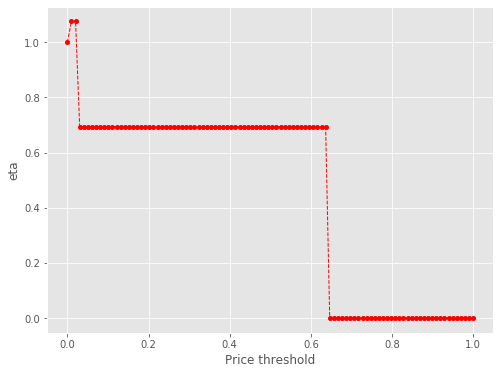

1085 3
Number of cells with price above 65.0th percentile:  3


eta =  1.0
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
eta =  0.6456569746058404
e

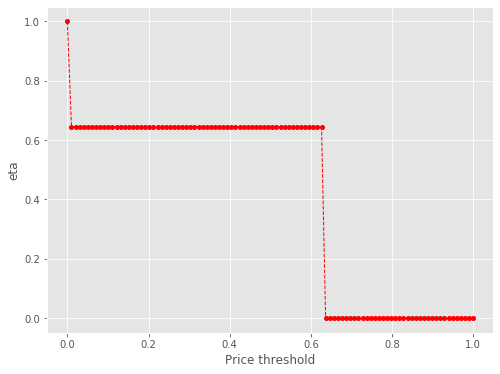

1085 2
Number of cells with price above 66.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

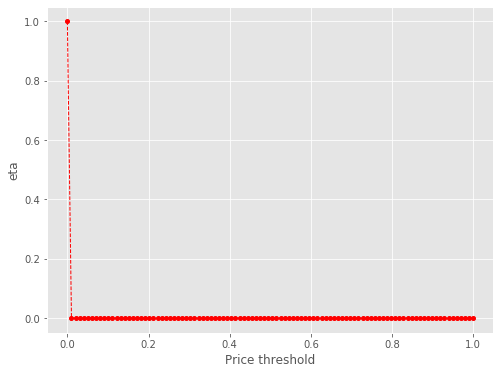

1085 2
Number of cells with price above 67.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

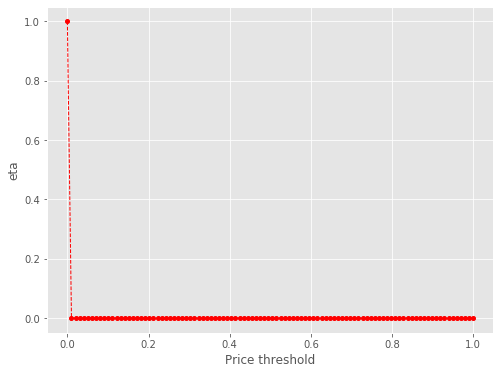

1085 2
Number of cells with price above 68.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

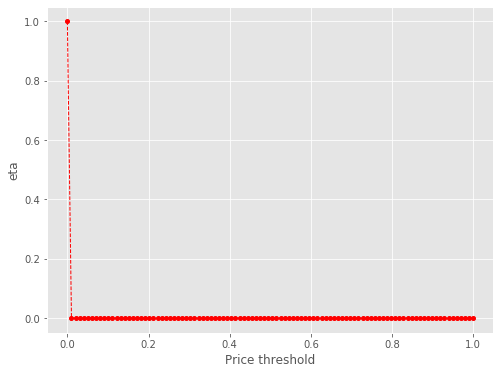

1085 2
Number of cells with price above 69.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

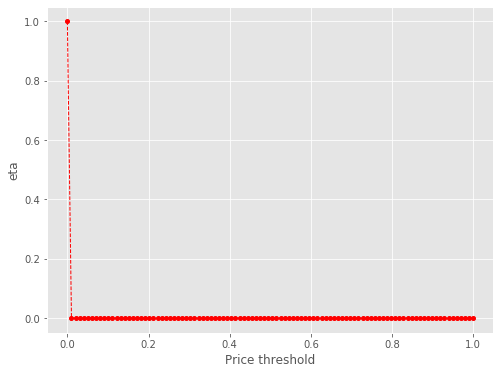

1085 2
Number of cells with price above 70.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

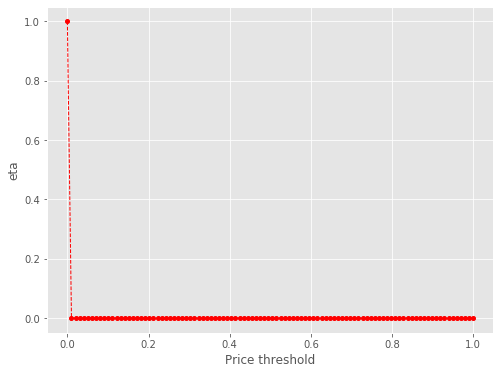

1085 2
Number of cells with price above 71.00000000000001th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

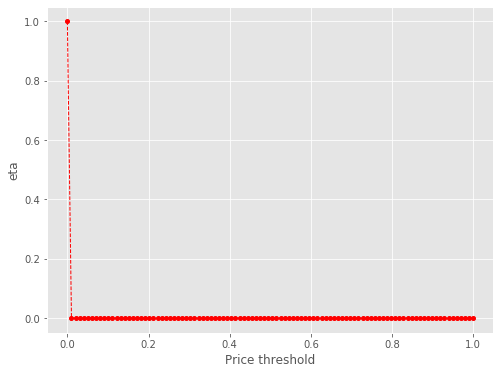

1085 2
Number of cells with price above 72.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

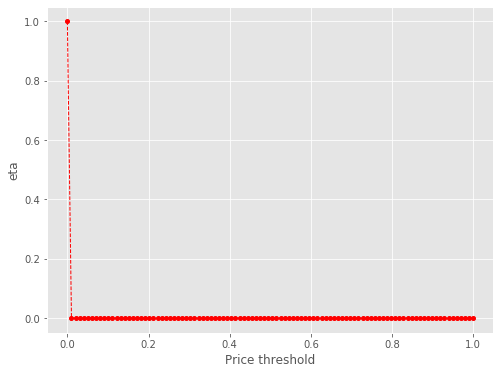

1085 2
Number of cells with price above 73.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

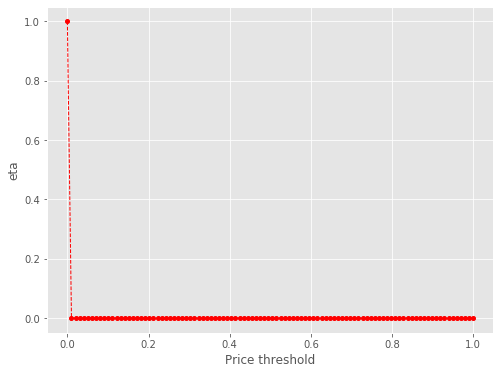

1085 2
Number of cells with price above 74.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

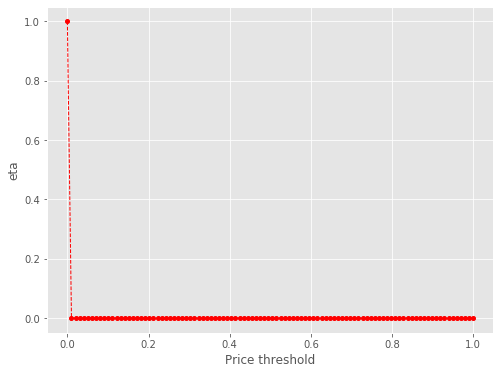

1085 2
Number of cells with price above 75.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

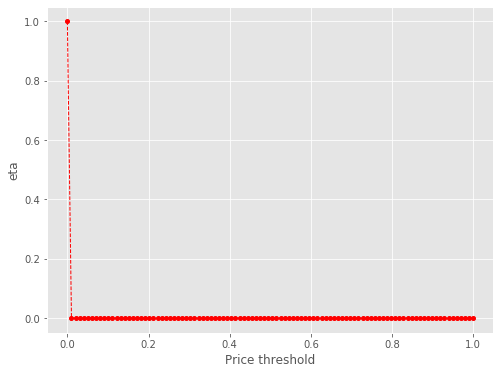

1085 2
Number of cells with price above 76.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

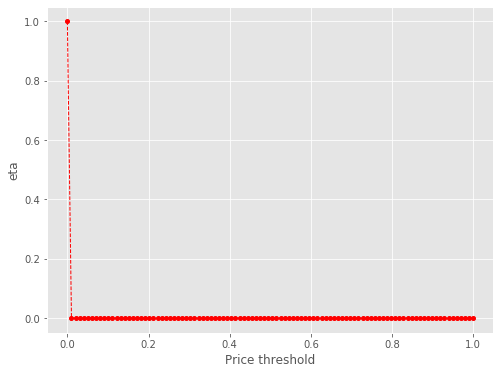

1085 2
Number of cells with price above 77.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

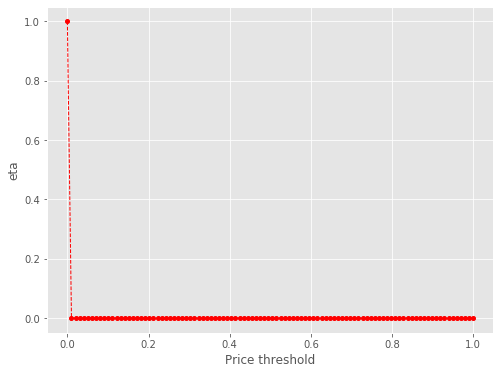

1085 2
Number of cells with price above 78.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

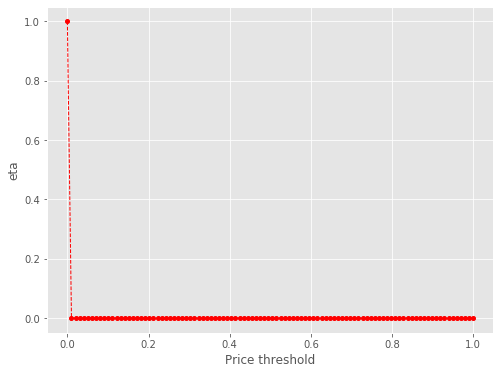

1085 2
Number of cells with price above 79.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

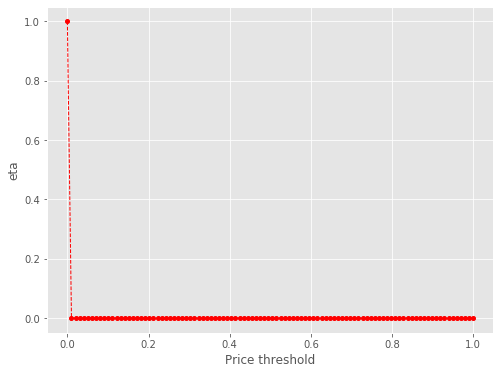

1085 2
Number of cells with price above 80.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

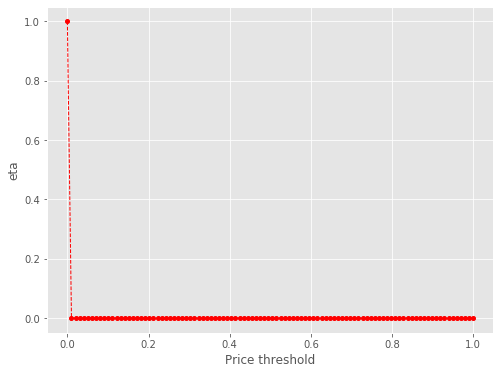

1085 2
Number of cells with price above 81.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

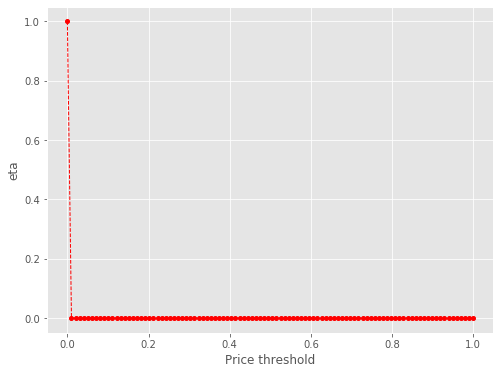

1085 2
Number of cells with price above 82.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

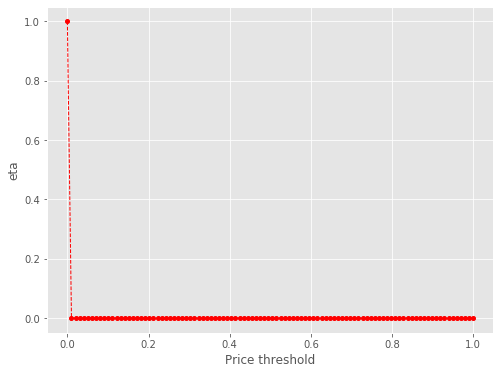

1085 2
Number of cells with price above 83.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

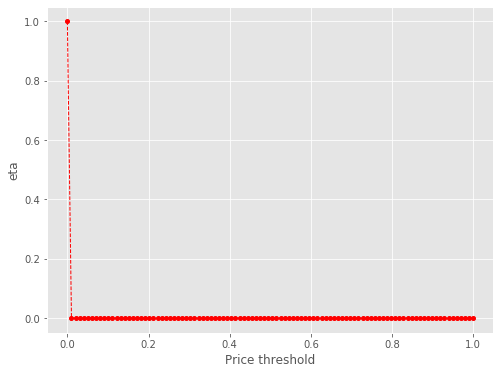

1085 2
Number of cells with price above 84.00000000000001th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

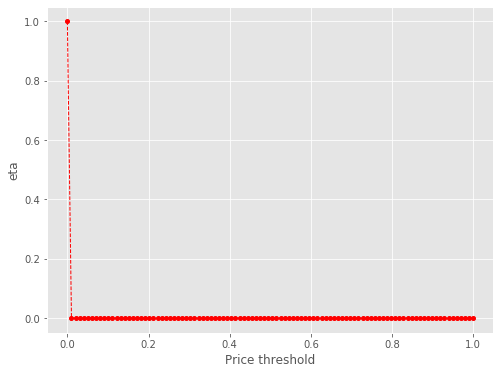

1085 2
Number of cells with price above 85.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

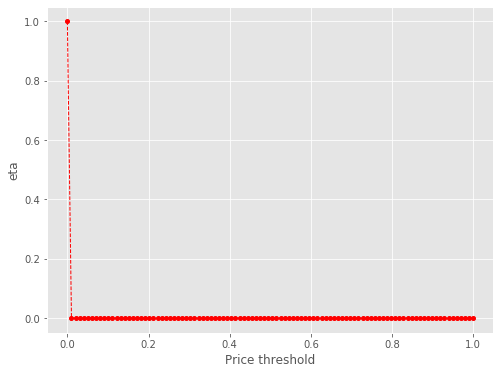

1085 2
Number of cells with price above 86.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

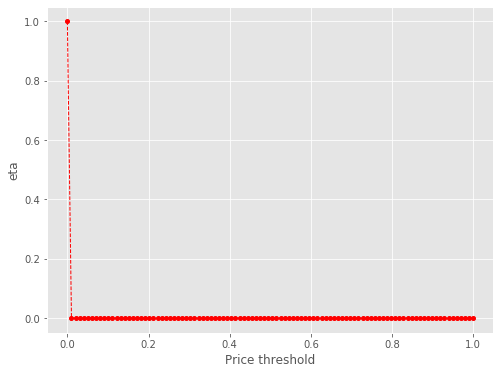

1085 2
Number of cells with price above 87.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

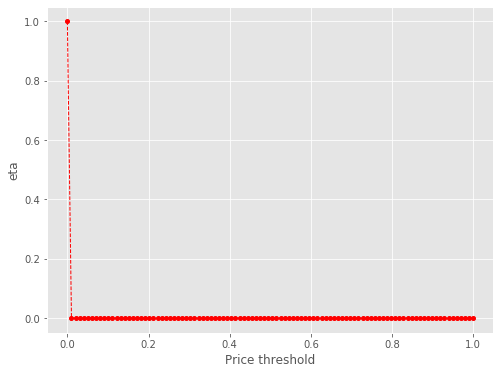

1085 1
Number of cells with price above 88.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning:

invalid value encountered in true_divide



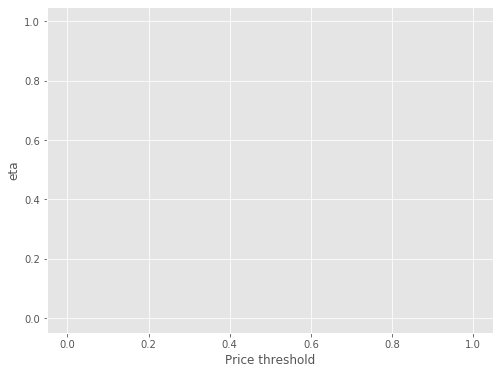

1085 1
Number of cells with price above 89.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

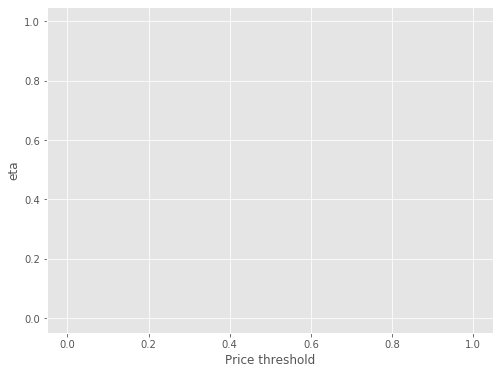

1085 1
Number of cells with price above 90.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

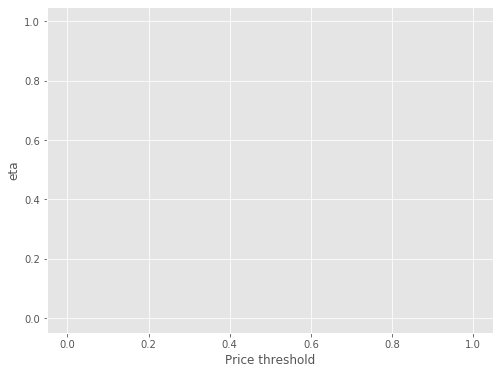

1085 1
Number of cells with price above 91.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

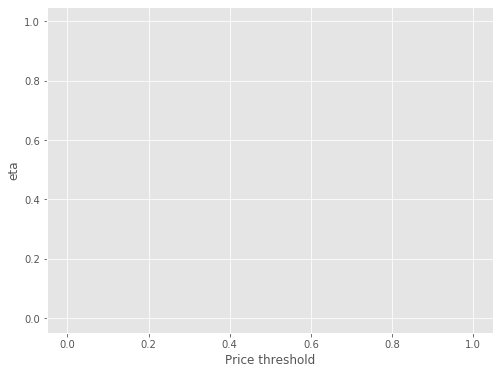

1085 1
Number of cells with price above 92.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

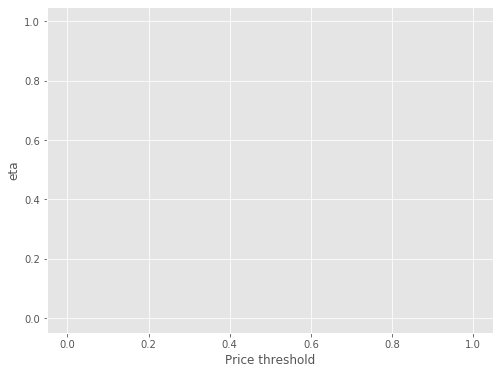

1085 1
Number of cells with price above 93.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

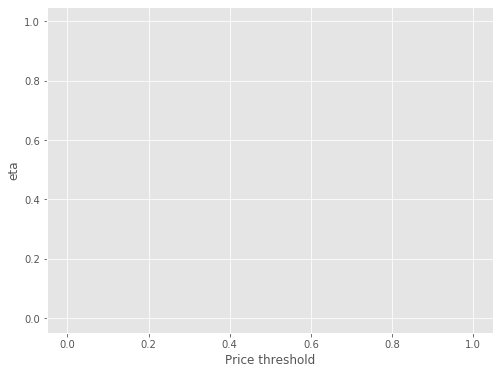

1085 1
Number of cells with price above 94.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

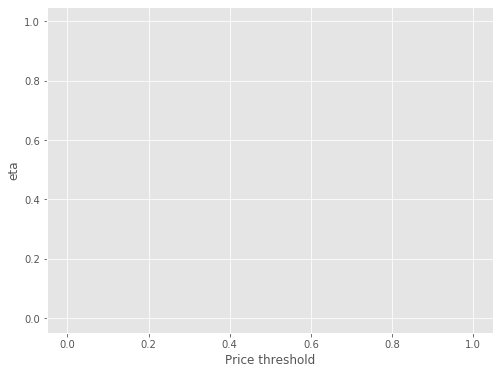

1085 1
Number of cells with price above 95.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

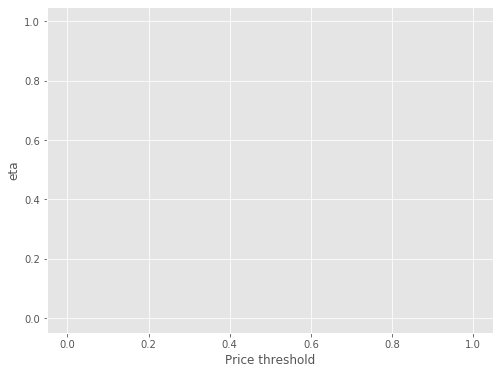

1085 1
Number of cells with price above 96.00000000000001th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

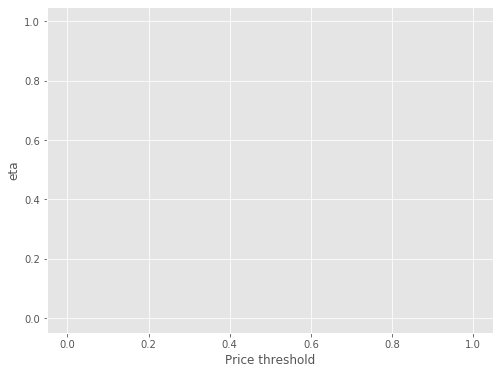

1085 1
Number of cells with price above 97.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

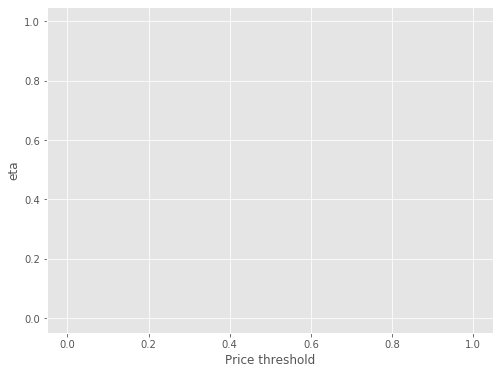

1085 1
Number of cells with price above 98.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

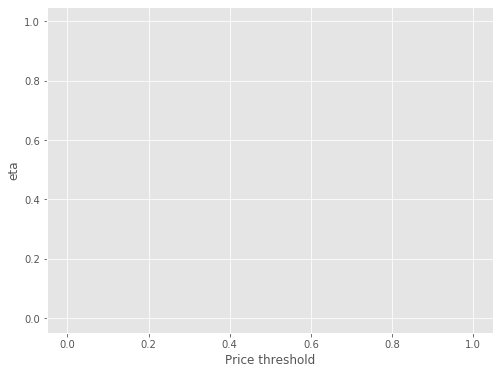

1085 1
Number of cells with price above 99.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

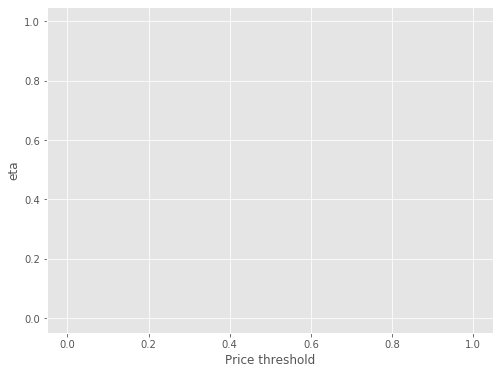

1085 1
Number of cells with price above 100.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

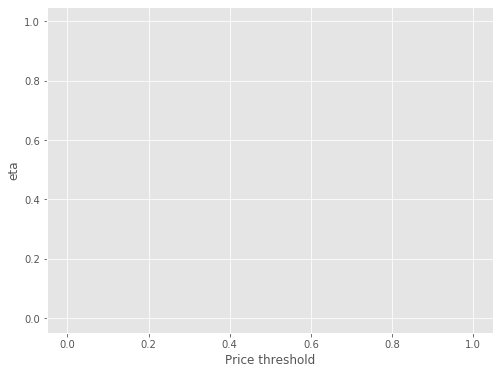


time: 1min 8s


In [30]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
#keys = np.array(keys)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_2d = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    etas = []
    lval = np.linspace(min(vals_cut), max(vals_cut), 100)
    for k in tqdm_notebook(lval):
        loubar_keys = keys[vals_cut>=k]
        dist_mat = mat[keys.reshape(-1,1), keys]

        total_dist = dist_mat.sum()
        dist_corr = dist_mat[dist_mat>0]

        loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

        loubar_dist = loubar_dist_mat.sum()

        loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
        eta = loubar_dist_corr.mean()/dist_corr.mean()
        etas.append(eta)
        print('eta = ', eta)
    etas_array = np.array(etas)
    etas_array = np.where(np.isnan(etas_array), 0, etas_array)
    lval = (lval - lval.min())/(lval - lval.min()).max()
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(lval, etas_array, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
    plt.xlabel("Price threshold")
    plt.ylabel("eta")
    plt.show()
    etas_2d.append(etas)
etas_2d = np.array(etas_2d)
etas_2d = np.where(np.isnan(etas_2d), 0, etas_2d)
lval = lval/lval.max()

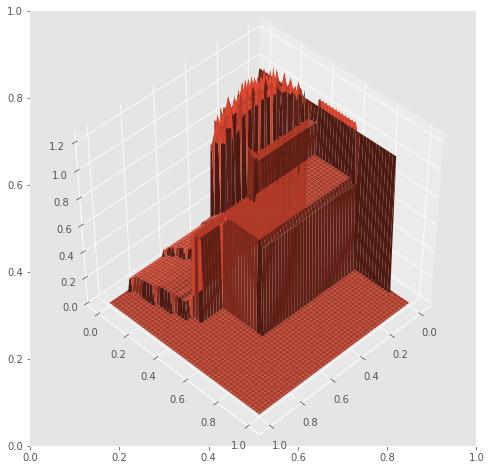

time: 1.11 s


In [31]:
X,Y = np.meshgrid(np.linspace(0,1, 100),np.linspace(0,1, 100))
etas_surface = etas_2d
fig, ax = plt.subplots(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot a 3D surface
ax.plot_surface(X, Y, etas_surface)
ax.view_init(45, 45)
plt.show()

In [32]:
pickle_in = open("etas_surface_dict.pickle","rb")
etas_surface_dict = pickle.load(pickle_in)
#etas_surface_dict = {}
etas_surface_dict['Buenos_Aires'] = etas_surface


pickle_out = open("etas_surface_dict.pickle","wb")
pickle.dump(etas_surface_dict, pickle_out)
pickle_out.close()

etas_surface_dict

{'NY': array([[1.        , 0.40697941, 0.38848337, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.95418349, 0.92471336, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.96911482, 0.94572765, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 'Boston': array([[1.        , 0.94621367, 0.92299712, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.97340556, 0.95206791, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.96708982, 0.94781127, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.       

time: 22 ms


1085 233
Number of cells with price above 5th percentile:  233
total number of cells:  1118
number of cells within urban airbnb territory:  233



Mean travel times in minutes:  13.769894457519959
Mean travel times in minutes:  26.73272552955835
Mean travel times in minutes:  39.78678136969865


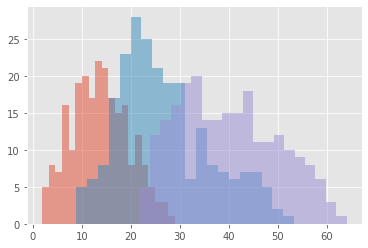

time: 38.2 s


In [33]:
from tqdm import tqdm_notebook

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

print('total number of cells: ', len(polylist))

times_names = ['times_{}'.format(c) for c in range(1, len(centers)+1)]
times_dict = {name:[] for name in times_names}

plist = poly_prices[poly_prices.index.isin(keys)].geometry.tolist()
print('number of cells within urban airbnb territory: ', len(plist))
for poly in tqdm_notebook(plist):
    origin = ox.get_nearest_node(G, poly.centroid.coords[0][::-1])
    dists_to_centers = []
    for node, target in centers.items():
        try:
            if origin!=target:
                path = nx.shortest_path(G, origin, target, weight='length')
                edges = [ tuple( path[i:i+2] ) for i in range( len(path) - 1 ) ]
                dist = np.sum([G.get_edge_data(*edge)[0]['length'] for edge in edges])
                dists_to_centers.append(dist)
        except:
            pass
    if len(dists_to_centers) != 0:
        dists_to_centers = sorted(dists_to_centers)
        #print('distance list length equal to # of centers: ', len(dists_to_centers)==len(centers))
        if len(dists_to_centers)==len(centers):
            for n, dist in enumerate(dists_to_centers):
                time = (dist/3.1)/60
                times_dict['times_{}'.format(n+1)].append(time)
                #print(times_dict['times_{}'.format(n+1)][-1])
        else:
            print('Distance list length NOT equal to # of centers')

#print(distances_dict)
for center in range(1, len(centers)+1):
    print("Mean travel times in minutes: ", np.mean(times_dict['times_{}'.format(center)]))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=0.5)
plt.show()

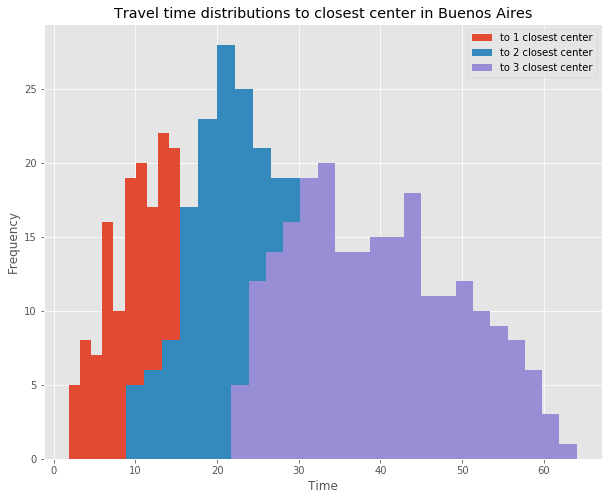

time: 444 ms


In [34]:
for center in range(1, len(centers)+1):
    times_dict['times_{}'.format(center)] = np.array(times_dict['times_{}'.format(center)])

fig, ax = plt.subplots(figsize=(10,8))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=1, label='to {} closest center'.format(center))
plt.title('Travel time distributions to closest center in Buenos Aires')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [35]:
pickle_in = open("City_Accessibility.pickle","rb")
access_dict = pickle.load(pickle_in)
#access_dict = {}
access_dict['Buenos_Aires'] = times_dict


pickle_out = open("City_Accessibility.pickle","wb")
pickle.dump(access_dict, pickle_out)
pickle_out.close()

access_dict

{'Paris': {'times_1': array([ 4.73219737,  4.40047807,  7.81577632,  7.07926754,  6.7129386 ,
          7.48037281, 10.85755263,  8.41227193, 14.20045614, 15.15502193,
         16.00692982, 15.80582895, 14.35941228, 14.10681579, 12.26687281,
         13.89203947, 14.31310965, 15.99389474, 16.77728947, 17.82112281,
         20.19769737, 20.40849561, 21.93033333, 22.03087719, 20.6584386 ,
         20.62538596, 19.53197368, 20.61141228, 21.70609211, 23.22407018,
         21.70395614, 23.12607456, 22.79396053, 23.95434211, 21.49400439,
         21.55605702, 22.35374123, 22.36948246, 22.44162719, 21.54410965,
         21.93589912, 21.86757456, 21.86757456, 21.41060088, 21.92571491,
         22.93862281, 23.57200877, 25.13889474, 24.49192982, 26.04400877,
         26.815     , 38.90660088, 38.56507018, 37.89241228, 36.57546491,
         29.87379386, 27.54254825, 25.54755702, 26.98263158, 25.76562281,
         25.03485526, 25.37799123, 25.69687719, 26.07382018, 23.81846491,
         24.034649

time: 737 ms


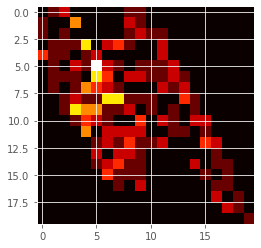

time: 179 ms


In [36]:
x = times_dict['times_{}'.format(1)]
y = times_dict['times_{}'.format(2)]
c_xy = np.histogram2d(x, y, 20)[0]
c_xx = np.histogram2d(x, x, 20)[0]
plt.imshow(c_xy, cmap='hot', interpolation='nearest')
plt.show()

In [37]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

mi_list = []
for center in range(1, len(centers)+1):
    mi_list.append(times_dict['times_{}'.format(center)])

mis = []
for pair in combinations_with_replacement(mi_list, 2):
    MI = calc_MI(pair[0], pair[1], 20)
    print(MI)
    mis.append(MI)
mis = np.array(mis)
avg_mi = np.mean(mis)
print('average mutual information = ', avg_mi)

2.8221608196820784
0.8566679933561678
0.8412016641314422
2.759664498638411
1.2103122208746857
2.88343993661488
average mutual information =  1.8955745222162779
time: 17 ms


In [38]:
pickle_in = open("Time_distribution_mutual_information.pickle","rb")
MI_dict = pickle.load(pickle_in)
#MI_dict = {}
MI_dict['Buenos_Aires'] = avg_mi


pickle_out = open("Time_distribution_mutual_information.pickle","wb")
pickle.dump(MI_dict, pickle_out)
pickle_out.close()

MI_dict

{'Beijing': 1.629373608642793,
 'Florence': 2.0836399429599792,
 'Palermo': 1.8596013030930105,
 'Los_Angeles': 1.5602500680599918,
 'Moscow': 1.5631970905638934,
 'Porto': 1.6277816420571996,
 'Prague': 2.176480497902222,
 'Reykjavik': 1.3730161847793374,
 'Riga': 2.240374487910287,
 'Rome': 1.6095563575725969,
 'Seoul': 1.2910685865906735,
 'Siena': 2.7660068415344448,
 'Sydney': 1.2791891753795948,
 'Tallin': 2.3884073435187867,
 'Treviso': 2.631909071373147,
 'Valencia': 2.1872520197930965,
 'Venezia': 2.719891808939249,
 'Verona': 2.7080241467515376,
 'Vicenza': 2.6192607829416756,
 'Vienna': 1.4481542925032476,
 'Wellington': 2.1855226822614866,
 'Zurich': 2.462051055806955,
 'Aarhus': 2.2910468431831847,
 'Milan': 1.6107461389394335,
 'Busan': 1.903641833377143,
 'Barcelona': 1.6449937230537024,
 'Bologna': 2.7317991260148045,
 'Bremen': 1.9957279038792954,
 'Brno': 2.4300669174144036,
 'Budapest': 2.219525897631017,
 'Dublin': 1.830502368836079,
 'Boston': 1.1451275682586615,
 

time: 5.98 ms
